#####    
학번: 2021136138   
이름: 추승연

# [문제 2]    
적절한 새로운 모델 구성 및 하이퍼파라미터 찾기

Regression	및 Classification 문제를 학습할 때 다음 사항들을 적절하게 설정하여 가장 학습이 잘 되는 모델 구성 및 하이퍼파라미터 값을 찾아 제시   
• LSTM	layers 개수 변경   
• LSTM	Layer	이후에 사용하는 Linear	Layer	개수 변경   
• weight decay 값 변경   
(수업에서 제시하고 있는 실습 화일내 weight_decay 값 설정 방법 참고)   
• dropout	rate 값 변경   
(dropout	rate 설정을 위하여 https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html 참고)

## 기본 코드

##### wandb

In [1]:
# 설치
!pip install --upgrade wandb -qq

In [2]:
# 로그인

import wandb
wandb.login()

# 3311438f3e36a3c75b01bcf54e5812513fb7044c

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: choo0412 (choo0412-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


True

##### import

In [12]:
from datetime import datetime
import os
from pathlib import Path
import sys
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import wandb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Set BASE_PATH
BASE_PATH = "/home/work/dl_choo/"  # 데이터가 있는 경로로 수정
print("BASE_PATH:", BASE_PATH)
sys.path.append(BASE_PATH)

# Set CHECKPOINT_FILE_PATH
CURRENT_FILE_PATH = os.getcwd()  # 현재 작업 디렉토리
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

print("CHECKPOINT_FILE_PATH:", CHECKPOINT_FILE_PATH)


BASE_PATH: /home/work/dl_choo/
CHECKPOINT_FILE_PATH: /home/work/dl_choo/checkpoints


##### utils

In [13]:
# _01_code/_99_common_utils/utils.py

import os
import sys


def is_linux():
    if sys.platform.startswith("linux"):
        return True
    else:
        return False


def is_windows():
    if os.name == "nt":
        return True
    else:
        return False


def is_mac():
    if sys.platform == "darwin":
        return True
    else:
        return False


def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()


from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)


def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )


if __name__ == "__main__":
    if is_linux():
        print("Linux")
    elif is_windows():
        print("Windows")
    elif is_mac():
        print("Mac")
    else:
        print("<unknown>")


Linux


##### get_parser

In [14]:
import argparse


def get_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
        "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-4)"
    )

    parser.add_argument(
        "-w", "--weight_decay", type=float, default=0.0, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
        "-v", "--validation_intervals", type=int, default=30,
        help="Number of training epochs between validations (int, default: 30)"
    )

    parser.add_argument(
        "-p", "--early_stop_patience", type=int, default=30,
        help="Number of early stop patience (int, default: 30)"
    )

    parser.add_argument(
        "-d", "--early_stop_delta", type=float, default=0.000001,
        help="Delta value of early stop (float, default: 0.000001)"
    )


    parser.add_argument(
        "--hidden_size", type=int, default=64, help="Hidden size of LSTM layers (int, default: 64)"
    )

    parser.add_argument(
        "--dropout_rate", type=float, default=0.5, help="Dropout rate (float, default: 0.5)"
    )

    parser.add_argument(
        "--lstm_layers", type=int, default=1, help="Number of LSTM layers (int, default: 1)"
    )

    parser.add_argument(
        "--linear_layers", type=int, default=1, help="Number of fully connected layers (int, default: 1)"
    )

    return parser


##### class EarlyStopping

In [15]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss




##### class CryptoCurrencyDataset

In [16]:
class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str




## 실습 코드

### _01_code/_11_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

##### get_crytocurrency_data

In [17]:
def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    # 수정된 BASE_PATH 설정
    BASE_PATH = "/home/work/dl_choo"  # 데이터 파일이 저장된 경로로 수정
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")  # 파일 경로 설정

    # 파일 읽기
    if not os.path.exists(btc_krw_path):
        raise FileNotFoundError(f"File not found: {btc_krw_path}")
    df = pd.read_csv(btc_krw_path)
    row_size = len(df)

    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    # 데이터 크기 계산
    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)
    if train_size <= 0:
        raise ValueError("Insufficient data for the given sequence size, validation size, and test size.")

    #################################################################################################
    # 데이터 분할: 훈련 데이터
    row_cursor = 0
    X_train_list, y_train_regression_list, y_train_classification_list, y_train_date = [], [], [], []

    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    # 정규화
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, unbiased=False, keepdim=True)
    s[s == 0] = 1e-7  # 표준편차가 0인 경우 방지
    X_train = (X_train - m) / s

    #################################################################################################
    # 데이터 분할: 검증 데이터
    X_validation_list, y_validation_regression_list, y_validation_classification_list, y_validation_date = [], [], [], []

    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)
    X_validation = (X_validation - m) / s

    #################################################################################################
    # 데이터 분할: 테스트 데이터
    X_test_list, y_test_regression_list, y_test_classification_list, y_test_date = [], [], [], []

    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)
    X_test = (X_test - m) / s

    #################################################################################################
    # 결과 반환
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


##### get_btc_krw_data

In [18]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

##### class RegressionTrainer

In [19]:
#from _01_code._06_fcn_best_practice.c_trainer import EarlyStopping
#from _01_code._99_common_utils.utils import strfdelta


class RegressionTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.MSELoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

      loss_train += loss.item()

      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains

    return train_loss

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)

        loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()

        num_validations += 1

    validation_loss = loss_validation / num_validations

    return validation_loss

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 1000 * epoch / elapsed_time.microseconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"V_loss: {validation_loss:7.5f}, "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Validation loss": validation_loss,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


##### get_model

In [20]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      # 변경1 - LSTM layers 개수 (num_layers)
      # 변경4 - dropout rate (dropout)
      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=1, batch_first=True, dropout=0.5)
      # 변경2 - LSTM Layer 이후에 사용하는 Linear Layer 개수
      self.fcn_1 = nn.Linear(in_features=128, out_features=128)

      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn_1(x)

      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model

##### main

In [21]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

##### run

**기존 설정**   
LSTM layers 개수: 2   
Linear Layer 개수: 1 (128,1)   
Weight decay 값: 0.0(default)   
Dropout rate 값: 0(default)

In [13]:
if __name__ == "__main__":
  args_str = "--wandb"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch   1] T_loss: 11.00776, V_loss: 82.35334, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.004
[Epoch  30] T_loss: 7.42321, V_loss: 53.26044, V_loss decreased (82.35334 --> 53.26044). Saving model... | T_time: 00:00:01, T_speed: 0.085
[Epoch  60] T_loss: 0.47584, V_loss: 4.67703, V_loss decreased (53.26044 --> 4.67703). Saving model... | T_time: 00:00:02, T_speed: 0.092
[Epoch  90] T_loss: 0.19890, V_loss: 3.20096, V_loss decreased (4.67703 --> 3.20096). Saving model... | T_time: 00:00:03, T_speed: 0.110
[Epoch 120] T_loss: 0.11193, V_loss: 2.19314, V_loss decreased (3.20096 --> 2.19314). Saving model... | T_time: 00:00:05, T_speed: 18.756
[Epoch 150] T_loss: 0.08734, V_loss: 1.72950, V_loss decreased (2.19314 --> 1.72950). Saving model... | T_time: 00:00:06, T_speed: 0.959
[Epoch 180] T_loss: 0.07420, V_loss: 1.54951, V_loss decreased (1.72950 --> 1.54951). Saving model... | T_time: 00:00:07, T_speed: 0.541
[Epoch 210] T_loss: 0.06508, V_loss: 1.42250, V_loss decreased (

[Epoch 1830] T_loss: 0.01464, V_loss: 0.12238, V_loss decreased (0.12605 --> 0.12238). Saving model... | T_time: 00:01:10, T_speed: 10.356
[Epoch 1860] T_loss: 0.01448, V_loss: 0.12011, V_loss decreased (0.12238 --> 0.12011). Saving model... | T_time: 00:01:11, T_speed: 3.824
[Epoch 1890] T_loss: 0.01434, V_loss: 0.11908, V_loss decreased (0.12011 --> 0.11908). Saving model... | T_time: 00:01:12, T_speed: 2.819
[Epoch 1920] T_loss: 0.01437, V_loss: 0.11387, V_loss decreased (0.11908 --> 0.11387). Saving model... | T_time: 00:01:13, T_speed: 2.693
[Epoch 1950] T_loss: 0.01420, V_loss: 0.11735, Early stopping counter: 1 out of 30 | T_time: 00:01:14, T_speed: 2.543
[Epoch 1980] T_loss: 0.01405, V_loss: 0.11205, V_loss decreased (0.11387 --> 0.11205). Saving model... | T_time: 00:01:15, T_speed: 2.550
[Epoch 2010] T_loss: 0.01382, V_loss: 0.11008, V_loss decreased (0.11205 --> 0.11008). Saving model... | T_time: 00:01:16, T_speed: 2.104
[Epoch 2040] T_loss: 0.01400, V_loss: 0.11056, Early 

[Epoch 3780] T_loss: 0.01127, V_loss: 0.08171, Early stopping counter: 26 out of 30 | T_time: 00:02:21, T_speed: 4.888
[Epoch 3810] T_loss: 0.01150, V_loss: 0.08849, Early stopping counter: 27 out of 30 | T_time: 00:02:22, T_speed: 4.234
[Epoch 3840] T_loss: 0.01117, V_loss: 0.08755, Early stopping counter: 28 out of 30 | T_time: 00:02:23, T_speed: 4.070
[Epoch 3870] T_loss: 0.01153, V_loss: 0.08336, Early stopping counter: 29 out of 30 | T_time: 00:02:24, T_speed: 3.997
[Epoch 3900] T_loss: 0.01118, V_loss: 0.08449, Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:25, T_speed: 4.044
Final training time: 00:02:25


Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇█████
Training loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▃▁▁▁▁▁▃▁▁█▁▁▁▂▁▁▁▁
Validation loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3900
Training loss,0.01118
Training speed (epochs/sec.),4.04365
Validation loss,0.08449


**최적의 설정**   
LSTM layers 개수: 1   
Linear Layer 개수: 2 (128,128) (128,output)   
Weight decay 값: 0.0001   
Dropout rate 값: 0.5

In [14]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.30873, V_loss: 80.50413, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 7.22949, V_loss: 54.41264, V_loss decreased (80.50413 --> 54.41264). Saving model... | T_time: 00:00:01, T_speed: 9.479
[Epoch  60] T_loss: 0.41568, V_loss: 4.21378, V_loss decreased (54.41264 --> 4.21378). Saving model... | T_time: 00:00:02, T_speed: 0.443
[Epoch  90] T_loss: 0.19987, V_loss: 3.09610, V_loss decreased (4.21378 --> 3.09610). Saving model... | T_time: 00:00:03, T_speed: 0.289
[Epoch 120] T_loss: 0.11826, V_loss: 2.10630, V_loss decreased (3.09610 --> 2.10630). Saving model... | T_time: 00:00:04, T_speed: 0.238
[Epoch 150] T_loss: 0.08923, V_loss: 1.72438, V_loss decreased (2.10630 --> 1.72438). Saving model... | T_time: 00:00:05, T_speed: 0.184
[Epoch 180] T_loss: 0.07204, V_loss: 1.52097, V_loss decreased (1.72438 --> 1.52097). Saving model... | T_time: 00:00:06, T_speed: 0.181
[Epoch 210] T_loss: 0.06202, V_loss: 1.29843, V_loss decreased (1.52097 --> 1.29843). Saving model... | T_time: 00:00:08, T_speed: 1.245
[Epoch 240] T_loss: 0.05445, V_loss: 

[Epoch 1830] T_loss: 0.01452, V_loss: 0.14700, V_loss decreased (0.14969 --> 0.14700). Saving model... | T_time: 00:01:09, T_speed: 5.466
[Epoch 1860] T_loss: 0.01435, V_loss: 0.14274, V_loss decreased (0.14700 --> 0.14274). Saving model... | T_time: 00:01:10, T_speed: 3.835
[Epoch 1890] T_loss: 0.01443, V_loss: 0.13596, V_loss decreased (0.14274 --> 0.13596). Saving model... | T_time: 00:01:11, T_speed: 2.848
[Epoch 1920] T_loss: 0.01417, V_loss: 0.13797, Early stopping counter: 1 out of 30 | T_time: 00:01:12, T_speed: 1.933
[Epoch 1950] T_loss: 0.01407, V_loss: 0.14026, Early stopping counter: 2 out of 30 | T_time: 00:01:14, T_speed: 12.644
[Epoch 1980] T_loss: 0.01391, V_loss: 0.13466, V_loss decreased (0.13596 --> 0.13466). Saving model... | T_time: 00:01:15, T_speed: 10.482
[Epoch 2010] T_loss: 0.01383, V_loss: 0.13058, V_loss decreased (0.13466 --> 0.13058). Saving model... | T_time: 00:01:16, T_speed: 9.239
[Epoch 2040] T_loss: 0.01388, V_loss: 0.13101, Early stopping counter: 1

[Epoch 3780] T_loss: 0.01147, V_loss: 0.10796, Early stopping counter: 22 out of 30 | T_time: 00:02:23, T_speed: 225.416
[Epoch 3810] T_loss: 0.01139, V_loss: 0.10941, Early stopping counter: 23 out of 30 | T_time: 00:02:24, T_speed: 17.976
[Epoch 3840] T_loss: 0.01141, V_loss: 0.11038, Early stopping counter: 24 out of 30 | T_time: 00:02:25, T_speed: 10.387
[Epoch 3870] T_loss: 0.01133, V_loss: 0.11082, Early stopping counter: 25 out of 30 | T_time: 00:02:26, T_speed: 7.216
[Epoch 3900] T_loss: 0.01133, V_loss: 0.10387, Early stopping counter: 26 out of 30 | T_time: 00:02:27, T_speed: 4.646
[Epoch 3930] T_loss: 0.01126, V_loss: 0.11324, Early stopping counter: 27 out of 30 | T_time: 00:02:28, T_speed: 4.442
[Epoch 3960] T_loss: 0.01127, V_loss: 0.10977, Early stopping counter: 28 out of 30 | T_time: 00:02:29, T_speed: 4.450
[Epoch 3990] T_loss: 0.01119, V_loss: 0.11594, Early stopping counter: 29 out of 30 | T_time: 00:02:31, T_speed: 22.413
[Epoch 4020] T_loss: 0.01119, V_loss: 0.117

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇█████
Training loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▂▂▁▂▁▁▂▂▁▂▂▆▂▂▄▄▄▄▄▃▂▆▂▃▂▂█▃▂▄▃▃▃
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4020
Training loss,0.01119
Training speed (epochs/sec.),11.56113
Validation loss,0.11756


##### run - 도전 기록

###### run1   
LSTM layers 개수: 2   
Linear Layer 개수: 1   
Weight decay 값: 0.0001   
Dropout rate 값: 0.1

In [22]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 6.07835, V_loss: 13.00445, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.030


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 3.91712, V_loss: 8.79166, V_loss decreased (13.00445 --> 8.79166). Saving model... | T_time: 00:00:01, T_speed: 0.232
[Epoch  60] T_loss: 0.18829, V_loss: 0.12976, V_loss decreased (8.79166 --> 0.12976). Saving model... | T_time: 00:00:02, T_speed: 0.229
[Epoch  90] T_loss: 0.08372, V_loss: 0.03336, V_loss decreased (0.12976 --> 0.03336). Saving model... | T_time: 00:00:03, T_speed: 0.226
[Epoch 120] T_loss: 0.06682, V_loss: 0.02358, V_loss decreased (0.03336 --> 0.02358). Saving model... | T_time: 00:00:04, T_speed: 0.219
[Epoch 150] T_loss: 0.05605, V_loss: 0.01813, V_loss decreased (0.02358 --> 0.01813). Saving model... | T_time: 00:00:05, T_speed: 0.220
[Epoch 180] T_loss: 0.04797, V_loss: 0.01657, V_loss decreased (0.01813 --> 0.01657). Saving model... | T_time: 00:00:06, T_speed: 0.220
[Epoch 210] T_loss: 0.04279, V_loss: 0.01522, V_loss decreased (0.01657 --> 0.01522). Saving model... | T_time: 00:00:07, T_speed: 0.221
[Epoch 240] T_loss: 0.03746, V_loss: 0.0

[Epoch 1830] T_loss: 0.01059, V_loss: 0.00531, V_loss decreased (0.00538 --> 0.00531). Saving model... | T_time: 00:01:03, T_speed: 2.020
[Epoch 1860] T_loss: 0.01036, V_loss: 0.00550, Early stopping counter: 1 out of 30 | T_time: 00:01:04, T_speed: 1.936
[Epoch 1890] T_loss: 0.01046, V_loss: 0.00524, V_loss decreased (0.00531 --> 0.00524). Saving model... | T_time: 00:01:06, T_speed: 23.782
[Epoch 1920] T_loss: 0.01021, V_loss: 0.00526, Early stopping counter: 1 out of 30 | T_time: 00:01:07, T_speed: 9.918
[Epoch 1950] T_loss: 0.01008, V_loss: 0.00514, V_loss decreased (0.00524 --> 0.00514). Saving model... | T_time: 00:01:08, T_speed: 6.115
[Epoch 1980] T_loss: 0.01031, V_loss: 0.00511, V_loss decreased (0.00514 --> 0.00511). Saving model... | T_time: 00:01:09, T_speed: 4.382
[Epoch 2010] T_loss: 0.00979, V_loss: 0.00511, Early stopping counter: 1 out of 30 | T_time: 00:01:10, T_speed: 4.106
[Epoch 2040] T_loss: 0.00999, V_loss: 0.00504, V_loss decreased (0.00511 --> 0.00504). Saving

[Epoch 3750] T_loss: 0.00834, V_loss: 0.00426, Early stopping counter: 6 out of 30 | T_time: 00:02:09, T_speed: 8.410
[Epoch 3780] T_loss: 0.00829, V_loss: 0.00456, Early stopping counter: 7 out of 30 | T_time: 00:02:10, T_speed: 6.842
[Epoch 3810] T_loss: 0.00826, V_loss: 0.00424, Early stopping counter: 8 out of 30 | T_time: 00:02:11, T_speed: 5.666
[Epoch 3840] T_loss: 0.00874, V_loss: 0.00423, Early stopping counter: 9 out of 30 | T_time: 00:02:12, T_speed: 5.327
[Epoch 3870] T_loss: 0.00829, V_loss: 0.00431, Early stopping counter: 10 out of 30 | T_time: 00:02:13, T_speed: 5.605
[Epoch 3900] T_loss: 0.00811, V_loss: 0.00427, Early stopping counter: 11 out of 30 | T_time: 00:02:14, T_speed: 5.017
[Epoch 3930] T_loss: 0.00829, V_loss: 0.00424, Early stopping counter: 12 out of 30 | T_time: 00:02:15, T_speed: 4.582
[Epoch 3960] T_loss: 0.00828, V_loss: 0.00421, V_loss decreased (0.00422 --> 0.00421). Saving model... | T_time: 00:02:16, T_speed: 4.090
[Epoch 3990] T_loss: 0.00813, V_l

Epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇██
Training loss,█▇▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▂▂▁▆▂▂▁▁▁▁▁▁▂▁▁▁▂▂▁▁▁▅█▁▃▁▁▁▁▁▁▁▁▁
Validation loss,█▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4920
Training loss,0.00829
Training speed (epochs/sec.),6.62133
Validation loss,0.0042


###### run2   
LSTM layers 개수: 4   
Linear Layer 개수: 1   
Weight decay 값: 0.0001   
Dropout rate 값: 0.1

LSTM layers 개수를 늘려 모델 복잡도를 높였다. 하지만 오버피팅 위험이 커졌다.

In [15]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 11.07135, V_loss: 82.52156, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.038


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 7.53799, V_loss: 54.61403, V_loss decreased (82.52156 --> 54.61403). Saving model... | T_time: 00:00:01, T_speed: 4.294
[Epoch  60] T_loss: 0.59298, V_loss: 4.86654, V_loss decreased (54.61403 --> 4.86654). Saving model... | T_time: 00:00:02, T_speed: 0.269
[Epoch  90] T_loss: 0.21573, V_loss: 3.55992, V_loss decreased (4.86654 --> 3.55992). Saving model... | T_time: 00:00:03, T_speed: 0.227
[Epoch 120] T_loss: 0.12915, V_loss: 2.20777, V_loss decreased (3.55992 --> 2.20777). Saving model... | T_time: 00:00:04, T_speed: 0.205
[Epoch 150] T_loss: 0.09168, V_loss: 1.66213, V_loss decreased (2.20777 --> 1.66213). Saving model... | T_time: 00:00:05, T_speed: 0.245
[Epoch 180] T_loss: 0.06867, V_loss: 1.35358, V_loss decreased (1.66213 --> 1.35358). Saving model... | T_time: 00:00:06, T_speed: 0.283
[Epoch 210] T_loss: 0.05406, V_loss: 1.12914, V_loss decreased (1.35358 --> 1.12914). Saving model... | T_time: 00:00:07, T_speed: 0.264
[Epoch 240] T_loss: 0.04631, V_loss: 

[Epoch 1830] T_loss: 0.01444, V_loss: 0.11557, V_loss decreased (0.11777 --> 0.11557). Saving model... | T_time: 00:01:09, T_speed: 6.422
[Epoch 1860] T_loss: 0.01424, V_loss: 0.11698, Early stopping counter: 1 out of 30 | T_time: 00:01:10, T_speed: 3.350
[Epoch 1890] T_loss: 0.01414, V_loss: 0.11657, Early stopping counter: 2 out of 30 | T_time: 00:01:11, T_speed: 3.140
[Epoch 1920] T_loss: 0.01407, V_loss: 0.11251, V_loss decreased (0.11557 --> 0.11251). Saving model... | T_time: 00:01:12, T_speed: 3.123
[Epoch 1950] T_loss: 0.01407, V_loss: 0.11256, Early stopping counter: 1 out of 30 | T_time: 00:01:13, T_speed: 3.061
[Epoch 1980] T_loss: 0.01396, V_loss: 0.10944, V_loss decreased (0.11251 --> 0.10944). Saving model... | T_time: 00:01:14, T_speed: 2.152
[Epoch 2010] T_loss: 0.01373, V_loss: 0.10827, V_loss decreased (0.10944 --> 0.10827). Saving model... | T_time: 00:01:16, T_speed: 19.808
[Epoch 2040] T_loss: 0.01362, V_loss: 0.10395, V_loss decreased (0.10827 --> 0.10395). Saving

Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▂▁▁▄▂▁▅▁▁▂▂▂▆▂▁▂▁▂▅▂▂▅▃▂▂▂▃▂▂▂▂▂█▃▄
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3780
Training loss,0.01134
Training speed (epochs/sec.),6.5258
Validation loss,0.08699


###### run3   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.01   
Dropout rate 값: 0.1

In [ ]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.01"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.01, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.01}
Training on device cuda:0.
[Epoch   1] T_loss: 6.17366, V_loss: 13.10819, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.008
[Epoch  30] T_loss: 4.03319, V_loss: 8.01189, V_loss decreased (13.10819 --> 8.01189). Saving model... | T_time: 00:00:02, T_speed: 0.071
[Epoch  60] T_loss: 0.30271, V_loss: 0.09023, V_loss decreased (8.01189 --> 0.09023). Saving model... | T_time: 00:00:05, T_speed: 0.503
[Epoch  90] T_loss: 0.15150, V_loss: 0.10240, Early stopping counter: 1 out of 30 | T_time: 00:00:07, T_speed: 0.156
[Epoch 120] T_loss: 0.11895, V_loss: 0.07808, V_loss decreased (0.09023 --> 0.07808). Saving model... | T_time: 00:00:09, T_speed: 0.163
[E

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▃▁▂▁▁▁▁▁▄▂▁▁▁▂▁▂▁█
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,5430
Training loss,0.03699
Training speed (epochs/sec.),23.50059
Validation loss,0.01764


###### run4   
LSTM layers 개수: 1   
Linear Layer 개수: 1   
Weight decay 값: 0.0001   
Dropout rate 값: 0.1

In [ ]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 6.37778, V_loss: 13.53010, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.016


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 4.86667, V_loss: 10.75036, V_loss decreased (13.53010 --> 10.75036). Saving model... | T_time: 00:00:01, T_speed: 0.123
[Epoch  60] T_loss: 0.70365, V_loss: 0.11993, V_loss decreased (10.75036 --> 0.11993). Saving model... | T_time: 00:00:02, T_speed: 0.139
[Epoch  90] T_loss: 0.28888, V_loss: 0.12605, Early stopping counter: 1 out of 30 | T_time: 00:00:03, T_speed: 0.160
[Epoch 120] T_loss: 0.15250, V_loss: 0.06529, V_loss decreased (0.11993 --> 0.06529). Saving model... | T_time: 00:00:04, T_speed: 0.137
[Epoch 150] T_loss: 0.11427, V_loss: 0.04590, V_loss decreased (0.06529 --> 0.04590). Saving model... | T_time: 00:00:06, T_speed: 18.235
[Epoch 180] T_loss: 0.09076, V_loss: 0.03413, V_loss decreased (0.04590 --> 0.03413). Saving model... | T_time: 00:00:07, T_speed: 1.543
[Epoch 210] T_loss: 0.07383, V_loss: 0.02563, V_loss decreased (0.03413 --> 0.02563). Saving model... | T_time: 00:00:08, T_speed: 0.538
[Epoch 240] T_loss: 0.06024, V_loss: 0.01892, V_loss dec

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▂▁▁▁▁▁▂▁▁▂▁▃▁▁▂▂▁▂▂▁▃▃▃▄▃▁▆▂▂▄▂▅█▂▂▂▂▃
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,7140
Training loss,0.00745
Training speed (epochs/sec.),978.21619
Validation loss,0.00425


###### run5   
LSTM layers 개수: 1   
Linear Layer 개수: 4 (128,128)3 (128,output)1   
Weight decay 값: 0.001   
Dropout rate 값: 0.1

In [16]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.95597, V_loss: 82.62142, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.034


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 7.83699, V_loss: 57.21457, V_loss decreased (82.62142 --> 57.21457). Saving model... | T_time: 00:00:01, T_speed: 0.274
[Epoch  60] T_loss: 0.51741, V_loss: 4.38273, V_loss decreased (57.21457 --> 4.38273). Saving model... | T_time: 00:00:02, T_speed: 0.319
[Epoch  90] T_loss: 0.18356, V_loss: 3.29932, V_loss decreased (4.38273 --> 3.29932). Saving model... | T_time: 00:00:03, T_speed: 0.252
[Epoch 120] T_loss: 0.11500, V_loss: 2.17927, V_loss decreased (3.29932 --> 2.17927). Saving model... | T_time: 00:00:04, T_speed: 0.308
[Epoch 150] T_loss: 0.08811, V_loss: 1.73556, V_loss decreased (2.17927 --> 1.73556). Saving model... | T_time: 00:00:05, T_speed: 0.344
[Epoch 180] T_loss: 0.07177, V_loss: 1.52398, V_loss decreased (1.73556 --> 1.52398). Saving model... | T_time: 00:00:06, T_speed: 0.389
[Epoch 210] T_loss: 0.06021, V_loss: 1.36580, V_loss decreased (1.52398 --> 1.36580). Saving model... | T_time: 00:00:07, T_speed: 0.423
[Epoch 240] T_loss: 0.05288, V_loss: 

[Epoch 1830] T_loss: 0.01663, V_loss: 0.18920, V_loss decreased (0.19361 --> 0.18920). Saving model... | T_time: 00:01:08, T_speed: 5.752
[Epoch 1860] T_loss: 0.01653, V_loss: 0.18659, V_loss decreased (0.18920 --> 0.18659). Saving model... | T_time: 00:01:09, T_speed: 3.075
[Epoch 1890] T_loss: 0.01646, V_loss: 0.18563, V_loss decreased (0.18659 --> 0.18563). Saving model... | T_time: 00:01:10, T_speed: 2.998
[Epoch 1920] T_loss: 0.01644, V_loss: 0.18494, V_loss decreased (0.18563 --> 0.18494). Saving model... | T_time: 00:01:11, T_speed: 2.920
[Epoch 1950] T_loss: 0.01657, V_loss: 0.18210, V_loss decreased (0.18494 --> 0.18210). Saving model... | T_time: 00:01:12, T_speed: 2.847
[Epoch 1980] T_loss: 0.01615, V_loss: 0.17715, V_loss decreased (0.18210 --> 0.17715). Saving model... | T_time: 00:01:13, T_speed: 2.815
[Epoch 2010] T_loss: 0.01619, V_loss: 0.17814, Early stopping counter: 1 out of 30 | T_time: 00:01:14, T_speed: 2.379
[Epoch 2040] T_loss: 0.01599, V_loss: 0.17245, V_loss 

[Epoch 3750] T_loss: 0.01305, V_loss: 0.11731, Early stopping counter: 1 out of 30 | T_time: 00:02:20, T_speed: 33.196
[Epoch 3780] T_loss: 0.01303, V_loss: 0.11123, V_loss decreased (0.11490 --> 0.11123). Saving model... | T_time: 00:02:21, T_speed: 13.864
[Epoch 3810] T_loss: 0.01277, V_loss: 0.11654, Early stopping counter: 1 out of 30 | T_time: 00:02:22, T_speed: 12.751
[Epoch 3840] T_loss: 0.01299, V_loss: 0.11510, Early stopping counter: 2 out of 30 | T_time: 00:02:23, T_speed: 12.439
[Epoch 3870] T_loss: 0.01278, V_loss: 0.11425, Early stopping counter: 3 out of 30 | T_time: 00:02:24, T_speed: 10.634
[Epoch 3900] T_loss: 0.01311, V_loss: 0.11324, Early stopping counter: 4 out of 30 | T_time: 00:02:25, T_speed: 8.240
[Epoch 3930] T_loss: 0.01300, V_loss: 0.11361, Early stopping counter: 5 out of 30 | T_time: 00:02:26, T_speed: 5.076
[Epoch 3960] T_loss: 0.01305, V_loss: 0.11211, Early stopping counter: 6 out of 30 | T_time: 00:02:27, T_speed: 4.605
[Epoch 3990] T_loss: 0.01301, V

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Training loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▂▁▃▁▁▁▂▂▁█▂▃▂▁▂▂▂▁▆▁▁▁▃▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4980
Training loss,0.01243
Training speed (epochs/sec.),5.24715
Validation loss,0.10635


###### run6   
LSTM layers 개수: 2   
Linear Layer 개수: 6 (128,128)5 (128,output)1   
Weight decay 값: 0.005   
Dropout rate 값: 0.5

In [17]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.005, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 10.66087, V_loss: 82.19209, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.034


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 7.54590, V_loss: 55.63897, V_loss decreased (82.19209 --> 55.63897). Saving model... | T_time: 00:00:01, T_speed: 0.186
[Epoch  60] T_loss: 0.47064, V_loss: 3.79054, V_loss decreased (55.63897 --> 3.79054). Saving model... | T_time: 00:00:02, T_speed: 0.196
[Epoch  90] T_loss: 0.19514, V_loss: 3.12387, V_loss decreased (3.79054 --> 3.12387). Saving model... | T_time: 00:00:03, T_speed: 0.246
[Epoch 120] T_loss: 0.12841, V_loss: 2.18483, V_loss decreased (3.12387 --> 2.18483). Saving model... | T_time: 00:00:04, T_speed: 0.218
[Epoch 150] T_loss: 0.10038, V_loss: 1.78815, V_loss decreased (2.18483 --> 1.78815). Saving model... | T_time: 00:00:05, T_speed: 0.201
[Epoch 180] T_loss: 0.08125, V_loss: 1.59891, V_loss decreased (1.78815 --> 1.59891). Saving model... | T_time: 00:00:07, T_speed: 2.477
[Epoch 210] T_loss: 0.06825, V_loss: 1.46976, V_loss decreased (1.59891 --> 1.46976). Saving model... | T_time: 00:00:08, T_speed: 1.138
[Epoch 240] T_loss: 0.06040, V_loss: 

[Epoch 1830] T_loss: 0.02062, V_loss: 0.27899, V_loss decreased (0.28427 --> 0.27899). Saving model... | T_time: 00:01:10, T_speed: 5.843
[Epoch 1860] T_loss: 0.02019, V_loss: 0.27997, Early stopping counter: 1 out of 30 | T_time: 00:01:11, T_speed: 2.939
[Epoch 1890] T_loss: 0.02021, V_loss: 0.27169, V_loss decreased (0.27899 --> 0.27169). Saving model... | T_time: 00:01:12, T_speed: 2.331
[Epoch 1920] T_loss: 0.01976, V_loss: 0.27254, Early stopping counter: 1 out of 30 | T_time: 00:01:13, T_speed: 1.945
[Epoch 1950] T_loss: 0.01990, V_loss: 0.27599, Early stopping counter: 2 out of 30 | T_time: 00:01:15, T_speed: 24.504
[Epoch 1980] T_loss: 0.01976, V_loss: 0.26655, V_loss decreased (0.27169 --> 0.26655). Saving model... | T_time: 00:01:16, T_speed: 19.433
[Epoch 2010] T_loss: 0.01960, V_loss: 0.27061, Early stopping counter: 1 out of 30 | T_time: 00:01:17, T_speed: 13.196
[Epoch 2040] T_loss: 0.01972, V_loss: 0.26255, V_loss decreased (0.26655 --> 0.26255). Saving model... | T_time

[Epoch 3780] T_loss: 0.01600, V_loss: 0.19643, Early stopping counter: 4 out of 30 | T_time: 00:02:24, T_speed: 14.841
[Epoch 3810] T_loss: 0.01612, V_loss: 0.20049, Early stopping counter: 5 out of 30 | T_time: 00:02:25, T_speed: 6.770
[Epoch 3840] T_loss: 0.01595, V_loss: 0.20358, Early stopping counter: 6 out of 30 | T_time: 00:02:26, T_speed: 5.291
[Epoch 3870] T_loss: 0.01619, V_loss: 0.19595, Early stopping counter: 7 out of 30 | T_time: 00:02:27, T_speed: 4.317
[Epoch 3900] T_loss: 0.01588, V_loss: 0.20184, Early stopping counter: 8 out of 30 | T_time: 00:02:29, T_speed: 17.414
[Epoch 3930] T_loss: 0.01630, V_loss: 0.20000, Early stopping counter: 9 out of 30 | T_time: 00:02:30, T_speed: 11.435
[Epoch 3960] T_loss: 0.01594, V_loss: 0.19140, V_loss decreased (0.19285 --> 0.19140). Saving model... | T_time: 00:02:31, T_speed: 11.113
[Epoch 3990] T_loss: 0.01583, V_loss: 0.19329, Early stopping counter: 1 out of 30 | T_time: 00:02:32, T_speed: 9.731
[Epoch 4020] T_loss: 0.01587, V_

[Epoch 5820] T_loss: 0.01532, V_loss: 0.18360, Early stopping counter: 2 out of 30 | T_time: 00:03:41, T_speed: 11.495
[Epoch 5850] T_loss: 0.01502, V_loss: 0.18111, Early stopping counter: 3 out of 30 | T_time: 00:03:42, T_speed: 11.049
[Epoch 5880] T_loss: 0.01521, V_loss: 0.18710, Early stopping counter: 4 out of 30 | T_time: 00:03:43, T_speed: 10.664
[Epoch 5910] T_loss: 0.01500, V_loss: 0.18494, Early stopping counter: 5 out of 30 | T_time: 00:03:44, T_speed: 9.068
[Epoch 5940] T_loss: 0.01522, V_loss: 0.19265, Early stopping counter: 6 out of 30 | T_time: 00:03:45, T_speed: 7.145
[Epoch 5970] T_loss: 0.01494, V_loss: 0.19551, Early stopping counter: 7 out of 30 | T_time: 00:03:47, T_speed: 38.553
[Epoch 6000] T_loss: 0.01502, V_loss: 0.18258, Early stopping counter: 8 out of 30 | T_time: 00:03:48, T_speed: 18.770
[Epoch 6030] T_loss: 0.01521, V_loss: 0.18619, Early stopping counter: 9 out of 30 | T_time: 00:03:49, T_speed: 18.128
[Epoch 6060] T_loss: 0.01532, V_loss: 0.17754, V_l

Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,7620
Training loss,0.01487
Training speed (epochs/sec.),25.75429
Validation loss,0.19995


###### run7   
LSTM layers 개수: 2   
Linear Layer 개수: 4 (128,256)(256,256)(256,128) (128,output)1   
Weight decay 값: 0.001   
Dropout rate 값: 0.1

In [18]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001}
Training on device cuda:0.
[Epoch   1] T_loss: 11.37525, V_loss: 85.06100, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.028


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 8.53362, V_loss: 62.22178, V_loss decreased (85.06100 --> 62.22178). Saving model... | T_time: 00:00:01, T_speed: 0.508
[Epoch  60] T_loss: 0.42781, V_loss: 3.81582, V_loss decreased (62.22178 --> 3.81582). Saving model... | T_time: 00:00:02, T_speed: 0.239
[Epoch  90] T_loss: 0.16991, V_loss: 3.29942, V_loss decreased (3.81582 --> 3.29942). Saving model... | T_time: 00:00:03, T_speed: 0.323
[Epoch 120] T_loss: 0.12489, V_loss: 2.22829, V_loss decreased (3.29942 --> 2.22829). Saving model... | T_time: 00:00:04, T_speed: 0.392
[Epoch 150] T_loss: 0.09890, V_loss: 1.82126, V_loss decreased (2.22829 --> 1.82126). Saving model... | T_time: 00:00:05, T_speed: 0.454
[Epoch 180] T_loss: 0.08166, V_loss: 1.59660, V_loss decreased (1.82126 --> 1.59660). Saving model... | T_time: 00:00:06, T_speed: 0.439
[Epoch 210] T_loss: 0.06904, V_loss: 1.46165, V_loss decreased (1.59660 --> 1.46165). Saving model... | T_time: 00:00:07, T_speed: 0.288
[Epoch 240] T_loss: 0.06023, V_loss: 

[Epoch 1830] T_loss: 0.01678, V_loss: 0.19304, Early stopping counter: 1 out of 30 | T_time: 00:01:08, T_speed: 4.003
[Epoch 1860] T_loss: 0.01650, V_loss: 0.19002, V_loss decreased (0.19120 --> 0.19002). Saving model... | T_time: 00:01:09, T_speed: 3.674
[Epoch 1890] T_loss: 0.01666, V_loss: 0.18468, V_loss decreased (0.19002 --> 0.18468). Saving model... | T_time: 00:01:10, T_speed: 2.703
[Epoch 1920] T_loss: 0.01643, V_loss: 0.18202, V_loss decreased (0.18468 --> 0.18202). Saving model... | T_time: 00:01:11, T_speed: 2.053
[Epoch 1950] T_loss: 0.01627, V_loss: 0.18320, Early stopping counter: 1 out of 30 | T_time: 00:01:12, T_speed: 2.004
[Epoch 1980] T_loss: 0.01632, V_loss: 0.18191, V_loss decreased (0.18202 --> 0.18191). Saving model... | T_time: 00:01:14, T_speed: 306.502
[Epoch 2010] T_loss: 0.01596, V_loss: 0.17716, V_loss decreased (0.18191 --> 0.17716). Saving model... | T_time: 00:01:15, T_speed: 17.818
[Epoch 2040] T_loss: 0.01593, V_loss: 0.17267, V_loss decreased (0.1771

[Epoch 3780] T_loss: 0.01311, V_loss: 0.11449, Early stopping counter: 1 out of 30 | T_time: 00:02:21, T_speed: 21.474
[Epoch 3810] T_loss: 0.01303, V_loss: 0.11077, Early stopping counter: 2 out of 30 | T_time: 00:02:22, T_speed: 11.077
[Epoch 3840] T_loss: 0.01341, V_loss: 0.10750, V_loss decreased (0.10908 --> 0.10750). Saving model... | T_time: 00:02:23, T_speed: 7.388
[Epoch 3870] T_loss: 0.01292, V_loss: 0.10983, Early stopping counter: 1 out of 30 | T_time: 00:02:24, T_speed: 6.309
[Epoch 3900] T_loss: 0.01305, V_loss: 0.10597, V_loss decreased (0.10750 --> 0.10597). Saving model... | T_time: 00:02:25, T_speed: 5.487
[Epoch 3930] T_loss: 0.01295, V_loss: 0.11157, Early stopping counter: 1 out of 30 | T_time: 00:02:27, T_speed: 86.874
[Epoch 3960] T_loss: 0.01296, V_loss: 0.10523, V_loss decreased (0.10597 --> 0.10523). Saving model... | T_time: 00:02:28, T_speed: 18.552
[Epoch 3990] T_loss: 0.01289, V_loss: 0.10946, Early stopping counter: 1 out of 30 | T_time: 00:02:29, T_speed

[Epoch 5820] T_loss: 0.01242, V_loss: 0.10127, Early stopping counter: 8 out of 30 | T_time: 00:03:37, T_speed: 11.665
[Epoch 5850] T_loss: 0.01231, V_loss: 0.10360, Early stopping counter: 9 out of 30 | T_time: 00:03:38, T_speed: 11.301
[Epoch 5880] T_loss: 0.01228, V_loss: 0.10126, Early stopping counter: 10 out of 30 | T_time: 00:03:39, T_speed: 8.593
[Epoch 5910] T_loss: 0.01215, V_loss: 0.10281, Early stopping counter: 11 out of 30 | T_time: 00:03:40, T_speed: 8.359
[Epoch 5940] T_loss: 0.01248, V_loss: 0.10709, Early stopping counter: 12 out of 30 | T_time: 00:03:41, T_speed: 6.872
[Epoch 5970] T_loss: 0.01216, V_loss: 0.10074, Early stopping counter: 13 out of 30 | T_time: 00:03:43, T_speed: 35.636
[Epoch 6000] T_loss: 0.01224, V_loss: 0.09863, Early stopping counter: 14 out of 30 | T_time: 00:03:44, T_speed: 17.280
[Epoch 6030] T_loss: 0.01227, V_loss: 0.10497, Early stopping counter: 15 out of 30 | T_time: 00:03:45, T_speed: 16.099
[Epoch 6060] T_loss: 0.01237, V_loss: 0.10520

[Epoch 7890] T_loss: 0.01184, V_loss: 0.10561, Early stopping counter: 29 out of 30 | T_time: 00:04:57, T_speed: 37.375
[Epoch 7920] T_loss: 0.01207, V_loss: 0.10269, Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:04:58, T_speed: 34.943
Final training time: 00:04:58


Epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Training loss,█▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁█▂▁▂▁▁▁▂▃▁▁▁▁▁▁▁▂▃▁▁▁▁▁▆▂▂▁▁▁▁▁
Validation loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,7920
Training loss,0.01207
Training speed (epochs/sec.),34.94267
Validation loss,0.10269


###### run8   
LSTM layers 개수: 10   
Linear Layer 개수: 2 (128,128) (128,output)   
Weight decay 값: 0.005   
Dropout rate 값: 0.2

In [19]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.005, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 11.22625, V_loss: 84.08482, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 8.02909, V_loss: 58.87821, V_loss decreased (84.08482 --> 58.87821). Saving model... | T_time: 00:00:01, T_speed: 0.601
[Epoch  60] T_loss: 0.50681, V_loss: 4.51760, V_loss decreased (58.87821 --> 4.51760). Saving model... | T_time: 00:00:02, T_speed: 0.256
[Epoch  90] T_loss: 0.17683, V_loss: 3.33521, V_loss decreased (4.51760 --> 3.33521). Saving model... | T_time: 00:00:03, T_speed: 0.215
[Epoch 120] T_loss: 0.11245, V_loss: 2.16091, V_loss decreased (3.33521 --> 2.16091). Saving model... | T_time: 00:00:04, T_speed: 0.198
[Epoch 150] T_loss: 0.08902, V_loss: 1.74935, V_loss decreased (2.16091 --> 1.74935). Saving model... | T_time: 00:00:05, T_speed: 0.158
[Epoch 180] T_loss: 0.07397, V_loss: 1.56240, V_loss decreased (1.74935 --> 1.56240). Saving model... | T_time: 00:00:07, T_speed: 1.405
[Epoch 210] T_loss: 0.06267, V_loss: 1.39950, V_loss decreased (1.56240 --> 1.39950). Saving model... | T_time: 00:00:08, T_speed: 0.925
[Epoch 240] T_loss: 0.05440, V_loss: 

[Epoch 1830] T_loss: 0.02049, V_loss: 0.32637, V_loss decreased (0.33283 --> 0.32637). Saving model... | T_time: 00:01:09, T_speed: 4.425
[Epoch 1860] T_loss: 0.02082, V_loss: 0.32087, V_loss decreased (0.32637 --> 0.32087). Saving model... | T_time: 00:01:10, T_speed: 3.710
[Epoch 1890] T_loss: 0.02062, V_loss: 0.32643, Early stopping counter: 1 out of 30 | T_time: 00:01:11, T_speed: 2.811
[Epoch 1920] T_loss: 0.02012, V_loss: 0.31449, V_loss decreased (0.32087 --> 0.31449). Saving model... | T_time: 00:01:12, T_speed: 2.771
[Epoch 1950] T_loss: 0.02018, V_loss: 0.31126, V_loss decreased (0.31449 --> 0.31126). Saving model... | T_time: 00:01:13, T_speed: 2.712
[Epoch 1980] T_loss: 0.02007, V_loss: 0.30673, V_loss decreased (0.31126 --> 0.30673). Saving model... | T_time: 00:01:14, T_speed: 2.658
[Epoch 2010] T_loss: 0.02004, V_loss: 0.30490, V_loss decreased (0.30673 --> 0.30490). Saving model... | T_time: 00:01:15, T_speed: 2.551
[Epoch 2040] T_loss: 0.02011, V_loss: 0.30848, Early s

[Epoch 3750] T_loss: 0.01654, V_loss: 0.20561, V_loss decreased (0.20634 --> 0.20561). Saving model... | T_time: 00:02:21, T_speed: 4.668
[Epoch 3780] T_loss: 0.01669, V_loss: 0.21330, Early stopping counter: 1 out of 30 | T_time: 00:02:22, T_speed: 4.526
[Epoch 3810] T_loss: 0.01617, V_loss: 0.21211, Early stopping counter: 2 out of 30 | T_time: 00:02:23, T_speed: 4.263
[Epoch 3840] T_loss: 0.01657, V_loss: 0.21050, Early stopping counter: 3 out of 30 | T_time: 00:02:25, T_speed: 74.173
[Epoch 3870] T_loss: 0.01673, V_loss: 0.20337, V_loss decreased (0.20561 --> 0.20337). Saving model... | T_time: 00:02:26, T_speed: 21.075
[Epoch 3900] T_loss: 0.01660, V_loss: 0.20529, Early stopping counter: 1 out of 30 | T_time: 00:02:27, T_speed: 10.733
[Epoch 3930] T_loss: 0.01647, V_loss: 0.20028, V_loss decreased (0.20337 --> 0.20028). Saving model... | T_time: 00:02:28, T_speed: 7.576
[Epoch 3960] T_loss: 0.01676, V_loss: 0.20530, Early stopping counter: 1 out of 30 | T_time: 00:02:29, T_speed:

[Epoch 5790] T_loss: 0.01602, V_loss: 0.19470, Early stopping counter: 17 out of 30 | T_time: 00:03:37, T_speed: 11.420
[Epoch 5820] T_loss: 0.01595, V_loss: 0.20395, Early stopping counter: 18 out of 30 | T_time: 00:03:38, T_speed: 8.635
[Epoch 5850] T_loss: 0.01585, V_loss: 0.19454, Early stopping counter: 19 out of 30 | T_time: 00:03:39, T_speed: 8.041
[Epoch 5880] T_loss: 0.01581, V_loss: 0.19186, Early stopping counter: 20 out of 30 | T_time: 00:03:40, T_speed: 7.957
[Epoch 5910] T_loss: 0.01575, V_loss: 0.19477, Early stopping counter: 21 out of 30 | T_time: 00:03:41, T_speed: 6.348
[Epoch 5940] T_loss: 0.01585, V_loss: 0.19261, Early stopping counter: 22 out of 30 | T_time: 00:03:42, T_speed: 6.211
[Epoch 5970] T_loss: 0.01581, V_loss: 0.19981, Early stopping counter: 23 out of 30 | T_time: 00:03:43, T_speed: 6.223
[Epoch 6000] T_loss: 0.01572, V_loss: 0.19814, Early stopping counter: 24 out of 30 | T_time: 00:03:45, T_speed: 79.083
[Epoch 6030] T_loss: 0.01589, V_loss: 0.19802,

Epoch,▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
Training loss,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
Validation loss,█▇▆▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,6180
Training loss,0.01575
Training speed (epochs/sec.),6.39029
Validation loss,0.20132


###### run9   
LSTM layers 개수: 10   
Linear Layer 개수: 2 (128,128) (128,output)   
Weight decay 값: 0.08   
Dropout rate 값: 0.2

In [20]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.08"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.08, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.08}
Training on device cuda:0.
[Epoch   1] T_loss: 11.16701, V_loss: 84.24722, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.028


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 8.66649, V_loss: 65.03551, V_loss decreased (84.24722 --> 65.03551). Saving model... | T_time: 00:00:01, T_speed: 0.093
[Epoch  60] T_loss: 0.68885, V_loss: 6.81359, V_loss decreased (65.03551 --> 6.81359). Saving model... | T_time: 00:00:02, T_speed: 0.119
[Epoch  90] T_loss: 0.18697, V_loss: 3.52812, V_loss decreased (6.81359 --> 3.52812). Saving model... | T_time: 00:00:03, T_speed: 0.156
[Epoch 120] T_loss: 0.11626, V_loss: 2.53184, V_loss decreased (3.52812 --> 2.53184). Saving model... | T_time: 00:00:04, T_speed: 0.194
[Epoch 150] T_loss: 0.09429, V_loss: 1.99939, V_loss decreased (2.53184 --> 1.99939). Saving model... | T_time: 00:00:05, T_speed: 0.219
[Epoch 180] T_loss: 0.08076, V_loss: 1.71701, V_loss decreased (1.99939 --> 1.71701). Saving model... | T_time: 00:00:06, T_speed: 0.184
[Epoch 210] T_loss: 0.07351, V_loss: 1.53995, V_loss decreased (1.71701 --> 1.53995). Saving model... | T_time: 00:00:08, T_speed: 13.552
[Epoch 240] T_loss: 0.06825, V_loss:

[Epoch 1860] T_loss: 0.03064, V_loss: 0.55985, Early stopping counter: 3 out of 30 | T_time: 00:01:10, T_speed: 25.716
[Epoch 1890] T_loss: 0.03088, V_loss: 0.55531, Early stopping counter: 4 out of 30 | T_time: 00:01:11, T_speed: 7.717
[Epoch 1920] T_loss: 0.03017, V_loss: 0.54892, V_loss decreased (0.55391 --> 0.54892). Saving model... | T_time: 00:01:12, T_speed: 3.415
[Epoch 1950] T_loss: 0.03021, V_loss: 0.55495, Early stopping counter: 1 out of 30 | T_time: 00:01:13, T_speed: 2.622
[Epoch 1980] T_loss: 0.02975, V_loss: 0.54430, V_loss decreased (0.54892 --> 0.54430). Saving model... | T_time: 00:01:14, T_speed: 2.555
[Epoch 2010] T_loss: 0.03010, V_loss: 0.54734, Early stopping counter: 1 out of 30 | T_time: 00:01:15, T_speed: 2.232
[Epoch 2040] T_loss: 0.02998, V_loss: 0.54050, V_loss decreased (0.54430 --> 0.54050). Saving model... | T_time: 00:01:17, T_speed: 55.199
[Epoch 2070] T_loss: 0.02986, V_loss: 0.53497, V_loss decreased (0.54050 --> 0.53497). Saving model... | T_time:

[Epoch 3900] T_loss: 0.02914, V_loss: 0.55623, Early stopping counter: 21 out of 30 | T_time: 00:02:27, T_speed: 29.152
[Epoch 3930] T_loss: 0.02903, V_loss: 0.54962, Early stopping counter: 22 out of 30 | T_time: 00:02:28, T_speed: 12.968
[Epoch 3960] T_loss: 0.02869, V_loss: 0.52302, Early stopping counter: 23 out of 30 | T_time: 00:02:29, T_speed: 6.439
[Epoch 3990] T_loss: 0.02887, V_loss: 0.51608, Early stopping counter: 24 out of 30 | T_time: 00:02:30, T_speed: 5.519
[Epoch 4020] T_loss: 0.02898, V_loss: 0.52814, Early stopping counter: 25 out of 30 | T_time: 00:02:31, T_speed: 5.030
[Epoch 4050] T_loss: 0.02928, V_loss: 0.55197, Early stopping counter: 26 out of 30 | T_time: 00:02:33, T_speed: 33.540
[Epoch 4080] T_loss: 0.02892, V_loss: 0.52442, Early stopping counter: 27 out of 30 | T_time: 00:02:34, T_speed: 29.639
[Epoch 4110] T_loss: 0.02878, V_loss: 0.52675, Early stopping counter: 28 out of 30 | T_time: 00:02:35, T_speed: 27.881
[Epoch 4140] T_loss: 0.02940, V_loss: 0.534

Epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▄▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▃▁
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4170
Training loss,0.02846
Training speed (epochs/sec.),10.90185
Validation loss,0.50589


###### run10   
LSTM layers 개수: 1   
Linear Layer 개수: 2 (128,128) (128,output)   
Weight decay 값: 0.0001   
Dropout rate 값: 0.2

In [21]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.83845, V_loss: 81.77592, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.036


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 7.06043, V_loss: 50.91665, V_loss decreased (81.77592 --> 50.91665). Saving model... | T_time: 00:00:01, T_speed: 0.227
[Epoch  60] T_loss: 0.49842, V_loss: 4.70265, V_loss decreased (50.91665 --> 4.70265). Saving model... | T_time: 00:00:02, T_speed: 0.184
[Epoch  90] T_loss: 0.21772, V_loss: 3.35852, V_loss decreased (4.70265 --> 3.35852). Saving model... | T_time: 00:00:03, T_speed: 0.248
[Epoch 120] T_loss: 0.11948, V_loss: 2.28396, V_loss decreased (3.35852 --> 2.28396). Saving model... | T_time: 00:00:04, T_speed: 0.238
[Epoch 150] T_loss: 0.09071, V_loss: 1.83704, V_loss decreased (2.28396 --> 1.83704). Saving model... | T_time: 00:00:05, T_speed: 0.219
[Epoch 180] T_loss: 0.07516, V_loss: 1.64241, V_loss decreased (1.83704 --> 1.64241). Saving model... | T_time: 00:00:06, T_speed: 0.211
[Epoch 210] T_loss: 0.06467, V_loss: 1.47399, V_loss decreased (1.64241 --> 1.47399). Saving model... | T_time: 00:00:08, T_speed: 8.155
[Epoch 240] T_loss: 0.05747, V_loss: 

[Epoch 1860] T_loss: 0.01460, V_loss: 0.12128, Early stopping counter: 1 out of 30 | T_time: 00:01:09, T_speed: 2.518
[Epoch 1890] T_loss: 0.01462, V_loss: 0.11860, V_loss decreased (0.12000 --> 0.11860). Saving model... | T_time: 00:01:10, T_speed: 2.049
[Epoch 1920] T_loss: 0.01444, V_loss: 0.11763, V_loss decreased (0.11860 --> 0.11763). Saving model... | T_time: 00:01:12, T_speed: 17.610
[Epoch 1950] T_loss: 0.01436, V_loss: 0.11460, V_loss decreased (0.11763 --> 0.11460). Saving model... | T_time: 00:01:13, T_speed: 6.651
[Epoch 1980] T_loss: 0.01429, V_loss: 0.11217, V_loss decreased (0.11460 --> 0.11217). Saving model... | T_time: 00:01:14, T_speed: 4.154
[Epoch 2010] T_loss: 0.01395, V_loss: 0.11048, V_loss decreased (0.11217 --> 0.11048). Saving model... | T_time: 00:01:15, T_speed: 2.787
[Epoch 2040] T_loss: 0.01389, V_loss: 0.10833, V_loss decreased (0.11048 --> 0.10833). Saving model... | T_time: 00:01:16, T_speed: 2.708
[Epoch 2070] T_loss: 0.01376, V_loss: 0.10813, V_loss

[Epoch 3810] T_loss: 0.01136, V_loss: 0.08189, Early stopping counter: 22 out of 30 | T_time: 00:02:23, T_speed: 31.090
[Epoch 3840] T_loss: 0.01138, V_loss: 0.08509, Early stopping counter: 23 out of 30 | T_time: 00:02:24, T_speed: 12.943
[Epoch 3870] T_loss: 0.01130, V_loss: 0.08315, Early stopping counter: 24 out of 30 | T_time: 00:02:25, T_speed: 8.220
[Epoch 3900] T_loss: 0.01141, V_loss: 0.08197, Early stopping counter: 25 out of 30 | T_time: 00:02:26, T_speed: 4.918
[Epoch 3930] T_loss: 0.01131, V_loss: 0.08342, Early stopping counter: 26 out of 30 | T_time: 00:02:27, T_speed: 4.381
[Epoch 3960] T_loss: 0.01122, V_loss: 0.08209, Early stopping counter: 27 out of 30 | T_time: 00:02:29, T_speed: 65.109
[Epoch 3990] T_loss: 0.01122, V_loss: 0.08133, Early stopping counter: 28 out of 30 | T_time: 00:02:30, T_speed: 11.856
[Epoch 4020] T_loss: 0.01134, V_loss: 0.08349, Early stopping counter: 29 out of 30 | T_time: 00:02:31, T_speed: 7.822
[Epoch 4050] T_loss: 0.01127, V_loss: 0.0876

Epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
Training loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▂█▃▁▁▁▁▁▁▂▁▁▂▁▃▁
Validation loss,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4050
Training loss,0.01127
Training speed (epochs/sec.),6.25113
Validation loss,0.08768


###### run11   
LSTM layers 개수: 1   
Linear Layer 개수: 2 (128,128) (128,output)   
Weight decay 값: 0.0001   
Dropout rate 값: 0.5

In [22]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.63438, V_loss: 82.02338, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.034


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 7.21103, V_loss: 54.13582, V_loss decreased (82.02338 --> 54.13582). Saving model... | T_time: 00:00:01, T_speed: 0.106
[Epoch  60] T_loss: 0.33867, V_loss: 4.54615, V_loss decreased (54.13582 --> 4.54615). Saving model... | T_time: 00:00:02, T_speed: 0.138
[Epoch  90] T_loss: 0.17900, V_loss: 3.00941, V_loss decreased (4.54615 --> 3.00941). Saving model... | T_time: 00:00:03, T_speed: 0.193
[Epoch 120] T_loss: 0.12339, V_loss: 2.08080, V_loss decreased (3.00941 --> 2.08080). Saving model... | T_time: 00:00:04, T_speed: 0.193
[Epoch 150] T_loss: 0.09475, V_loss: 1.67902, V_loss decreased (2.08080 --> 1.67902). Saving model... | T_time: 00:00:05, T_speed: 0.159
[Epoch 180] T_loss: 0.07465, V_loss: 1.45662, V_loss decreased (1.67902 --> 1.45662). Saving model... | T_time: 00:00:07, T_speed: 1.604
[Epoch 210] T_loss: 0.06005, V_loss: 1.27989, V_loss decreased (1.45662 --> 1.27989). Saving model... | T_time: 00:00:08, T_speed: 0.675
[Epoch 240] T_loss: 0.05084, V_loss: 

[Epoch 1830] T_loss: 0.01499, V_loss: 0.13413, V_loss decreased (0.13466 --> 0.13413). Saving model... | T_time: 00:01:09, T_speed: 2.608
[Epoch 1860] T_loss: 0.01485, V_loss: 0.13061, V_loss decreased (0.13413 --> 0.13061). Saving model... | T_time: 00:01:10, T_speed: 2.111
[Epoch 1890] T_loss: 0.01466, V_loss: 0.12825, V_loss decreased (0.13061 --> 0.12825). Saving model... | T_time: 00:01:12, T_speed: 28.422
[Epoch 1920] T_loss: 0.01470, V_loss: 0.13000, Early stopping counter: 1 out of 30 | T_time: 00:01:13, T_speed: 7.892
[Epoch 1950] T_loss: 0.01452, V_loss: 0.12466, V_loss decreased (0.12825 --> 0.12466). Saving model... | T_time: 00:01:14, T_speed: 4.706
[Epoch 1980] T_loss: 0.01439, V_loss: 0.12035, V_loss decreased (0.12466 --> 0.12035). Saving model... | T_time: 00:01:15, T_speed: 2.705
[Epoch 2010] T_loss: 0.01429, V_loss: 0.11913, V_loss decreased (0.12035 --> 0.11913). Saving model... | T_time: 00:01:16, T_speed: 2.169
[Epoch 2040] T_loss: 0.01404, V_loss: 0.12157, Early 

[Epoch 3780] T_loss: 0.01121, V_loss: 0.09549, Early stopping counter: 20 out of 30 | T_time: 00:02:23, T_speed: 16.990
[Epoch 3810] T_loss: 0.01167, V_loss: 0.09120, Early stopping counter: 21 out of 30 | T_time: 00:02:24, T_speed: 14.836
[Epoch 3840] T_loss: 0.01154, V_loss: 0.09632, Early stopping counter: 22 out of 30 | T_time: 00:02:25, T_speed: 9.056
[Epoch 3870] T_loss: 0.01151, V_loss: 0.09874, Early stopping counter: 23 out of 30 | T_time: 00:02:26, T_speed: 6.343
[Epoch 3900] T_loss: 0.01143, V_loss: 0.09536, Early stopping counter: 24 out of 30 | T_time: 00:02:27, T_speed: 5.829
[Epoch 3930] T_loss: 0.01142, V_loss: 0.09428, Early stopping counter: 25 out of 30 | T_time: 00:02:28, T_speed: 5.115
[Epoch 3960] T_loss: 0.01140, V_loss: 0.09366, Early stopping counter: 26 out of 30 | T_time: 00:02:30, T_speed: 137.926
[Epoch 3990] T_loss: 0.01136, V_loss: 0.09481, Early stopping counter: 27 out of 30 | T_time: 00:02:31, T_speed: 21.147
[Epoch 4020] T_loss: 0.01127, V_loss: 0.099

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
Training loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▅▂▁▄▃▂▂▂▁▂▁▂▂▁▁▁▆▃▂▂▁▁▃
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4080
Training loss,0.01132
Training speed (epochs/sec.),9.02483
Validation loss,0.09499


###### run12   
LSTM layers 개수: 1   
Linear Layer 개수: 2 (128,128) (128,output)   
Weight decay 값: 0.0001   
Dropout rate 값: 1

In [23]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.59153, V_loss: 80.50999, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 6.70696, V_loss: 49.01651, V_loss decreased (80.50999 --> 49.01651). Saving model... | T_time: 00:00:01, T_speed: 0.169
[Epoch  60] T_loss: 0.55967, V_loss: 4.87144, V_loss decreased (49.01651 --> 4.87144). Saving model... | T_time: 00:00:02, T_speed: 0.165
[Epoch  90] T_loss: 0.23301, V_loss: 3.18796, V_loss decreased (4.87144 --> 3.18796). Saving model... | T_time: 00:00:03, T_speed: 0.211
[Epoch 120] T_loss: 0.11256, V_loss: 2.07114, V_loss decreased (3.18796 --> 2.07114). Saving model... | T_time: 00:00:04, T_speed: 0.198
[Epoch 150] T_loss: 0.08038, V_loss: 1.55869, V_loss decreased (2.07114 --> 1.55869). Saving model... | T_time: 00:00:05, T_speed: 0.237
[Epoch 180] T_loss: 0.06520, V_loss: 1.33438, V_loss decreased (1.55869 --> 1.33438). Saving model... | T_time: 00:00:06, T_speed: 0.275
[Epoch 210] T_loss: 0.05609, V_loss: 1.18784, V_loss decreased (1.33438 --> 1.18784). Saving model... | T_time: 00:00:07, T_speed: 0.308
[Epoch 240] T_loss: 0.05115, V_loss: 

[Epoch 1830] T_loss: 0.01490, V_loss: 0.14033, V_loss decreased (0.14609 --> 0.14033). Saving model... | T_time: 00:01:09, T_speed: 2.724
[Epoch 1860] T_loss: 0.01454, V_loss: 0.14204, Early stopping counter: 1 out of 30 | T_time: 00:01:10, T_speed: 2.155
[Epoch 1890] T_loss: 0.01448, V_loss: 0.13625, V_loss decreased (0.14033 --> 0.13625). Saving model... | T_time: 00:01:12, T_speed: 50.198
[Epoch 1920] T_loss: 0.01440, V_loss: 0.13309, V_loss decreased (0.13625 --> 0.13309). Saving model... | T_time: 00:01:13, T_speed: 8.292
[Epoch 1950] T_loss: 0.01421, V_loss: 0.12859, V_loss decreased (0.13309 --> 0.12859). Saving model... | T_time: 00:01:14, T_speed: 4.584
[Epoch 1980] T_loss: 0.01433, V_loss: 0.12867, Early stopping counter: 1 out of 30 | T_time: 00:01:15, T_speed: 3.220
[Epoch 2010] T_loss: 0.01402, V_loss: 0.12428, V_loss decreased (0.12859 --> 0.12428). Saving model... | T_time: 00:01:16, T_speed: 2.843
[Epoch 2040] T_loss: 0.01401, V_loss: 0.12406, V_loss decreased (0.12428 

[Epoch 3780] T_loss: 0.01133, V_loss: 0.09486, Early stopping counter: 23 out of 30 | T_time: 00:02:23, T_speed: 5.807
[Epoch 3810] T_loss: 0.01121, V_loss: 0.09268, Early stopping counter: 24 out of 30 | T_time: 00:02:24, T_speed: 4.629
[Epoch 3840] T_loss: 0.01137, V_loss: 0.09185, Early stopping counter: 25 out of 30 | T_time: 00:02:25, T_speed: 4.010
[Epoch 3870] T_loss: 0.01133, V_loss: 0.09240, Early stopping counter: 26 out of 30 | T_time: 00:02:26, T_speed: 3.968
[Epoch 3900] T_loss: 0.01131, V_loss: 0.09597, Early stopping counter: 27 out of 30 | T_time: 00:02:28, T_speed: 63.211
[Epoch 3930] T_loss: 0.01118, V_loss: 0.09222, Early stopping counter: 28 out of 30 | T_time: 00:02:29, T_speed: 17.638
[Epoch 3960] T_loss: 0.01098, V_loss: 0.09259, Early stopping counter: 29 out of 30 | T_time: 00:02:30, T_speed: 14.513
[Epoch 3990] T_loss: 0.01113, V_loss: 0.09717, Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:31, T_speed: 13.478
Final training 

Epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
Training loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▃▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▄▂▂█▃▂▅▄▂▄▂▆▄▃▃▆▅▃▅
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3990
Training loss,0.01113
Training speed (epochs/sec.),13.47773
Validation loss,0.09717


### _01_code/_11_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

##### test

In [24]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

##### predict_all

In [25]:
def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

##### main

In [26]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


##### run

**기존 설정**

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 403.66 <--> 405.02 (Loss:          1.36)
 1: 402.35 <--> 404.00 (Loss:          1.65)
 2: 456.57 <--> 462.33 (Loss:          5.76)
 3: 461.27 <--> 468.41 (Loss:          7.14)
 4: 462.91 <--> 459.89 (Loss:          3.02)
 5: 450.55 <--> 455.68 (Loss:          5.14)
 6: 464.27 <--> 464.58 (Loss:          0.31)
 7: 472.23 <--> 461.57 (Loss:         10.66)
 8: 460.84 <--> 466.85 (Loss:          6.01)
 9: 403.87 <--> 444.08 (Loss:         40.21)


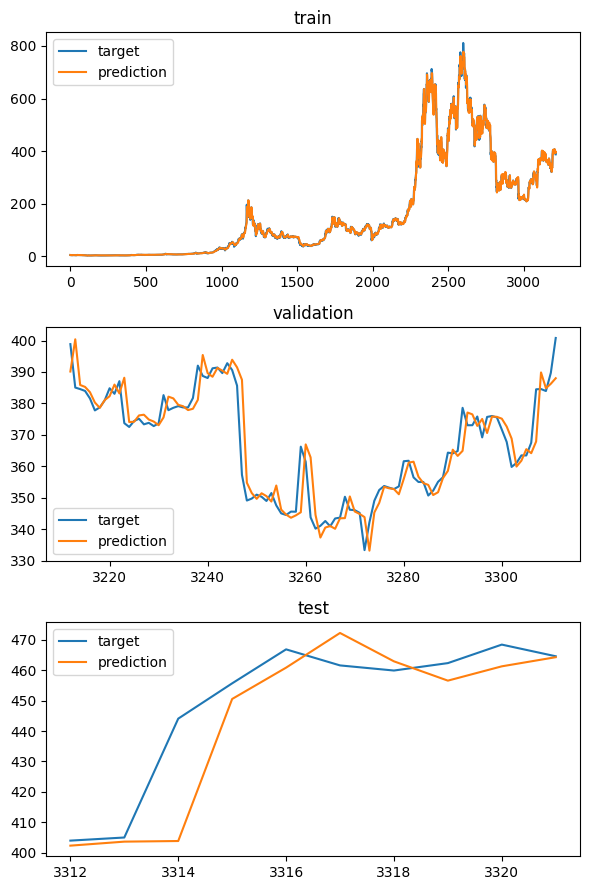

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


**최적의 설정**

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 464.29 <--> 459.89 (Loss:          4.40)
 1: 446.78 <--> 455.68 (Loss:          8.90)
 2: 401.62 <--> 404.00 (Loss:          2.38)
 3: 460.34 <--> 468.41 (Loss:          8.07)
 4: 458.66 <--> 462.33 (Loss:          3.67)
 5: 404.22 <--> 405.02 (Loss:          0.80)
 6: 458.55 <--> 466.85 (Loss:          8.29)
 7: 471.12 <--> 461.57 (Loss:          9.55)
 8: 464.56 <--> 464.58 (Loss:          0.02)
 9: 404.55 <--> 444.08 (Loss:         39.53)


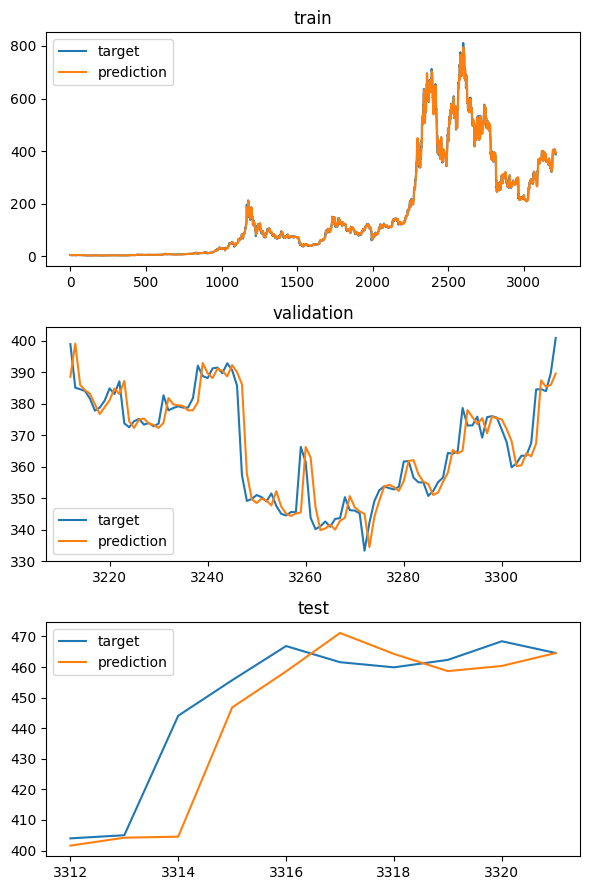

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


#### run - 도전 기록

###### run0

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 449.90 <--> 468.41 (Loss:         18.51)
 1: 457.31 <--> 464.58 (Loss:          7.27)
 2: 400.61 <--> 455.68 (Loss:         55.07)
 3: 424.40 <--> 461.57 (Loss:         37.18)
 4: 432.29 <--> 459.89 (Loss:         27.60)
 5: 441.46 <--> 462.33 (Loss:         20.87)
 6: 382.12 <--> 404.00 (Loss:         21.88)
 7: 386.90 <--> 405.02 (Loss:         18.12)
 8: 392.80 <--> 444.08 (Loss:         51.28)
 9: 412.62 <--> 466.85 (Loss:         54.23)


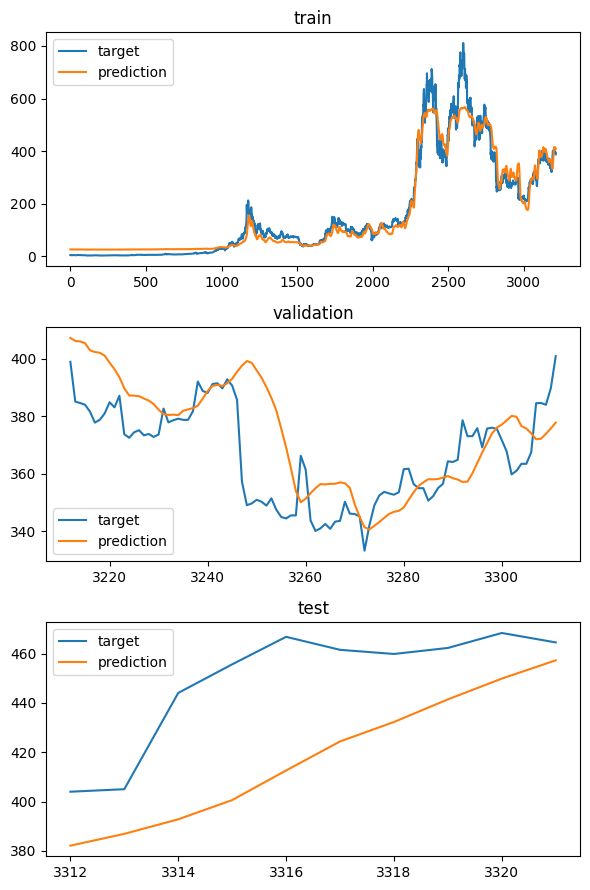

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run1

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 399.59 <--> 404.00 (Loss:          4.41)
 1: 444.02 <--> 455.68 (Loss:         11.66)
 2: 465.45 <--> 464.58 (Loss:          0.88)
 3: 458.87 <--> 462.33 (Loss:          3.46)
 4: 469.90 <--> 461.57 (Loss:          8.32)
 5: 460.77 <--> 466.85 (Loss:          6.08)
 6: 403.62 <--> 444.08 (Loss:         40.45)
 7: 403.01 <--> 405.02 (Loss:          2.01)
 8: 464.94 <--> 459.89 (Loss:          5.05)
 9: 461.46 <--> 468.41 (Loss:          6.95)


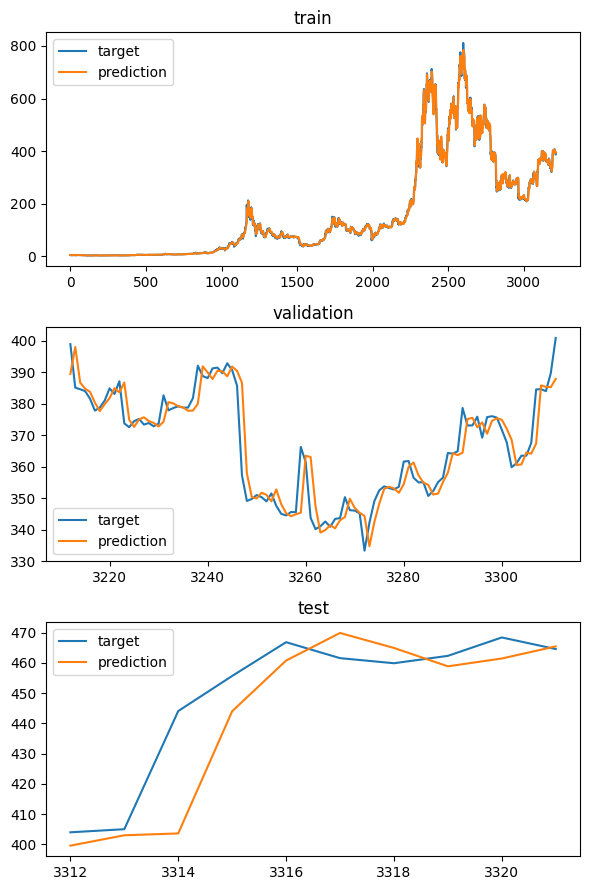

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run2

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 165.90 <--> 455.68 (Loss:        289.78)
 1: 185.42 <--> 464.58 (Loss:        279.16)
 2: 160.94 <--> 404.00 (Loss:        243.06)
 3: 162.15 <--> 405.02 (Loss:        242.87)
 4: 181.76 <--> 468.41 (Loss:        286.65)
 5: 169.43 <--> 466.85 (Loss:        297.41)
 6: 174.43 <--> 459.89 (Loss:        285.46)
 7: 164.23 <--> 444.08 (Loss:        279.85)
 8: 177.86 <--> 462.33 (Loss:        284.47)
 9: 173.17 <--> 461.57 (Loss:        288.41)


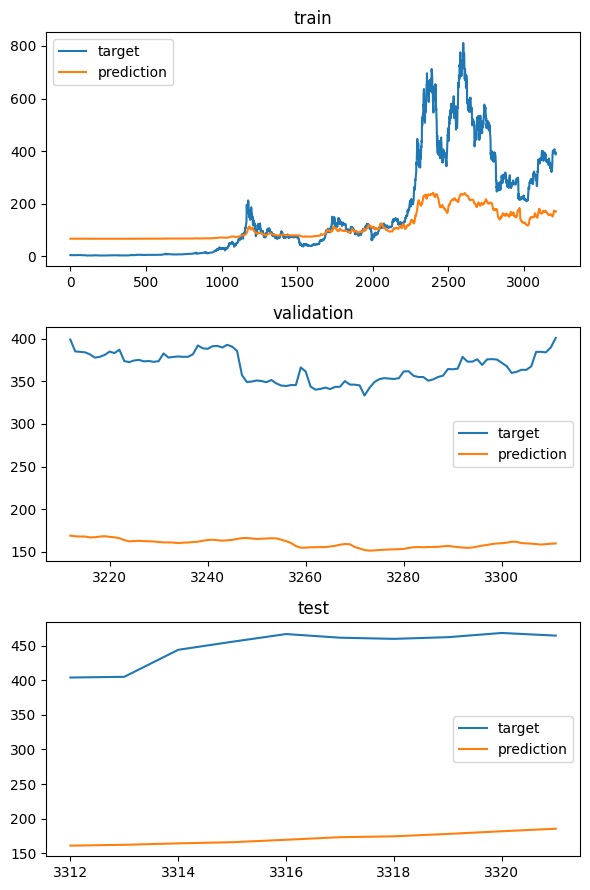

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run3

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 415.57 <--> 461.57 (Loss:         46.01)
 1: 383.81 <--> 405.02 (Loss:         21.21)
 2: 452.32 <--> 464.58 (Loss:         12.26)
 3: 395.43 <--> 455.68 (Loss:         60.25)
 4: 404.59 <--> 466.85 (Loss:         62.26)
 5: 444.88 <--> 468.41 (Loss:         23.53)
 6: 426.38 <--> 459.89 (Loss:         33.51)
 7: 436.25 <--> 462.33 (Loss:         26.08)
 8: 388.84 <--> 444.08 (Loss:         55.24)
 9: 379.06 <--> 404.00 (Loss:         24.94)


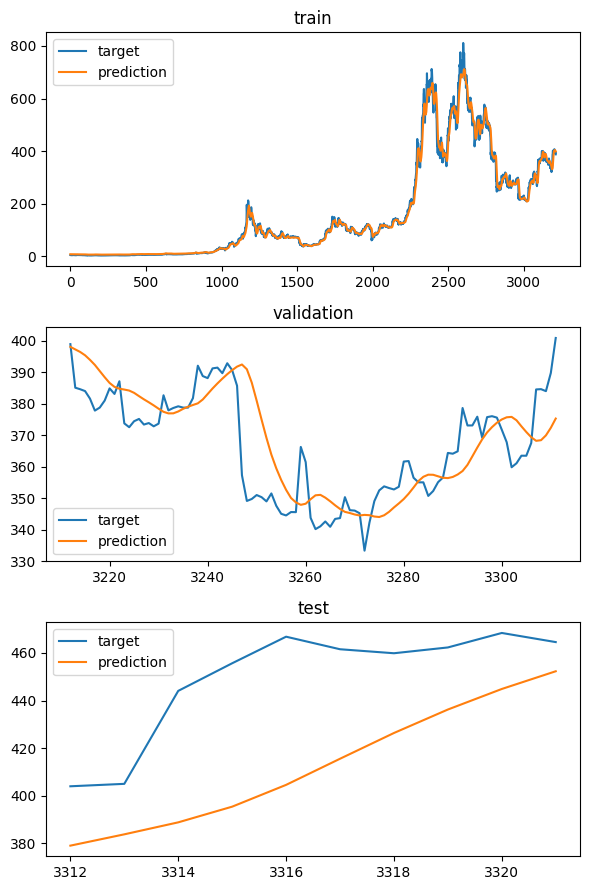

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run4

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 464.03 <--> 464.58 (Loss:          0.55)
 1: 463.47 <--> 459.89 (Loss:          3.58)
 2: 404.13 <--> 444.08 (Loss:         39.95)
 3: 469.88 <--> 461.57 (Loss:          8.31)
 4: 401.50 <--> 404.00 (Loss:          2.50)
 5: 457.57 <--> 462.33 (Loss:          4.76)
 6: 446.79 <--> 455.68 (Loss:          8.89)
 7: 459.89 <--> 468.41 (Loss:          8.52)
 8: 460.32 <--> 466.85 (Loss:          6.53)
 9: 403.96 <--> 405.02 (Loss:          1.06)


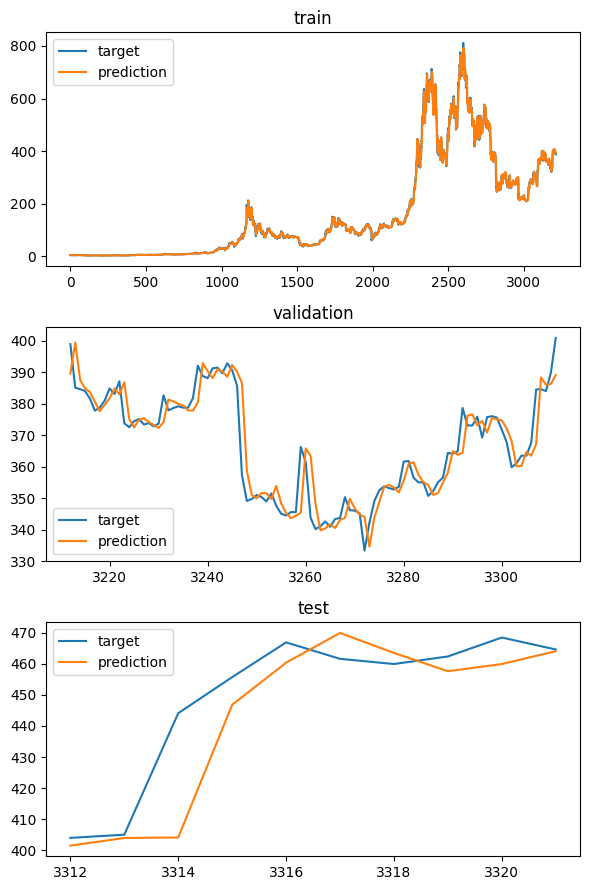

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run5

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 400.73 <--> 404.00 (Loss:          3.27)
 1: 404.48 <--> 405.02 (Loss:          0.54)
 2: 466.06 <--> 459.89 (Loss:          6.17)
 3: 469.27 <--> 461.57 (Loss:          7.69)
 4: 405.65 <--> 444.08 (Loss:         38.43)
 5: 462.17 <--> 462.33 (Loss:          0.16)
 6: 467.74 <--> 464.58 (Loss:          3.16)
 7: 442.93 <--> 455.68 (Loss:         12.75)
 8: 458.54 <--> 466.85 (Loss:          8.31)
 9: 462.95 <--> 468.41 (Loss:          5.46)


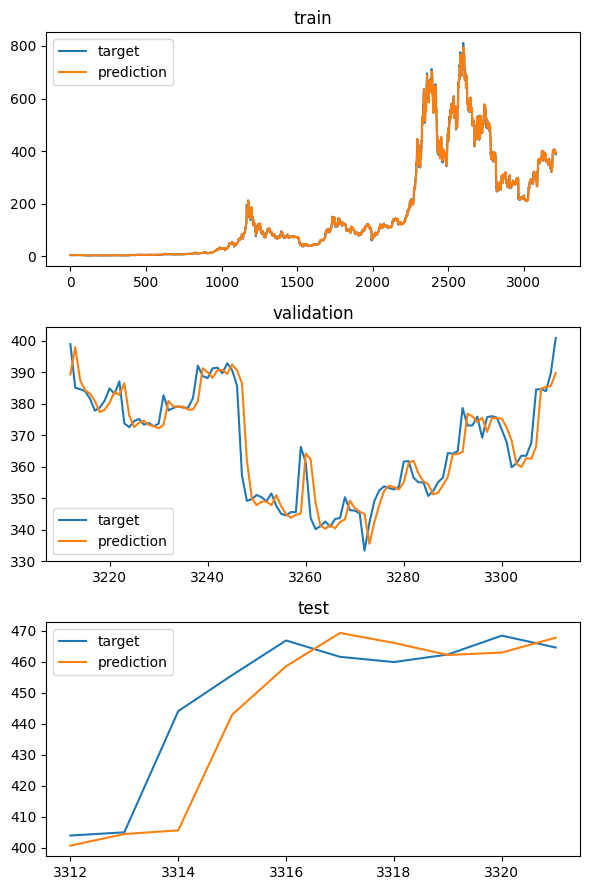

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run6

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 427.51 <--> 455.68 (Loss:         28.17)
 1: 464.15 <--> 461.57 (Loss:          2.58)
 2: 467.27 <--> 462.33 (Loss:          4.94)
 3: 402.47 <--> 405.02 (Loss:          2.55)
 4: 466.46 <--> 468.41 (Loss:          1.95)
 5: 468.00 <--> 464.58 (Loss:          3.42)
 6: 405.76 <--> 444.08 (Loss:         38.32)
 7: 448.22 <--> 466.85 (Loss:         18.63)
 8: 468.72 <--> 459.89 (Loss:          8.83)
 9: 396.31 <--> 404.00 (Loss:          7.68)


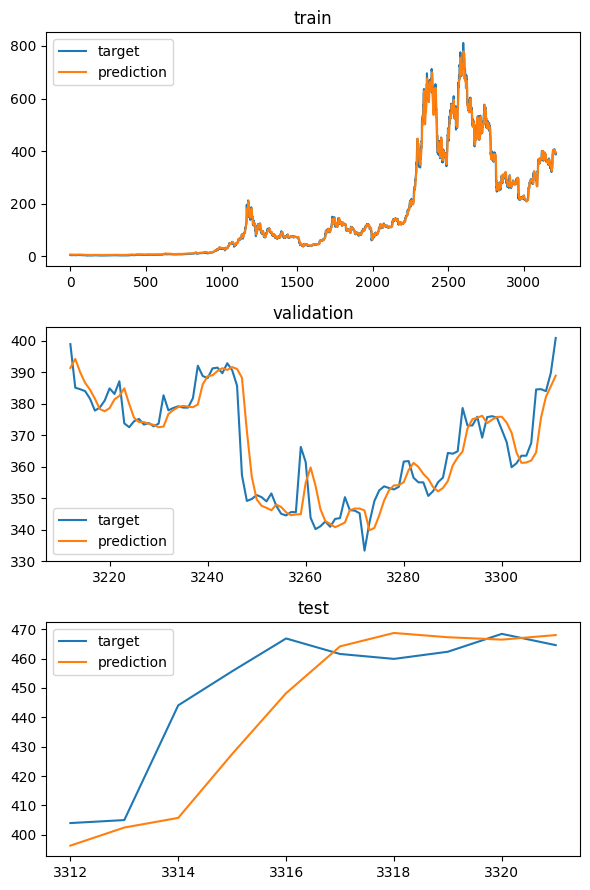

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run9

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 160.52 <--> 461.57 (Loss:        301.05)
 1: 160.52 <--> 466.85 (Loss:        306.32)
 2: 160.52 <--> 462.33 (Loss:        301.81)
 3: 160.52 <--> 404.00 (Loss:        243.47)
 4: 160.52 <--> 468.41 (Loss:        307.89)
 5: 160.52 <--> 464.58 (Loss:        304.06)
 6: 160.52 <--> 405.02 (Loss:        244.50)
 7: 160.52 <--> 459.89 (Loss:        299.37)
 8: 160.52 <--> 455.68 (Loss:        295.16)
 9: 160.52 <--> 444.08 (Loss:        283.56)


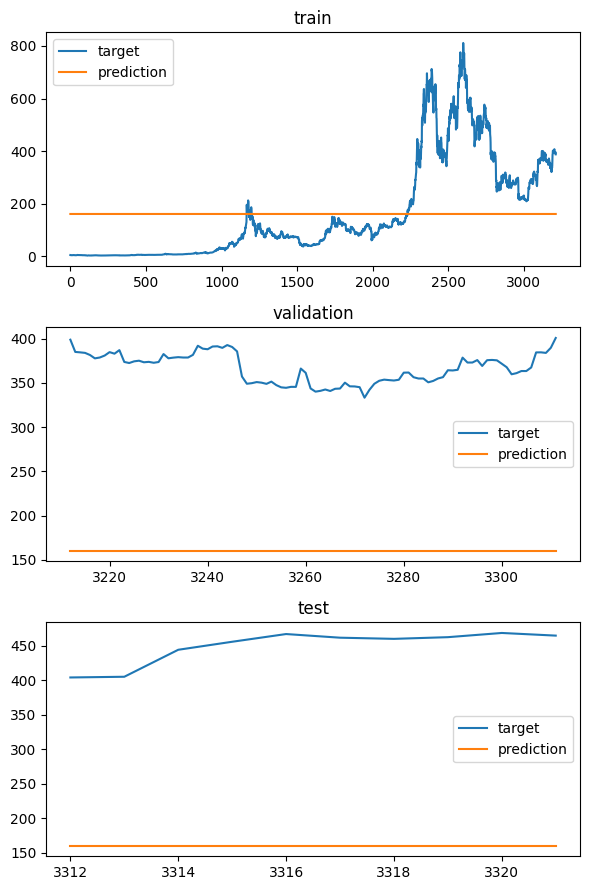

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run10

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 404.78 <--> 405.02 (Loss:          0.24)
 1: 447.40 <--> 455.68 (Loss:          8.28)
 2: 460.76 <--> 466.85 (Loss:          6.09)
 3: 463.88 <--> 459.89 (Loss:          3.99)
 4: 402.15 <--> 404.00 (Loss:          1.85)
 5: 404.35 <--> 444.08 (Loss:         39.73)
 6: 460.96 <--> 468.41 (Loss:          7.45)
 7: 471.81 <--> 461.57 (Loss:         10.23)
 8: 458.49 <--> 462.33 (Loss:          3.84)
 9: 464.99 <--> 464.58 (Loss:          0.41)


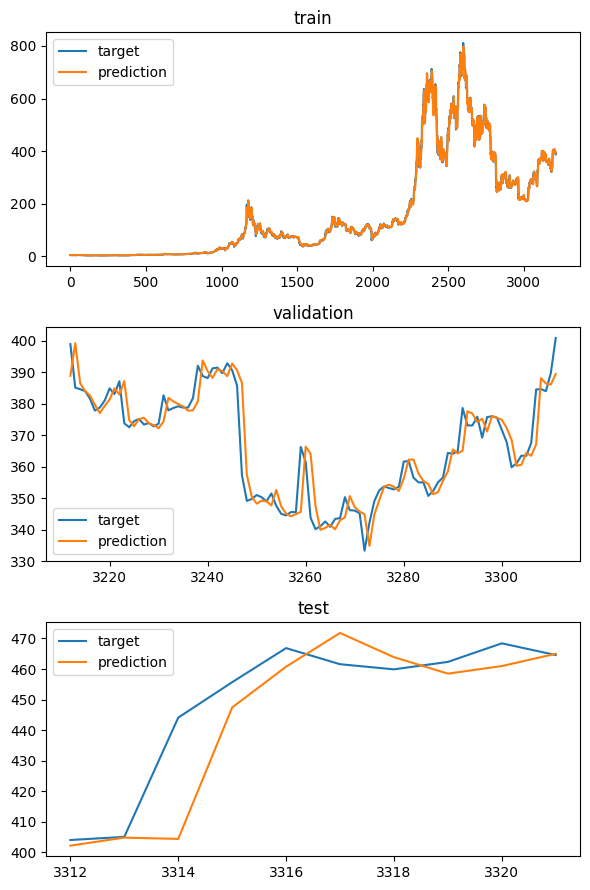

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run11

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 464.29 <--> 459.89 (Loss:          4.40)
 1: 446.78 <--> 455.68 (Loss:          8.90)
 2: 401.62 <--> 404.00 (Loss:          2.38)
 3: 460.34 <--> 468.41 (Loss:          8.07)
 4: 458.66 <--> 462.33 (Loss:          3.67)
 5: 404.22 <--> 405.02 (Loss:          0.80)
 6: 458.55 <--> 466.85 (Loss:          8.29)
 7: 471.12 <--> 461.57 (Loss:          9.55)
 8: 464.56 <--> 464.58 (Loss:          0.02)
 9: 404.55 <--> 444.08 (Loss:         39.53)


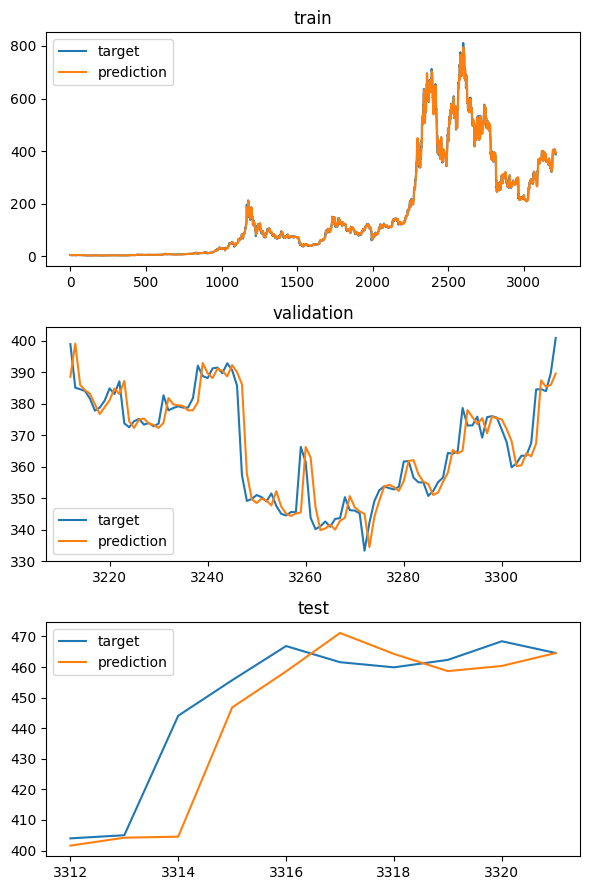

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


###### run12

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 461.12 <--> 466.85 (Loss:          5.72)
 1: 459.45 <--> 462.33 (Loss:          2.88)
 2: 460.84 <--> 468.41 (Loss:          7.57)
 3: 401.86 <--> 404.00 (Loss:          2.14)
 4: 404.61 <--> 444.08 (Loss:         39.47)
 5: 447.27 <--> 455.68 (Loss:          8.41)
 6: 465.11 <--> 464.58 (Loss:          0.54)
 7: 465.20 <--> 459.89 (Loss:          5.31)
 8: 471.89 <--> 461.57 (Loss:         10.32)
 9: 404.38 <--> 405.02 (Loss:          0.64)


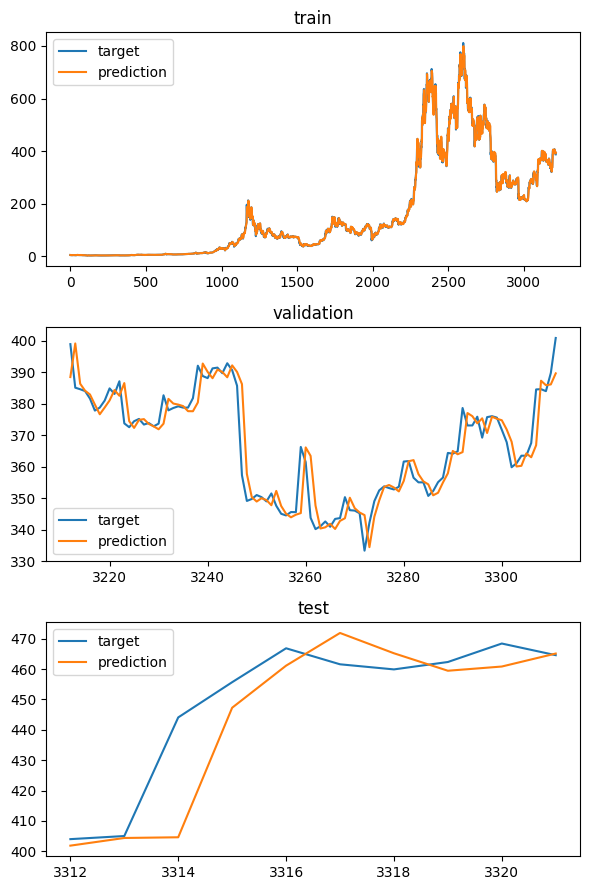

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


### _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

##### get_crytocurrency_data

In [2]:
def get_cryptocurrency_data(
    sequence_size=15, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=False
):
    # 파일 경로 설정
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
    if not os.path.exists(btc_krw_path):
        raise FileNotFoundError(f"CSV file not found at {btc_krw_path}")
    
    # CSV 파일 읽기
    df = pd.read_csv(btc_krw_path)

    # 데이터 타입 변환
    try:
        df = df.astype({col: 'float' for col in df.columns if col != 'Date'})
    except ValueError:
        raise ValueError("Some columns could not be converted to float. Check your CSV file.")

    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    # 데이터 크기 설정
    row_size = len(df)
    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    #################################################################################################

    # 데이터 분리
    def process_data(start_idx, end_idx):
        X_list = []
        y_regression_list = []
        y_classification_list = []
        y_date = []
        for idx in range(start_idx, end_idx):
            sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
            X_list.append(torch.from_numpy(sequence_data))
            y_regression_list.append(df.iloc[idx + sequence_size][target_column])
            y_classification_list.append(
                1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
            )
            y_date.append(date_list.iloc[idx + sequence_size])
        return X_list, y_regression_list, y_classification_list, y_date

    # 학습 데이터
    X_train_list, y_train_regression_list, y_train_classification_list, y_train_date = process_data(0, train_size)

    # 검증 데이터
    validation_start = train_size
    validation_end = validation_start + validation_size
    X_validation_list, y_validation_regression_list, y_validation_classification_list, y_validation_date = process_data(
        validation_start, validation_end
    )

    # 테스트 데이터
    test_start = validation_end
    test_end = test_start + test_size
    X_test_list, y_test_regression_list, y_test_classification_list, y_test_date = process_data(
        test_start, test_end
    )

    #################################################################################################

    # 텐서 변환 및 정규화
    def stack_and_normalize(X_list, y_regression_list, y_classification_list):
        X = torch.stack(X_list, dim=0).to(torch.float)
        m = X.mean(dim=0, keepdim=True)
        s = X.std(dim=0, unbiased=False, keepdim=True)
        X = (X - m) / s
        y_regression = torch.tensor(y_regression_list, dtype=torch.float32) / y_normalizer
        y_classification = torch.tensor(y_classification_list, dtype=torch.int64)
        return X, y_regression, y_classification

    X_train, y_train_regression, y_train_classification = stack_and_normalize(
        X_train_list, y_train_regression_list, y_train_classification_list
    )
    X_validation, y_validation_regression, y_validation_classification = stack_and_normalize(
        X_validation_list, y_validation_regression_list, y_validation_classification_list
    )
    X_test, y_test_regression, y_test_classification = stack_and_normalize(
        X_test_list, y_test_regression_list, y_test_classification_list
    )

    #################################################################################################

    # 반환
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


Classification	학습을 위한 데이터 관련 디폴트 설정 값을 다음과 같이 변경   
• sequence_size=15   
• validation_size=150   
• test_size=30   
• is_regression=False   

##### get_btc_krw_data

In [3]:
def get_btc_krw_data(sequence_size=15, validation_size=150, test_size=30, is_regression=False):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

##### ClassificationTrainer

In [4]:
class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


##### get_model

In [5]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      # 변경1 - LSTM layers 개수 (num_layers)
      # 변경4 - dropout rate (dropout)
      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True, dropout=0.1)
      # 변경2 - LSTM Layer 이후에 사용하는 Linear Layer 개수
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

##### main

In [6]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


##### run

**기존 설정**   
LSTM layers 개수: 3   
Linear Layer 개수: 1 (256,2)   
Weight decay 값: 0.0(default)   
Dropout rate 값: 0(default)

In [40]:
if __name__ == "__main__":
  args_str = "--wandb -p 100 -r 0.00001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69201, T_accuracy: 52.9295 | V_loss: 0.69192, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69116, T_accuracy: 52.9295 | V_loss: 0.69089, V_accuracy: 52.6667 | V_loss decreased (0.69192 --> 0.69089). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69040, T_accuracy: 53.0710 | V_loss: 0.68990, V_accuracy: 52.6667 | V_loss decreased (0.69089 --> 0.68990). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69105, T_accuracy: 53.1277 | V_loss: 0.68896, V_accuracy: 52.6667 | V_loss decreased (0.68990 --> 0.6889

[Epoch 1440] T_loss: 0.69039, T_accuracy: 53.1277 | V_loss: 0.68960, V_accuracy: 52.6667 | Early stopping counter: 44 out of 100 | T_time: 00:01:27, T_speed: 16.552
[Epoch 1470] T_loss: 0.69042, T_accuracy: 53.1277 | V_loss: 0.68956, V_accuracy: 52.6667 | Early stopping counter: 45 out of 100 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69065, T_accuracy: 53.1843 | V_loss: 0.68961, V_accuracy: 52.6667 | Early stopping counter: 46 out of 100 | T_time: 00:01:31, T_speed: 16.484
[Epoch 1530] T_loss: 0.69060, T_accuracy: 53.0710 | V_loss: 0.68955, V_accuracy: 52.6667 | Early stopping counter: 47 out of 100 | T_time: 00:01:33, T_speed: 16.452
[Epoch 1560] T_loss: 0.69010, T_accuracy: 53.0710 | V_loss: 0.68957, V_accuracy: 52.6667 | Early stopping counter: 48 out of 100 | T_time: 00:01:35, T_speed: 16.421
[Epoch 1590] T_loss: 0.69066, T_accuracy: 53.0427 | V_loss: 0.68955, V_accuracy: 52.6667 | Early stopping counter: 49 out of 100 | T_time: 00:01:37, T_speed: 16.392
[Epoch 162

[Epoch 2940] T_loss: 0.69030, T_accuracy: 53.6654 | V_loss: 0.68968, V_accuracy: 52.6667 | Early stopping counter: 94 out of 100 | T_time: 00:02:59, T_speed: 16.425
[Epoch 2970] T_loss: 0.69026, T_accuracy: 53.4956 | V_loss: 0.68972, V_accuracy: 52.6667 | Early stopping counter: 95 out of 100 | T_time: 00:03:01, T_speed: 16.409
[Epoch 3000] T_loss: 0.69029, T_accuracy: 53.3824 | V_loss: 0.68976, V_accuracy: 52.6667 | Early stopping counter: 96 out of 100 | T_time: 00:03:02, T_speed: 16.484
[Epoch 3030] T_loss: 0.69051, T_accuracy: 53.2126 | V_loss: 0.68980, V_accuracy: 52.6667 | Early stopping counter: 97 out of 100 | T_time: 00:03:04, T_speed: 16.467
[Epoch 3060] T_loss: 0.69010, T_accuracy: 53.2409 | V_loss: 0.68979, V_accuracy: 52.6667 | Early stopping counter: 98 out of 100 | T_time: 00:03:06, T_speed: 16.452
[Epoch 3090] T_loss: 0.68995, T_accuracy: 53.2975 | V_loss: 0.68994, V_accuracy: 52.6667 | Early stopping counter: 99 out of 100 | T_time: 00:03:08, T_speed: 16.436
[Epoch 312

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
Training accuracy (%),▁▃▃▄▃▃▂▄▃▃▁▃▁▃▃▃▃▃▂▁▄▄▄▄▆▄▄▃▄▂▅▅▆▄▆▆▂▄█▅
Training loss,▆▇▅▆▅█▆▃▃▄▆▃▃▄▂▄▇▂▆▃▅▅▄▅▄▄▅▄▁▅▄▁▄▃▇█▄▁▂▂
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▁▁▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
Epoch,3120
Training accuracy (%),53.01444
Training loss,0.68997
Training speed (epochs/sec.),16.42105
Validation accuracy (%),52.66667


**최적의 설정**   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.00001  
Dropout rate 값: 0.1

In [41]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.00001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=1e-05, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 1e-05}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69214, T_accuracy: 52.9295 | V_loss: 0.69220, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69121, T_accuracy: 52.9295 | V_loss: 0.69101, V_accuracy: 52.6667 | V_loss decreased (0.69220 --> 0.69101). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69110, T_accuracy: 52.9295 | V_loss: 0.69009, V_accuracy: 52.6667 | V_loss decreased (0.69101 --> 0.69009). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69067, T_accuracy: 52.9012 | V_loss: 0.68921, V_accuracy: 52.6667 | V_loss decreased (0.69009 --> 0.

[Epoch 1440] T_loss: 0.69079, T_accuracy: 53.0427 | V_loss: 0.68978, V_accuracy: 52.6667 | Early stopping counter: 43 out of 100 | T_time: 00:01:28, T_speed: 16.364
[Epoch 1470] T_loss: 0.69058, T_accuracy: 53.2126 | V_loss: 0.68972, V_accuracy: 52.6667 | Early stopping counter: 44 out of 100 | T_time: 00:01:30, T_speed: 16.333
[Epoch 1500] T_loss: 0.69051, T_accuracy: 53.0993 | V_loss: 0.68975, V_accuracy: 52.6667 | Early stopping counter: 45 out of 100 | T_time: 00:01:32, T_speed: 16.304
[Epoch 1530] T_loss: 0.69040, T_accuracy: 53.0993 | V_loss: 0.68972, V_accuracy: 52.6667 | Early stopping counter: 46 out of 100 | T_time: 00:01:33, T_speed: 16.452
[Epoch 1560] T_loss: 0.69046, T_accuracy: 53.1277 | V_loss: 0.68964, V_accuracy: 52.6667 | Early stopping counter: 47 out of 100 | T_time: 00:01:35, T_speed: 16.421
[Epoch 1590] T_loss: 0.69048, T_accuracy: 53.0427 | V_loss: 0.68968, V_accuracy: 52.6667 | Early stopping counter: 48 out of 100 | T_time: 00:01:37, T_speed: 16.392
[Epoch 162

[Epoch 2940] T_loss: 0.69070, T_accuracy: 52.9861 | V_loss: 0.68975, V_accuracy: 52.6667 | Early stopping counter: 93 out of 100 | T_time: 00:03:00, T_speed: 16.333
[Epoch 2970] T_loss: 0.69057, T_accuracy: 53.0993 | V_loss: 0.68976, V_accuracy: 52.6667 | Early stopping counter: 94 out of 100 | T_time: 00:03:01, T_speed: 16.409
[Epoch 3000] T_loss: 0.69050, T_accuracy: 53.0993 | V_loss: 0.68974, V_accuracy: 52.6667 | Early stopping counter: 95 out of 100 | T_time: 00:03:03, T_speed: 16.393
[Epoch 3030] T_loss: 0.69057, T_accuracy: 53.2126 | V_loss: 0.68978, V_accuracy: 52.6667 | Early stopping counter: 96 out of 100 | T_time: 00:03:05, T_speed: 16.378
[Epoch 3060] T_loss: 0.69075, T_accuracy: 53.0993 | V_loss: 0.68970, V_accuracy: 52.6667 | Early stopping counter: 97 out of 100 | T_time: 00:03:07, T_speed: 16.364
[Epoch 3090] T_loss: 0.69045, T_accuracy: 53.0993 | V_loss: 0.68967, V_accuracy: 52.6667 | Early stopping counter: 98 out of 100 | T_time: 00:03:09, T_speed: 16.349
[Epoch 312

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
Training accuracy (%),▁▆██▇▅▄▂▄▅▃▂▄▃▃▃▄▅▄▃▁▅▄▂▁▄▄▄▄▂▄▅▃▂▃▃▃▄▅▃
Training loss,█▃▅▂▅▅▂▄▅▅▃▃▄▅▃▃█▅▄▄▄▃▃▄▄▄▄▄▂▆▄▄▃▅▆▆▅▅▄▁
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▅▂▁▂▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████▇████████▇
Epoch,3150
Training accuracy (%),53.04274
Training loss,0.69009
Training speed (epochs/sec.),16.32124
Validation accuracy (%),52.66667


##### run - 도전 기록

###### run0

In [42]:
if __name__ == "__main__":
  args_str = "--wandb -p 100 -r 0.00001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69397, T_accuracy: 47.0705 | V_loss: 0.69386, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69203, T_accuracy: 52.9012 | V_loss: 0.69169, V_accuracy: 52.6667 | V_loss decreased (0.69386 --> 0.69169). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69103, T_accuracy: 52.8729 | V_loss: 0.69010, V_accuracy: 52.6667 | V_loss decreased (0.69169 --> 0.69010). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69060, T_accuracy: 53.0427 | V_loss: 0.68892, V_accuracy: 52.6667 | V_loss decreased (0.69010 --> 0.6889

[Epoch 1440] T_loss: 0.69066, T_accuracy: 53.2409 | V_loss: 0.68963, V_accuracy: 52.6667 | Early stopping counter: 43 out of 100 | T_time: 00:01:27, T_speed: 16.552
[Epoch 1470] T_loss: 0.69045, T_accuracy: 53.1277 | V_loss: 0.68961, V_accuracy: 52.6667 | Early stopping counter: 44 out of 100 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69056, T_accuracy: 52.9578 | V_loss: 0.68960, V_accuracy: 52.6667 | Early stopping counter: 45 out of 100 | T_time: 00:01:31, T_speed: 16.484
[Epoch 1530] T_loss: 0.69068, T_accuracy: 53.0710 | V_loss: 0.68962, V_accuracy: 52.6667 | Early stopping counter: 46 out of 100 | T_time: 00:01:33, T_speed: 16.452
[Epoch 1560] T_loss: 0.69042, T_accuracy: 53.0710 | V_loss: 0.68964, V_accuracy: 52.6667 | Early stopping counter: 47 out of 100 | T_time: 00:01:34, T_speed: 16.596
[Epoch 1590] T_loss: 0.69065, T_accuracy: 53.1843 | V_loss: 0.68962, V_accuracy: 52.6667 | Early stopping counter: 48 out of 100 | T_time: 00:01:36, T_speed: 16.562
[Epoch 162

[Epoch 2940] T_loss: 0.69066, T_accuracy: 53.3541 | V_loss: 0.68953, V_accuracy: 52.6667 | Early stopping counter: 93 out of 100 | T_time: 00:02:57, T_speed: 16.610
[Epoch 2970] T_loss: 0.69065, T_accuracy: 53.3258 | V_loss: 0.68958, V_accuracy: 52.6667 | Early stopping counter: 94 out of 100 | T_time: 00:02:59, T_speed: 16.592
[Epoch 3000] T_loss: 0.69016, T_accuracy: 53.0993 | V_loss: 0.68961, V_accuracy: 52.6667 | Early stopping counter: 95 out of 100 | T_time: 00:03:01, T_speed: 16.575
[Epoch 3030] T_loss: 0.69065, T_accuracy: 53.1277 | V_loss: 0.68958, V_accuracy: 52.6667 | Early stopping counter: 96 out of 100 | T_time: 00:03:03, T_speed: 16.557
[Epoch 3060] T_loss: 0.69038, T_accuracy: 53.1843 | V_loss: 0.68958, V_accuracy: 52.6667 | Early stopping counter: 97 out of 100 | T_time: 00:03:04, T_speed: 16.630
[Epoch 3090] T_loss: 0.69077, T_accuracy: 53.2692 | V_loss: 0.68959, V_accuracy: 52.6667 | Early stopping counter: 98 out of 100 | T_time: 00:03:06, T_speed: 16.613
[Epoch 312

Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
Training accuracy (%),▁▁▆▃▆▅▅▅▅▄▄▄▅▂▅▅▃▅▃▅▃▆▂▅▆▄▆▇▅▅▆▆▇█▇█▇▅▆█
Training loss,█▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂
Training speed (epochs/sec.),▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁███████████████████████████████████████
Validation loss,█▁▁▂▂▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Epoch,3150
Training accuracy (%),53.35409
Training loss,0.69069
Training speed (epochs/sec.),16.57895
Validation accuracy (%),52.66667


###### run1   
LSTM layers 개수: 4   
Linear Layer 개수: 4(256,256)(256,256)(256,128)(128,output)   
Weight decay 값: 0.001   
Dropout rate 값: 0.2

In [43]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.001, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69903, T_accuracy: 47.0705 | V_loss: 0.69842, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69648, T_accuracy: 47.0705 | V_loss: 0.69633, V_accuracy: 47.3333 | V_loss decreased (0.69842 --> 0.69633). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69490, T_accuracy: 47.0705 | V_loss: 0.69473, V_accuracy: 47.3333 | V_loss decreased (0.69633 --> 0.69473). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69368, T_accuracy: 47.0705 | V_loss: 0.69351, V_accuracy: 47.3333 | V_loss decreased (0.69473 --> 0.

[Epoch 1350] T_loss: 0.69083, T_accuracy: 53.1277 | V_loss: 0.68950, V_accuracy: 52.6667 | V_loss decreased (0.68950 --> 0.68950). Saving model... | T_time: 00:01:24, T_speed: 16.071
[Epoch 1380] T_loss: 0.69081, T_accuracy: 52.9578 | V_loss: 0.68948, V_accuracy: 52.6667 | V_loss decreased (0.68950 --> 0.68948). Saving model... | T_time: 00:01:26, T_speed: 16.047
[Epoch 1410] T_loss: 0.69098, T_accuracy: 53.0144 | V_loss: 0.68948, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:01:27, T_speed: 16.207
[Epoch 1440] T_loss: 0.69071, T_accuracy: 52.9578 | V_loss: 0.68947, V_accuracy: 52.6667 | V_loss decreased (0.68948 --> 0.68947). Saving model... | T_time: 00:01:29, T_speed: 16.180
[Epoch 1470] T_loss: 0.69029, T_accuracy: 52.9578 | V_loss: 0.68946, V_accuracy: 52.6667 | V_loss decreased (0.68947 --> 0.68946). Saving model... | T_time: 00:01:31, T_speed: 16.154
[Epoch 1500] T_loss: 0.69061, T_accuracy: 53.0427 | V_loss: 0.68946, V_accuracy: 52.6667 | V_loss decrea

[Epoch 2820] T_loss: 0.69071, T_accuracy: 53.1277 | V_loss: 0.68943, V_accuracy: 52.6667 | Early stopping counter: 9 out of 100 | T_time: 00:02:54, T_speed: 16.207
[Epoch 2850] T_loss: 0.69060, T_accuracy: 52.9861 | V_loss: 0.68943, V_accuracy: 52.6667 | Early stopping counter: 10 out of 100 | T_time: 00:02:56, T_speed: 16.193
[Epoch 2880] T_loss: 0.69075, T_accuracy: 53.0427 | V_loss: 0.68941, V_accuracy: 52.6667 | V_loss decreased (0.68943 --> 0.68941). Saving model... | T_time: 00:02:58, T_speed: 16.180
[Epoch 2910] T_loss: 0.69103, T_accuracy: 53.2692 | V_loss: 0.68940, V_accuracy: 52.6667 | V_loss decreased (0.68941 --> 0.68940). Saving model... | T_time: 00:03:00, T_speed: 16.167
[Epoch 2940] T_loss: 0.69074, T_accuracy: 53.0144 | V_loss: 0.68943, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:03:02, T_speed: 16.154
[Epoch 2970] T_loss: 0.69069, T_accuracy: 53.1843 | V_loss: 0.68942, V_accuracy: 52.6667 | Early stopping counter: 2 out of 100 | T_time: 00:

[Epoch 4320] T_loss: 0.69062, T_accuracy: 53.2409 | V_loss: 0.68938, V_accuracy: 52.6667 | Early stopping counter: 2 out of 100 | T_time: 00:04:26, T_speed: 16.241
[Epoch 4350] T_loss: 0.69088, T_accuracy: 53.1843 | V_loss: 0.68935, V_accuracy: 52.6667 | Early stopping counter: 3 out of 100 | T_time: 00:04:28, T_speed: 16.231
[Epoch 4380] T_loss: 0.69065, T_accuracy: 53.2126 | V_loss: 0.68936, V_accuracy: 52.6667 | Early stopping counter: 4 out of 100 | T_time: 00:04:30, T_speed: 16.222
[Epoch 4410] T_loss: 0.69070, T_accuracy: 52.9861 | V_loss: 0.68935, V_accuracy: 52.6667 | Early stopping counter: 5 out of 100 | T_time: 00:04:32, T_speed: 16.213
[Epoch 4440] T_loss: 0.69067, T_accuracy: 53.1560 | V_loss: 0.68934, V_accuracy: 52.6667 | V_loss decreased (0.68934 --> 0.68934). Saving model... | T_time: 00:04:34, T_speed: 16.204
[Epoch 4470] T_loss: 0.69070, T_accuracy: 53.1843 | V_loss: 0.68936, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:04:36, T_speed: 16.1

[Epoch 5820] T_loss: 0.69083, T_accuracy: 53.1560 | V_loss: 0.68943, V_accuracy: 52.6667 | Early stopping counter: 46 out of 100 | T_time: 00:05:58, T_speed: 16.257
[Epoch 5850] T_loss: 0.69077, T_accuracy: 53.1277 | V_loss: 0.68941, V_accuracy: 52.6667 | Early stopping counter: 47 out of 100 | T_time: 00:06:00, T_speed: 16.250
[Epoch 5880] T_loss: 0.69098, T_accuracy: 53.0144 | V_loss: 0.68941, V_accuracy: 52.6667 | Early stopping counter: 48 out of 100 | T_time: 00:06:02, T_speed: 16.243
[Epoch 5910] T_loss: 0.69065, T_accuracy: 53.2126 | V_loss: 0.68938, V_accuracy: 52.6667 | Early stopping counter: 49 out of 100 | T_time: 00:06:04, T_speed: 16.236
[Epoch 5940] T_loss: 0.69062, T_accuracy: 53.1277 | V_loss: 0.68939, V_accuracy: 52.6667 | Early stopping counter: 50 out of 100 | T_time: 00:06:06, T_speed: 16.230
[Epoch 5970] T_loss: 0.69082, T_accuracy: 53.1843 | V_loss: 0.68937, V_accuracy: 52.6667 | Early stopping counter: 51 out of 100 | T_time: 00:06:07, T_speed: 16.267
[Epoch 600

[Epoch 7320] T_loss: 0.69061, T_accuracy: 53.2692 | V_loss: 0.68939, V_accuracy: 52.6667 | Early stopping counter: 33 out of 100 | T_time: 00:07:30, T_speed: 16.267
[Epoch 7350] T_loss: 0.69056, T_accuracy: 53.0710 | V_loss: 0.68936, V_accuracy: 52.6667 | Early stopping counter: 34 out of 100 | T_time: 00:07:32, T_speed: 16.261
[Epoch 7380] T_loss: 0.69049, T_accuracy: 53.2126 | V_loss: 0.68935, V_accuracy: 52.6667 | Early stopping counter: 35 out of 100 | T_time: 00:07:33, T_speed: 16.291
[Epoch 7410] T_loss: 0.69071, T_accuracy: 53.1277 | V_loss: 0.68938, V_accuracy: 52.6667 | Early stopping counter: 36 out of 100 | T_time: 00:07:35, T_speed: 16.286
[Epoch 7440] T_loss: 0.69070, T_accuracy: 53.0993 | V_loss: 0.68940, V_accuracy: 52.6667 | Early stopping counter: 37 out of 100 | T_time: 00:07:37, T_speed: 16.280
[Epoch 7470] T_loss: 0.69057, T_accuracy: 53.0993 | V_loss: 0.68940, V_accuracy: 52.6667 | Early stopping counter: 38 out of 100 | T_time: 00:07:39, T_speed: 16.275
[Epoch 750

[Epoch 8820] T_loss: 0.69105, T_accuracy: 53.2126 | V_loss: 0.68938, V_accuracy: 52.6667 | Early stopping counter: 83 out of 100 | T_time: 00:09:02, T_speed: 16.273
[Epoch 8850] T_loss: 0.69095, T_accuracy: 53.2126 | V_loss: 0.68940, V_accuracy: 52.6667 | Early stopping counter: 84 out of 100 | T_time: 00:09:04, T_speed: 16.268
[Epoch 8880] T_loss: 0.69085, T_accuracy: 53.1560 | V_loss: 0.68936, V_accuracy: 52.6667 | Early stopping counter: 85 out of 100 | T_time: 00:09:06, T_speed: 16.264
[Epoch 8910] T_loss: 0.69066, T_accuracy: 53.2692 | V_loss: 0.68933, V_accuracy: 52.6667 | Early stopping counter: 86 out of 100 | T_time: 00:09:07, T_speed: 16.289
[Epoch 8940] T_loss: 0.69050, T_accuracy: 53.1277 | V_loss: 0.68936, V_accuracy: 52.6667 | Early stopping counter: 87 out of 100 | T_time: 00:09:09, T_speed: 16.284
[Epoch 8970] T_loss: 0.69087, T_accuracy: 53.0710 | V_loss: 0.68936, V_accuracy: 52.6667 | Early stopping counter: 88 out of 100 | T_time: 00:09:11, T_speed: 16.279
[Epoch 900

Epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇█████
Training accuracy (%),▁▇▇█████████████████████████████████████
Training loss,█▆▂▂▂▂▂▂▁▂▁▁▂▁▂▂▂▁▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▂▂▂▂▁▁▁
Training speed (epochs/sec.),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9330
Training accuracy (%),53.15596
Training loss,0.69062
Training speed (epochs/sec.),16.28272
Validation accuracy (%),52.66667


###### run2   
LSTM layers 개수: 4   
Linear Layer 개수: 2(256,256)(256,output)   
Weight decay 값: 0.0005   
Dropout rate 값: 0.15

In [44]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.0005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0005, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69312, T_accuracy: 51.4577 | V_loss: 0.69306, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69203, T_accuracy: 52.9295 | V_loss: 0.69195, V_accuracy: 52.6667 | V_loss decreased (0.69306 --> 0.69195). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69161, T_accuracy: 52.9295 | V_loss: 0.69134, V_accuracy: 52.6667 | V_loss decreased (0.69195 --> 0.69134). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69105, T_accuracy: 52.9295 | V_loss: 0.69096, V_accuracy: 52.6667 | V_loss decreased (0.69134 --> 

[Epoch 1350] T_loss: 0.69069, T_accuracy: 53.0993 | V_loss: 0.68906, V_accuracy: 52.6667 | Early stopping counter: 12 out of 100 | T_time: 00:01:22, T_speed: 16.463
[Epoch 1380] T_loss: 0.69079, T_accuracy: 53.1560 | V_loss: 0.68908, V_accuracy: 52.6667 | Early stopping counter: 13 out of 100 | T_time: 00:01:24, T_speed: 16.429
[Epoch 1410] T_loss: 0.69041, T_accuracy: 53.0427 | V_loss: 0.68908, V_accuracy: 52.6667 | Early stopping counter: 14 out of 100 | T_time: 00:01:26, T_speed: 16.395
[Epoch 1440] T_loss: 0.69078, T_accuracy: 53.0993 | V_loss: 0.68907, V_accuracy: 52.6667 | Early stopping counter: 15 out of 100 | T_time: 00:01:27, T_speed: 16.552
[Epoch 1470] T_loss: 0.69087, T_accuracy: 53.2126 | V_loss: 0.68908, V_accuracy: 52.6667 | Early stopping counter: 16 out of 100 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69058, T_accuracy: 53.1277 | V_loss: 0.68906, V_accuracy: 52.6667 | Early stopping counter: 17 out of 100 | T_time: 00:01:31, T_speed: 16.484
[Epoch 153

[Epoch 2850] T_loss: 0.69076, T_accuracy: 53.4107 | V_loss: 0.68911, V_accuracy: 52.6667 | Early stopping counter: 62 out of 100 | T_time: 00:02:53, T_speed: 16.474
[Epoch 2880] T_loss: 0.69077, T_accuracy: 53.1560 | V_loss: 0.68911, V_accuracy: 52.6667 | Early stopping counter: 63 out of 100 | T_time: 00:02:55, T_speed: 16.457
[Epoch 2910] T_loss: 0.69038, T_accuracy: 53.0710 | V_loss: 0.68909, V_accuracy: 52.6667 | Early stopping counter: 64 out of 100 | T_time: 00:02:57, T_speed: 16.441
[Epoch 2940] T_loss: 0.69077, T_accuracy: 53.2126 | V_loss: 0.68909, V_accuracy: 52.6667 | Early stopping counter: 65 out of 100 | T_time: 00:02:59, T_speed: 16.425
[Epoch 2970] T_loss: 0.69075, T_accuracy: 53.1277 | V_loss: 0.68910, V_accuracy: 52.6667 | Early stopping counter: 66 out of 100 | T_time: 00:03:01, T_speed: 16.409
[Epoch 3000] T_loss: 0.69065, T_accuracy: 53.1277 | V_loss: 0.68910, V_accuracy: 52.6667 | Early stopping counter: 67 out of 100 | T_time: 00:03:03, T_speed: 16.393
[Epoch 303

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Training accuracy (%),▂▂▁▁▃██▇▅▆▄▇▅▆▇▆▅▆▆▅▆▆▆▄▆▆▆▄▅▄▆█▅▇▇▇▇▇▆▇
Training loss,█▃▃▂▂▂▁▁▂▁▂▃▁▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▂▁▂▂▁▂▁▂▂
Training speed (epochs/sec.),█▆█▅▅▃▁▁▂▂▁▂▁▁▂▁▂▁▂▂▂▂▂▂▃▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3990
Training accuracy (%),53.18426
Training loss,0.69041
Training speed (epochs/sec.),16.41975
Validation accuracy (%),52.66667


###### run3   
LSTM layers 개수: 3   
Linear Layer 개수: 2 (256,256)(256,output)   
Weight decay 값: 0.5   
Dropout rate 값: 0.1

In [45]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.5"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.5, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.5}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69137, T_accuracy: 52.9295 | V_loss: 0.69151, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69139, T_accuracy: 52.9295 | V_loss: 0.69151, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69133, T_accuracy: 52.9295 | V_loss: 0.69152, V_accuracy: 52.6667 | Early stopping counter: 2 out of 100 | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69158, T_accuracy: 52.9295 | V_loss: 0.69152, V_accuracy: 52.6667 | Early stopping counter: 3 out of 100 | T_time: 00:00:05, T_speed: 18.000
[

[Epoch 1440] T_loss: 0.69161, T_accuracy: 52.9295 | V_loss: 0.69192, V_accuracy: 52.6667 | Early stopping counter: 48 out of 100 | T_time: 00:01:27, T_speed: 16.552
[Epoch 1470] T_loss: 0.69168, T_accuracy: 52.9295 | V_loss: 0.69192, V_accuracy: 52.6667 | Early stopping counter: 49 out of 100 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69180, T_accuracy: 52.9295 | V_loss: 0.69193, V_accuracy: 52.6667 | Early stopping counter: 50 out of 100 | T_time: 00:01:30, T_speed: 16.667
[Epoch 1530] T_loss: 0.69173, T_accuracy: 52.9295 | V_loss: 0.69193, V_accuracy: 52.6667 | Early stopping counter: 51 out of 100 | T_time: 00:01:32, T_speed: 16.630
[Epoch 1560] T_loss: 0.69165, T_accuracy: 52.9295 | V_loss: 0.69194, V_accuracy: 52.6667 | Early stopping counter: 52 out of 100 | T_time: 00:01:34, T_speed: 16.596
[Epoch 1590] T_loss: 0.69181, T_accuracy: 52.9295 | V_loss: 0.69194, V_accuracy: 52.6667 | Early stopping counter: 53 out of 100 | T_time: 00:01:36, T_speed: 16.562
[Epoch 162

[Epoch 2940] T_loss: 0.69179, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 98 out of 100 | T_time: 00:02:58, T_speed: 16.517
[Epoch 2970] T_loss: 0.69181, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 99 out of 100 | T_time: 00:03:00, T_speed: 16.500
[Epoch 3000] T_loss: 0.69201, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 100 out of 100 *** TRAIN EARLY STOPPED! *** | T_time: 00:03:02, T_speed: 16.484
Final training time: 00:03:02


Epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,▃▃▁▃▁▄▃▃▃▄▅▄▆▅▅▅▅▅▆▆▅▆▆▆▆▆▅▇▆▆▇▆▇▇▇██▆▇█
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▁▁▂▂▂▃▃▃▃▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███████████████
Epoch,3000
Training accuracy (%),52.92952
Training loss,0.69201
Training speed (epochs/sec.),16.48352
Validation accuracy (%),52.66667


###### run4   
LSTM layers 개수: 3   
Linear Layer 개수: 2 (256,256)(256,output)   
Weight decay 값: 0.01   
Dropout rate 값: 0.1
   
learning rate: 1e-10

In [46]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 1e-10 -w 0.5"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-10, weight_decay=0.5, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-10, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.5}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69441, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69439, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 1 out of 100 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69436, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 2 out of 100 | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69437, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 3 out of 100 | T_time: 00:00:05, T_speed: 18.000
[

[Epoch 1440] T_loss: 0.69431, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 48 out of 100 | T_time: 00:01:27, T_speed: 16.552
[Epoch 1470] T_loss: 0.69431, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 49 out of 100 | T_time: 00:01:28, T_speed: 16.705
[Epoch 1500] T_loss: 0.69448, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 50 out of 100 | T_time: 00:01:30, T_speed: 16.667
[Epoch 1530] T_loss: 0.69434, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 51 out of 100 | T_time: 00:01:32, T_speed: 16.630
[Epoch 1560] T_loss: 0.69449, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 52 out of 100 | T_time: 00:01:34, T_speed: 16.596
[Epoch 1590] T_loss: 0.69434, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 53 out of 100 | T_time: 00:01:36, T_speed: 16.562
[Epoch 162

[Epoch 2940] T_loss: 0.69441, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 98 out of 100 | T_time: 00:02:58, T_speed: 16.517
[Epoch 2970] T_loss: 0.69443, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 99 out of 100 | T_time: 00:03:00, T_speed: 16.500
[Epoch 3000] T_loss: 0.69439, T_accuracy: 47.0705 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 100 out of 100 *** TRAIN EARLY STOPPED! *** | T_time: 00:03:01, T_speed: 16.575
Final training time: 00:03:01


Epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇██
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,▄▄▁█▃▁▄▇▆▅▅▂▃▅▄▆▂█▃▅▆▃▄▇▃▆▅▆▆▆▄▆▄▁▅▅▄▁▅▅
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▃▁▆▆▃▆▆▃▆▃▆▆██▆▃▆▃▆▃▁▆█▆▆▃▃▁▆▃▃▃█▃▆▆▆▆▆▁
Epoch,3000
Training accuracy (%),47.07048
Training loss,0.69439
Training speed (epochs/sec.),16.57459
Validation accuracy (%),47.33333


###### run5   
LSTM layers 개수: 3   
Linear Layer 개수: 2 (256,256)(256,output)   
Weight decay 값: 0.01   
Dropout rate 값: 0.1

In [47]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.001 -w 0.5"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.001, weight_decay=0.5, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.001, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.5}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69595, T_accuracy: 47.0705 | V_loss: 0.69545, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69225, T_accuracy: 52.9295 | V_loss: 0.69237, V_accuracy: 52.6667 | V_loss decreased (0.69545 --> 0.69237). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69191, T_accuracy: 52.9295 | V_loss: 0.69209, V_accuracy: 52.6667 | V_loss decreased (0.69237 --> 0.69209). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69191, T_accuracy: 52.9295 | V_loss: 0.69203, V_accuracy: 52.6667 | V_loss decreased (0.69209 --> 0.6920

[Epoch 1440] T_loss: 0.69192, T_accuracy: 52.9295 | V_loss: 0.69200, V_accuracy: 52.6667 | Early stopping counter: 42 out of 100 | T_time: 00:01:26, T_speed: 16.744
[Epoch 1470] T_loss: 0.69199, T_accuracy: 52.9295 | V_loss: 0.69203, V_accuracy: 52.6667 | Early stopping counter: 43 out of 100 | T_time: 00:01:28, T_speed: 16.705
[Epoch 1500] T_loss: 0.69181, T_accuracy: 52.9295 | V_loss: 0.69199, V_accuracy: 52.6667 | V_loss decreased (0.69200 --> 0.69199). Saving model... | T_time: 00:01:30, T_speed: 16.667
[Epoch 1530] T_loss: 0.69190, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:01:32, T_speed: 16.630
[Epoch 1560] T_loss: 0.69203, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 2 out of 100 | T_time: 00:01:34, T_speed: 16.596
[Epoch 1590] T_loss: 0.69185, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 3 out of 100 | T_time: 00:01:36, T_speed: 16

[Epoch 2940] T_loss: 0.69172, T_accuracy: 52.9295 | V_loss: 0.69203, V_accuracy: 52.6667 | Early stopping counter: 48 out of 100 | T_time: 00:02:57, T_speed: 16.610
[Epoch 2970] T_loss: 0.69198, T_accuracy: 52.9295 | V_loss: 0.69204, V_accuracy: 52.6667 | Early stopping counter: 49 out of 100 | T_time: 00:02:59, T_speed: 16.592
[Epoch 3000] T_loss: 0.69172, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 50 out of 100 | T_time: 00:03:01, T_speed: 16.575
[Epoch 3030] T_loss: 0.69179, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 51 out of 100 | T_time: 00:03:03, T_speed: 16.557
[Epoch 3060] T_loss: 0.69174, T_accuracy: 52.9295 | V_loss: 0.69203, V_accuracy: 52.6667 | Early stopping counter: 52 out of 100 | T_time: 00:03:05, T_speed: 16.541
[Epoch 3090] T_loss: 0.69182, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 53 out of 100 | T_time: 00:03:07, T_speed: 16.524
[Epoch 312

[Epoch 4440] T_loss: 0.69177, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 98 out of 100 | T_time: 00:04:29, T_speed: 16.506
[Epoch 4470] T_loss: 0.69192, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | Early stopping counter: 99 out of 100 | T_time: 00:04:31, T_speed: 16.494
[Epoch 4500] T_loss: 0.69169, T_accuracy: 52.9295 | V_loss: 0.69200, V_accuracy: 52.6667 | Early stopping counter: 100 out of 100 *** TRAIN EARLY STOPPED! *** | T_time: 00:04:32, T_speed: 16.544
Final training time: 00:04:32


Epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,▅▇▃▃▄▁▃▄▆▁▅▅▄▇▇▄▁▇█▄▃▂▆▄▄▁▇▂▅▃▃▄▃▅▃▃▅▅▅▂
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4500
Training accuracy (%),52.92952
Training loss,0.69169
Training speed (epochs/sec.),16.54412
Validation accuracy (%),52.66667


###### run6   
LSTM layers 개수: 3   
Linear Layer 개수: 2 (256,256)(256,output)   
Weight decay 값: 2   
Dropout rate 값: 0.1

In [48]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 2"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=2.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 2.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69403, T_accuracy: 47.0705 | V_loss: 0.69384, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69388, T_accuracy: 47.0705 | V_loss: 0.69382, V_accuracy: 47.3333 | V_loss decreased (0.69384 --> 0.69382). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69392, T_accuracy: 47.0705 | V_loss: 0.69380, V_accuracy: 47.3333 | V_loss decreased (0.69382 --> 0.69380). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69390, T_accuracy: 47.0705 | V_loss: 0.69378, V_accuracy: 47.3333 | V_loss decreased (0.69380 --> 0.6937

[Epoch 1320] T_loss: 0.69335, T_accuracy: 47.0705 | V_loss: 0.69332, V_accuracy: 47.3333 | V_loss decreased (0.69333 --> 0.69332). Saving model... | T_time: 00:01:22, T_speed: 16.098
[Epoch 1350] T_loss: 0.69333, T_accuracy: 47.0705 | V_loss: 0.69331, V_accuracy: 47.3333 | V_loss decreased (0.69332 --> 0.69331). Saving model... | T_time: 00:01:24, T_speed: 16.071
[Epoch 1380] T_loss: 0.69331, T_accuracy: 47.0705 | V_loss: 0.69329, V_accuracy: 47.3333 | V_loss decreased (0.69331 --> 0.69329). Saving model... | T_time: 00:01:26, T_speed: 16.047
[Epoch 1410] T_loss: 0.69329, T_accuracy: 47.0705 | V_loss: 0.69328, V_accuracy: 47.3333 | V_loss decreased (0.69329 --> 0.69328). Saving model... | T_time: 00:01:27, T_speed: 16.207
[Epoch 1440] T_loss: 0.69329, T_accuracy: 47.0705 | V_loss: 0.69327, V_accuracy: 47.3333 | V_loss decreased (0.69328 --> 0.69327). Saving model... | T_time: 00:01:29, T_speed: 16.180
[Epoch 1470] T_loss: 0.69328, T_accuracy: 47.0705 | V_loss: 0.69325, V_accuracy: 47.3

[Epoch 2670] T_loss: 0.69274, T_accuracy: 52.9295 | V_loss: 0.69280, V_accuracy: 52.6667 | V_loss decreased (0.69281 --> 0.69280). Saving model... | T_time: 00:02:45, T_speed: 16.182
[Epoch 2700] T_loss: 0.69273, T_accuracy: 52.9295 | V_loss: 0.69279, V_accuracy: 52.6667 | V_loss decreased (0.69280 --> 0.69279). Saving model... | T_time: 00:02:47, T_speed: 16.168
[Epoch 2730] T_loss: 0.69276, T_accuracy: 52.9295 | V_loss: 0.69278, V_accuracy: 52.6667 | V_loss decreased (0.69279 --> 0.69278). Saving model... | T_time: 00:02:49, T_speed: 16.154
[Epoch 2760] T_loss: 0.69273, T_accuracy: 52.9295 | V_loss: 0.69277, V_accuracy: 52.6667 | V_loss decreased (0.69278 --> 0.69277). Saving model... | T_time: 00:02:51, T_speed: 16.140
[Epoch 2790] T_loss: 0.69275, T_accuracy: 52.9295 | V_loss: 0.69276, V_accuracy: 52.6667 | V_loss decreased (0.69277 --> 0.69276). Saving model... | T_time: 00:02:53, T_speed: 16.127
[Epoch 2820] T_loss: 0.69268, T_accuracy: 52.9295 | V_loss: 0.69276, V_accuracy: 52.6

[Epoch 4020] T_loss: 0.69260, T_accuracy: 52.9295 | V_loss: 0.69260, V_accuracy: 52.6667 | V_loss decreased (0.69260 --> 0.69260). Saving model... | T_time: 00:04:08, T_speed: 16.210
[Epoch 4050] T_loss: 0.69256, T_accuracy: 52.9295 | V_loss: 0.69260, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:04:10, T_speed: 16.200
[Epoch 4080] T_loss: 0.69256, T_accuracy: 52.9295 | V_loss: 0.69260, V_accuracy: 52.6667 | V_loss decreased (0.69260 --> 0.69260). Saving model... | T_time: 00:04:12, T_speed: 16.190
[Epoch 4110] T_loss: 0.69250, T_accuracy: 52.9295 | V_loss: 0.69260, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:04:14, T_speed: 16.181
[Epoch 4140] T_loss: 0.69252, T_accuracy: 52.9295 | V_loss: 0.69260, V_accuracy: 52.6667 | V_loss decreased (0.69260 --> 0.69260). Saving model... | T_time: 00:04:16, T_speed: 16.172
[Epoch 4170] T_loss: 0.69247, T_accuracy: 52.9295 | V_loss: 0.69260, V_accuracy: 52.6667 | Early stopping counter: 1 out of

[Epoch 5490] T_loss: 0.69257, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 29 out of 100 | T_time: 00:05:38, T_speed: 16.243
[Epoch 5520] T_loss: 0.69252, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 30 out of 100 | T_time: 00:05:40, T_speed: 16.235
[Epoch 5550] T_loss: 0.69252, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 31 out of 100 | T_time: 00:05:42, T_speed: 16.228
[Epoch 5580] T_loss: 0.69259, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 32 out of 100 | T_time: 00:05:44, T_speed: 16.221
[Epoch 5610] T_loss: 0.69252, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 33 out of 100 | T_time: 00:05:46, T_speed: 16.214
[Epoch 5640] T_loss: 0.69250, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 34 out of 100 | T_time: 00:05:47, T_speed: 16.254
[Epoch 567

[Epoch 6990] T_loss: 0.69251, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 79 out of 100 | T_time: 00:07:09, T_speed: 16.294
[Epoch 7020] T_loss: 0.69255, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | V_loss decreased (0.69259 --> 0.69259). Saving model... | T_time: 00:07:11, T_speed: 16.288
[Epoch 7050] T_loss: 0.69257, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:07:13, T_speed: 16.282
[Epoch 7080] T_loss: 0.69253, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 2 out of 100 | T_time: 00:07:14, T_speed: 16.313
[Epoch 7110] T_loss: 0.69255, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 3 out of 100 | T_time: 00:07:16, T_speed: 16.307
[Epoch 7140] T_loss: 0.69252, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 4 out of 100 | T_time: 00:07:18, T_speed: 16.

[Epoch 8490] T_loss: 0.69251, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 49 out of 100 | T_time: 00:08:39, T_speed: 16.358
[Epoch 8520] T_loss: 0.69253, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 50 out of 100 | T_time: 00:08:41, T_speed: 16.353
[Epoch 8550] T_loss: 0.69252, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 51 out of 100 | T_time: 00:08:43, T_speed: 16.348
[Epoch 8580] T_loss: 0.69251, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 52 out of 100 | T_time: 00:08:44, T_speed: 16.374
[Epoch 8610] T_loss: 0.69254, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 53 out of 100 | T_time: 00:08:46, T_speed: 16.369
[Epoch 8640] T_loss: 0.69254, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 54 out of 100 | T_time: 00:08:48, T_speed: 16.364
[Epoch 867

[Epoch 9990] T_loss: 0.69257, T_accuracy: 52.9295 | V_loss: 0.69259, V_accuracy: 52.6667 | Early stopping counter: 99 out of 100 | T_time: 00:10:09, T_speed: 16.404
Final training time: 00:10:10


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
Training accuracy (%),▁▁▁▁▁▁▁█████████████████████████████████
Training loss,██▇▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
Training speed (epochs/sec.),▂█▅▄▃▁▂▁▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄
Validation accuracy (%),▁▁▁▁▁███████████████████████████████████
Validation loss,███▇▇▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9990
Training accuracy (%),52.92952
Training loss,0.69257
Training speed (epochs/sec.),16.40394
Validation accuracy (%),52.66667


###### run7   
LSTM layers 개수: 10   
Linear Layer 개수: 2(256,256)(256,output)   
Weight decay 값: 0.0005   
Dropout rate 값: 0.15

In [49]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.0005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0005, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69518, T_accuracy: 47.0705 | V_loss: 0.69500, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69334, T_accuracy: 47.1271 | V_loss: 0.69300, V_accuracy: 48.6667 | V_loss decreased (0.69500 --> 0.69300). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69209, T_accuracy: 52.9578 | V_loss: 0.69173, V_accuracy: 52.6667 | V_loss decreased (0.69300 --> 0.69173). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69143, T_accuracy: 52.9578 | V_loss: 0.69094, V_accuracy: 52.6667 | V_loss decreased (0.69173 --> 

[Epoch 1380] T_loss: 0.69099, T_accuracy: 53.0427 | V_loss: 0.68897, V_accuracy: 52.6667 | Early stopping counter: 25 out of 100 | T_time: 00:01:25, T_speed: 16.235
[Epoch 1410] T_loss: 0.69063, T_accuracy: 53.0710 | V_loss: 0.68900, V_accuracy: 52.6667 | Early stopping counter: 26 out of 100 | T_time: 00:01:26, T_speed: 16.395
[Epoch 1440] T_loss: 0.69059, T_accuracy: 53.1560 | V_loss: 0.68901, V_accuracy: 52.6667 | Early stopping counter: 27 out of 100 | T_time: 00:01:28, T_speed: 16.364
[Epoch 1470] T_loss: 0.69072, T_accuracy: 53.1560 | V_loss: 0.68900, V_accuracy: 52.6667 | Early stopping counter: 28 out of 100 | T_time: 00:01:30, T_speed: 16.333
[Epoch 1500] T_loss: 0.69054, T_accuracy: 53.1277 | V_loss: 0.68900, V_accuracy: 52.6667 | Early stopping counter: 29 out of 100 | T_time: 00:01:32, T_speed: 16.304
[Epoch 1530] T_loss: 0.69049, T_accuracy: 53.2126 | V_loss: 0.68900, V_accuracy: 52.6667 | Early stopping counter: 30 out of 100 | T_time: 00:01:34, T_speed: 16.277
[Epoch 156

[Epoch 2880] T_loss: 0.69038, T_accuracy: 53.1843 | V_loss: 0.68906, V_accuracy: 52.6667 | Early stopping counter: 75 out of 100 | T_time: 00:02:56, T_speed: 16.364
[Epoch 2910] T_loss: 0.69061, T_accuracy: 53.2409 | V_loss: 0.68908, V_accuracy: 52.6667 | Early stopping counter: 76 out of 100 | T_time: 00:02:58, T_speed: 16.348
[Epoch 2940] T_loss: 0.69046, T_accuracy: 53.2126 | V_loss: 0.68911, V_accuracy: 52.6667 | Early stopping counter: 77 out of 100 | T_time: 00:02:59, T_speed: 16.425
[Epoch 2970] T_loss: 0.69090, T_accuracy: 53.1843 | V_loss: 0.68911, V_accuracy: 52.6667 | Early stopping counter: 78 out of 100 | T_time: 00:03:01, T_speed: 16.409
[Epoch 3000] T_loss: 0.69045, T_accuracy: 53.1277 | V_loss: 0.68910, V_accuracy: 52.6667 | Early stopping counter: 79 out of 100 | T_time: 00:03:03, T_speed: 16.393
[Epoch 3030] T_loss: 0.69049, T_accuracy: 53.2126 | V_loss: 0.68912, V_accuracy: 52.6667 | Early stopping counter: 80 out of 100 | T_time: 00:03:05, T_speed: 16.378
[Epoch 306

Epoch,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
Training accuracy (%),▁█▇█▇███████████████████████████████████
Training loss,█▄▃▂▂▁▂▂▁▂▂▂▂▁▁▁▁▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▂▁▂▁▂▂▂
Training speed (epochs/sec.),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▁▃██████████████████████████████████████
Validation loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3630
Training accuracy (%),53.24087
Training loss,0.69093
Training speed (epochs/sec.),16.35135
Validation accuracy (%),52.66667


###### run8   
LSTM layers 개수: 6   
Linear Layer 개수: 2(256,256)(256,output)   
Weight decay 값: 0.0005   
Dropout rate 값: 0.1

In [50]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.0005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0005, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69995, T_accuracy: 47.0705 | V_loss: 0.69997, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69716, T_accuracy: 47.0705 | V_loss: 0.69687, V_accuracy: 47.3333 | V_loss decreased (0.69997 --> 0.69687). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69475, T_accuracy: 47.0705 | V_loss: 0.69443, V_accuracy: 47.3333 | V_loss decreased (0.69687 --> 0.69443). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69307, T_accuracy: 51.5426 | V_loss: 0.69253, V_accuracy: 53.3333 | V_loss decreased (0.69443 --> 

[Epoch 1410] T_loss: 0.69041, T_accuracy: 53.1560 | V_loss: 0.68913, V_accuracy: 52.6667 | Early stopping counter: 31 out of 100 | T_time: 00:01:25, T_speed: 16.588
[Epoch 1440] T_loss: 0.69081, T_accuracy: 53.2126 | V_loss: 0.68914, V_accuracy: 52.6667 | Early stopping counter: 32 out of 100 | T_time: 00:01:27, T_speed: 16.552
[Epoch 1470] T_loss: 0.69066, T_accuracy: 53.2409 | V_loss: 0.68915, V_accuracy: 52.6667 | Early stopping counter: 33 out of 100 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69070, T_accuracy: 53.1560 | V_loss: 0.68913, V_accuracy: 52.6667 | Early stopping counter: 34 out of 100 | T_time: 00:01:31, T_speed: 16.484
[Epoch 1530] T_loss: 0.69077, T_accuracy: 53.2409 | V_loss: 0.68912, V_accuracy: 52.6667 | Early stopping counter: 35 out of 100 | T_time: 00:01:33, T_speed: 16.452
[Epoch 1560] T_loss: 0.69023, T_accuracy: 53.2126 | V_loss: 0.68911, V_accuracy: 52.6667 | Early stopping counter: 36 out of 100 | T_time: 00:01:34, T_speed: 16.596
[Epoch 159

[Epoch 2910] T_loss: 0.69045, T_accuracy: 53.2409 | V_loss: 0.68921, V_accuracy: 52.6667 | Early stopping counter: 81 out of 100 | T_time: 00:02:57, T_speed: 16.441
[Epoch 2940] T_loss: 0.69015, T_accuracy: 53.2692 | V_loss: 0.68922, V_accuracy: 52.6667 | Early stopping counter: 82 out of 100 | T_time: 00:02:59, T_speed: 16.425
[Epoch 2970] T_loss: 0.69078, T_accuracy: 53.1843 | V_loss: 0.68921, V_accuracy: 52.6667 | Early stopping counter: 83 out of 100 | T_time: 00:03:00, T_speed: 16.500
[Epoch 3000] T_loss: 0.69064, T_accuracy: 53.2409 | V_loss: 0.68921, V_accuracy: 52.6667 | Early stopping counter: 84 out of 100 | T_time: 00:03:02, T_speed: 16.484
[Epoch 3030] T_loss: 0.69049, T_accuracy: 53.2692 | V_loss: 0.68920, V_accuracy: 52.6667 | Early stopping counter: 85 out of 100 | T_time: 00:03:04, T_speed: 16.467
[Epoch 3060] T_loss: 0.69088, T_accuracy: 53.2975 | V_loss: 0.68919, V_accuracy: 52.6667 | Early stopping counter: 86 out of 100 | T_time: 00:03:06, T_speed: 16.452
[Epoch 309

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
Training accuracy (%),▁███████████████████████████████████████
Training loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁███████████████████████████████████████
Validation loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3480
Training accuracy (%),53.24087
Training loss,0.69046
Training speed (epochs/sec.),16.41509
Validation accuracy (%),52.66667


###### run9   
LSTM layers 개수: 3   
Linear Layer 개수: 2(256,256)(256,output)   
Weight decay 값: 0.5  
Dropout rate 값: 0.1

In [51]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.5"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.5, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.5}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69175, T_accuracy: 52.9295 | V_loss: 0.69211, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69193, T_accuracy: 52.9295 | V_loss: 0.69210, V_accuracy: 52.6667 | V_loss decreased (0.69211 --> 0.69210). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69182, T_accuracy: 52.9295 | V_loss: 0.69210, V_accuracy: 52.6667 | V_loss decreased (0.69210 --> 0.69210). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69183, T_accuracy: 52.9295 | V_loss: 0.69209, V_accuracy: 52.6667 | V_loss decreased (0.69210 --> 0.6920

[Epoch 1380] T_loss: 0.69200, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 16 out of 100 | T_time: 00:01:24, T_speed: 16.429
[Epoch 1410] T_loss: 0.69182, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 17 out of 100 | T_time: 00:01:26, T_speed: 16.395
[Epoch 1440] T_loss: 0.69183, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 18 out of 100 | T_time: 00:01:28, T_speed: 16.364
[Epoch 1470] T_loss: 0.69200, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 19 out of 100 | T_time: 00:01:30, T_speed: 16.333
[Epoch 1500] T_loss: 0.69188, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 20 out of 100 | T_time: 00:01:31, T_speed: 16.484
[Epoch 1530] T_loss: 0.69190, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 21 out of 100 | T_time: 00:01:33, T_speed: 16.452
[Epoch 156

[Epoch 2880] T_loss: 0.69184, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 66 out of 100 | T_time: 00:02:55, T_speed: 16.457
[Epoch 2910] T_loss: 0.69188, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 67 out of 100 | T_time: 00:02:57, T_speed: 16.441
[Epoch 2940] T_loss: 0.69193, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 68 out of 100 | T_time: 00:02:59, T_speed: 16.425
[Epoch 2970] T_loss: 0.69197, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 69 out of 100 | T_time: 00:03:01, T_speed: 16.409
[Epoch 3000] T_loss: 0.69189, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 70 out of 100 | T_time: 00:03:03, T_speed: 16.393
[Epoch 3030] T_loss: 0.69187, T_accuracy: 52.9295 | V_loss: 0.69202, V_accuracy: 52.6667 | Early stopping counter: 71 out of 100 | T_time: 00:03:05, T_speed: 16.378
[Epoch 306

Epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇██
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,▄▅▂▇▃▄▇▃▁▃▇▅██▅▇▇▃▃▄▆▇█▆▄▄▄▄▅▅▆▇▅▄▄▃▄▂▆█
Training speed (epochs/sec.),█▅▂▁█▄▂▂▂▂▂▃▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▇▆▅▃▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
Epoch,3900
Training accuracy (%),52.92952
Training loss,0.6918
Training speed (epochs/sec.),16.4557
Validation accuracy (%),52.66667


###### run10   
LSTM layers 개수: 5   
Linear Layer 개수: 1   
Weight decay 값: 0.005  
Dropout rate 값: 0.01

In [52]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.005, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69171, T_accuracy: 52.9295 | V_loss: 0.69215, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69157, T_accuracy: 52.9295 | V_loss: 0.69204, V_accuracy: 52.6667 | V_loss decreased (0.69215 --> 0.69204). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69158, T_accuracy: 52.9295 | V_loss: 0.69196, V_accuracy: 52.6667 | V_loss decreased (0.69204 --> 0.69196). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69153, T_accuracy: 52.9295 | V_loss: 0.69190, V_accuracy: 52.6667 | V_loss decreased (0.69196 --> 0.

[Epoch 1380] T_loss: 0.69135, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 26 out of 100 | T_time: 00:01:24, T_speed: 16.429
[Epoch 1410] T_loss: 0.69165, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 27 out of 100 | T_time: 00:01:26, T_speed: 16.395
[Epoch 1440] T_loss: 0.69124, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 28 out of 100 | T_time: 00:01:28, T_speed: 16.364
[Epoch 1470] T_loss: 0.69170, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 29 out of 100 | T_time: 00:01:30, T_speed: 16.333
[Epoch 1500] T_loss: 0.69123, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 30 out of 100 | T_time: 00:01:32, T_speed: 16.304
[Epoch 1530] T_loss: 0.69118, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 31 out of 100 | T_time: 00:01:34, T_speed: 16.277
[Epoch 156

[Epoch 2880] T_loss: 0.69136, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 76 out of 100 | T_time: 00:02:56, T_speed: 16.364
[Epoch 2910] T_loss: 0.69166, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 77 out of 100 | T_time: 00:02:58, T_speed: 16.348
[Epoch 2940] T_loss: 0.69143, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 78 out of 100 | T_time: 00:02:59, T_speed: 16.425
[Epoch 2970] T_loss: 0.69147, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 79 out of 100 | T_time: 00:03:01, T_speed: 16.409
[Epoch 3000] T_loss: 0.69139, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 80 out of 100 | T_time: 00:03:03, T_speed: 16.393
[Epoch 3030] T_loss: 0.69132, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 81 out of 100 | T_time: 00:03:05, T_speed: 16.378
[Epoch 306

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,█▅▅▃▃▄▅▄▃▂▅▄▁▄▄▄▃▇▁▁▅▆█▅▄▃▅▆▅▁▂▅▄▃▄▃▁▂▄▄
Training speed (epochs/sec.),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Epoch,3600
Training accuracy (%),52.92952
Training loss,0.69143
Training speed (epochs/sec.),16.36364
Validation accuracy (%),52.66667


###### run11   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.0001  
Dropout rate 값: 0.01
   
early_stop_patience: 30

In [53]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 30 -r 0.00001 -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69370, T_accuracy: 47.0705 | V_loss: 0.69375, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69217, T_accuracy: 52.9295 | V_loss: 0.69218, V_accuracy: 52.6667 | V_loss decreased (0.69375 --> 0.69218). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69145, T_accuracy: 52.9295 | V_loss: 0.69111, V_accuracy: 52.6667 | V_loss decreased (0.69218 --> 0.69111). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69088, T_accuracy: 52.9295 | V_loss: 0.69028, V_accuracy: 52.6667 | V_loss decreased (0.69111 --> 0.

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▇▇▇▇██████████████████████████████████
Training loss,█▅▄▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁██████████████████████████████████████
Validation loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Epoch,1140
Training accuracy (%),53.21257
Training loss,0.69055
Training speed (epochs/sec.),16.52174
Validation accuracy (%),52.66667


###### run12   
LSTM layers 개수: 4   
Linear Layer 개수: 1   
Weight decay 값: 0.005  
Dropout rate 값: 0.01
   
early_stop_patience: 50

In [54]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 0.00001 -w 0.005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.005, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69216, T_accuracy: 52.9295 | V_loss: 0.69234, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69192, T_accuracy: 52.9295 | V_loss: 0.69210, V_accuracy: 52.6667 | V_loss decreased (0.69234 --> 0.69210). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69182, T_accuracy: 52.9295 | V_loss: 0.69194, V_accuracy: 52.6667 | V_loss decreased (0.69210 --> 0.69194). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69169, T_accuracy: 52.9295 | V_loss: 0.69184, V_accuracy: 52.6667 | V_loss decreased (0.69194 --> 0.69

[Epoch 1410] T_loss: 0.69144, T_accuracy: 52.9295 | V_loss: 0.69171, V_accuracy: 52.6667 | Early stopping counter: 33 out of 50 | T_time: 00:01:26, T_speed: 16.395
[Epoch 1440] T_loss: 0.69128, T_accuracy: 52.9295 | V_loss: 0.69171, V_accuracy: 52.6667 | Early stopping counter: 34 out of 50 | T_time: 00:01:28, T_speed: 16.364
[Epoch 1470] T_loss: 0.69142, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 35 out of 50 | T_time: 00:01:30, T_speed: 16.333
[Epoch 1500] T_loss: 0.69117, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 36 out of 50 | T_time: 00:01:32, T_speed: 16.304
[Epoch 1530] T_loss: 0.69130, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 37 out of 50 | T_time: 00:01:33, T_speed: 16.452
[Epoch 1560] T_loss: 0.69150, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 38 out of 50 | T_time: 00:01:35, T_speed: 16.421
[Epoch 1590] T_l

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,█▆▆▅▃▃▃▃▄▄▄▁▄▃▄▃▂▃▂▃▃▃▂▂▃▃▂▁▃▃▅▃▃▁▂▄▃▂▄▂
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Epoch,1920
Training accuracy (%),52.92952
Training loss,0.69121
Training speed (epochs/sec.),16.27119
Validation accuracy (%),52.66667


###### run13   
LSTM layers 개수: 4   
Linear Layer 개수: 1   
Weight decay 값: 0.08  
Dropout rate 값: 0.01
   
early_stop_patience: 50

In [55]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 0.00001 -w 0.08"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.08, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.08}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69202, T_accuracy: 52.9295 | V_loss: 0.69224, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69192, T_accuracy: 52.9295 | V_loss: 0.69220, V_accuracy: 52.6667 | V_loss decreased (0.69224 --> 0.69220). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69189, T_accuracy: 52.9295 | V_loss: 0.69216, V_accuracy: 52.6667 | V_loss decreased (0.69220 --> 0.69216). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69202, T_accuracy: 52.9295 | V_loss: 0.69213, V_accuracy: 52.6667 | V_loss decreased (0.69216 --> 0.6921

[Epoch 1320] T_loss: 0.69139, T_accuracy: 52.9295 | V_loss: 0.69177, V_accuracy: 52.6667 | V_loss decreased (0.69177 --> 0.69177). Saving model... | T_time: 00:01:22, T_speed: 16.098
[Epoch 1350] T_loss: 0.69161, T_accuracy: 52.9295 | V_loss: 0.69177, V_accuracy: 52.6667 | V_loss decreased (0.69177 --> 0.69177). Saving model... | T_time: 00:01:24, T_speed: 16.071
[Epoch 1380] T_loss: 0.69161, T_accuracy: 52.9295 | V_loss: 0.69177, V_accuracy: 52.6667 | V_loss decreased (0.69177 --> 0.69177). Saving model... | T_time: 00:01:26, T_speed: 16.047
[Epoch 1410] T_loss: 0.69163, T_accuracy: 52.9295 | V_loss: 0.69176, V_accuracy: 52.6667 | V_loss decreased (0.69177 --> 0.69176). Saving model... | T_time: 00:01:27, T_speed: 16.207
[Epoch 1440] T_loss: 0.69128, T_accuracy: 52.9295 | V_loss: 0.69176, V_accuracy: 52.6667 | V_loss decreased (0.69176 --> 0.69176). Saving model... | T_time: 00:01:29, T_speed: 16.180
[Epoch 1470] T_loss: 0.69154, T_accuracy: 52.9295 | V_loss: 0.69176, V_accuracy: 52.6

[Epoch 2760] T_loss: 0.69163, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | V_loss decreased (0.69173 --> 0.69173). Saving model... | T_time: 00:02:51, T_speed: 16.140
[Epoch 2790] T_loss: 0.69153, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 1 out of 50 | T_time: 00:02:53, T_speed: 16.127
[Epoch 2820] T_loss: 0.69134, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 2 out of 50 | T_time: 00:02:54, T_speed: 16.207
[Epoch 2850] T_loss: 0.69155, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 3 out of 50 | T_time: 00:02:56, T_speed: 16.193
[Epoch 2880] T_loss: 0.69154, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 4 out of 50 | T_time: 00:02:58, T_speed: 16.180
[Epoch 2910] T_loss: 0.69169, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 5 out of 50 | T_time: 00:03:00, T_speed: 16.167
[E

[Epoch 4260] T_loss: 0.69147, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 30 out of 50 | T_time: 00:04:22, T_speed: 16.260
[Epoch 4290] T_loss: 0.69124, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 31 out of 50 | T_time: 00:04:24, T_speed: 16.250
[Epoch 4320] T_loss: 0.69134, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 32 out of 50 | T_time: 00:04:26, T_speed: 16.241
[Epoch 4350] T_loss: 0.69098, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 33 out of 50 | T_time: 00:04:28, T_speed: 16.231
[Epoch 4380] T_loss: 0.69134, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 34 out of 50 | T_time: 00:04:30, T_speed: 16.222
[Epoch 4410] T_loss: 0.69147, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 35 out of 50 | T_time: 00:04:31, T_speed: 16.273
[Epoch 4440] T_l

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,█▆█▆▅▆▄▆▆▃▇▄▃▄▃▄▄▅▃▅▆▆▅▇▇▇▃▆▅▅▃▅▄▄▅▅▃▄▁▄
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▇▆▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4860
Training accuracy (%),52.92952
Training loss,0.69168
Training speed (epochs/sec.),16.30872
Validation accuracy (%),52.66667


###### run14   
LSTM layers 개수: 1   
Linear Layer 개수: 1   
Weight decay 값: 0.08  
Dropout rate 값: 0.01
   
early_stop_patience: 50

In [56]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 0.00001 -w 0.08"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.08, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.08}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69534, T_accuracy: 47.0705 | V_loss: 0.69526, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69516, T_accuracy: 47.0705 | V_loss: 0.69505, V_accuracy: 47.3333 | V_loss decreased (0.69526 --> 0.69505). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69492, T_accuracy: 47.0705 | V_loss: 0.69486, V_accuracy: 47.3333 | V_loss decreased (0.69505 --> 0.69486). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69487, T_accuracy: 47.0705 | V_loss: 0.69469, V_accuracy: 47.3333 | V_loss decreased (0.69486 --> 0.6946

[Epoch 1320] T_loss: 0.69303, T_accuracy: 52.9295 | V_loss: 0.69304, V_accuracy: 52.6667 | V_loss decreased (0.69306 --> 0.69304). Saving model... | T_time: 00:01:22, T_speed: 16.098
[Epoch 1350] T_loss: 0.69302, T_accuracy: 52.9295 | V_loss: 0.69303, V_accuracy: 52.6667 | V_loss decreased (0.69304 --> 0.69303). Saving model... | T_time: 00:01:24, T_speed: 16.071
[Epoch 1380] T_loss: 0.69300, T_accuracy: 52.9295 | V_loss: 0.69301, V_accuracy: 52.6667 | V_loss decreased (0.69303 --> 0.69301). Saving model... | T_time: 00:01:25, T_speed: 16.235
[Epoch 1410] T_loss: 0.69299, T_accuracy: 52.9295 | V_loss: 0.69300, V_accuracy: 52.6667 | V_loss decreased (0.69301 --> 0.69300). Saving model... | T_time: 00:01:27, T_speed: 16.207
[Epoch 1440] T_loss: 0.69296, T_accuracy: 52.9295 | V_loss: 0.69298, V_accuracy: 52.6667 | V_loss decreased (0.69300 --> 0.69298). Saving model... | T_time: 00:01:29, T_speed: 16.180
[Epoch 1470] T_loss: 0.69294, T_accuracy: 52.9295 | V_loss: 0.69297, V_accuracy: 52.6

[Epoch 2670] T_loss: 0.69243, T_accuracy: 52.9295 | V_loss: 0.69244, V_accuracy: 52.6667 | V_loss decreased (0.69245 --> 0.69244). Saving model... | T_time: 00:02:46, T_speed: 16.084
[Epoch 2700] T_loss: 0.69230, T_accuracy: 52.9295 | V_loss: 0.69243, V_accuracy: 52.6667 | V_loss decreased (0.69244 --> 0.69243). Saving model... | T_time: 00:02:47, T_speed: 16.168
[Epoch 2730] T_loss: 0.69234, T_accuracy: 52.9295 | V_loss: 0.69241, V_accuracy: 52.6667 | V_loss decreased (0.69243 --> 0.69241). Saving model... | T_time: 00:02:49, T_speed: 16.154
[Epoch 2760] T_loss: 0.69226, T_accuracy: 52.9295 | V_loss: 0.69240, V_accuracy: 52.6667 | V_loss decreased (0.69241 --> 0.69240). Saving model... | T_time: 00:02:51, T_speed: 16.140
[Epoch 2790] T_loss: 0.69227, T_accuracy: 52.9295 | V_loss: 0.69239, V_accuracy: 52.6667 | V_loss decreased (0.69240 --> 0.69239). Saving model... | T_time: 00:02:53, T_speed: 16.127
[Epoch 2820] T_loss: 0.69231, T_accuracy: 52.9295 | V_loss: 0.69237, V_accuracy: 52.6

[Epoch 4020] T_loss: 0.69171, T_accuracy: 52.9295 | V_loss: 0.69193, V_accuracy: 52.6667 | V_loss decreased (0.69194 --> 0.69193). Saving model... | T_time: 00:04:09, T_speed: 16.145
[Epoch 4050] T_loss: 0.69170, T_accuracy: 52.9295 | V_loss: 0.69193, V_accuracy: 52.6667 | V_loss decreased (0.69193 --> 0.69193). Saving model... | T_time: 00:04:11, T_speed: 16.135
[Epoch 4080] T_loss: 0.69169, T_accuracy: 52.9295 | V_loss: 0.69192, V_accuracy: 52.6667 | V_loss decreased (0.69193 --> 0.69192). Saving model... | T_time: 00:04:13, T_speed: 16.126
[Epoch 4110] T_loss: 0.69159, T_accuracy: 52.9295 | V_loss: 0.69191, V_accuracy: 52.6667 | V_loss decreased (0.69192 --> 0.69191). Saving model... | T_time: 00:04:15, T_speed: 16.118
[Epoch 4140] T_loss: 0.69167, T_accuracy: 52.9295 | V_loss: 0.69191, V_accuracy: 52.6667 | V_loss decreased (0.69191 --> 0.69191). Saving model... | T_time: 00:04:17, T_speed: 16.109
[Epoch 4170] T_loss: 0.69183, T_accuracy: 52.9295 | V_loss: 0.69190, V_accuracy: 52.6

[Epoch 5370] T_loss: 0.69160, T_accuracy: 52.9295 | V_loss: 0.69176, V_accuracy: 52.6667 | V_loss decreased (0.69176 --> 0.69176). Saving model... | T_time: 00:05:33, T_speed: 16.126
[Epoch 5400] T_loss: 0.69149, T_accuracy: 52.9295 | V_loss: 0.69176, V_accuracy: 52.6667 | V_loss decreased (0.69176 --> 0.69176). Saving model... | T_time: 00:05:35, T_speed: 16.119
[Epoch 5430] T_loss: 0.69152, T_accuracy: 52.9295 | V_loss: 0.69176, V_accuracy: 52.6667 | V_loss decreased (0.69176 --> 0.69176). Saving model... | T_time: 00:05:37, T_speed: 16.113
[Epoch 5460] T_loss: 0.69148, T_accuracy: 52.9295 | V_loss: 0.69175, V_accuracy: 52.6667 | V_loss decreased (0.69176 --> 0.69175). Saving model... | T_time: 00:05:39, T_speed: 16.106
[Epoch 5490] T_loss: 0.69140, T_accuracy: 52.9295 | V_loss: 0.69175, V_accuracy: 52.6667 | V_loss decreased (0.69175 --> 0.69175). Saving model... | T_time: 00:05:41, T_speed: 16.100
[Epoch 5520] T_loss: 0.69162, T_accuracy: 52.9295 | V_loss: 0.69175, V_accuracy: 52.6

[Epoch 6810] T_loss: 0.69133, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 1 out of 50 | T_time: 00:07:01, T_speed: 16.176
[Epoch 6840] T_loss: 0.69137, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 2 out of 50 | T_time: 00:07:03, T_speed: 16.170
[Epoch 6870] T_loss: 0.69136, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 3 out of 50 | T_time: 00:07:05, T_speed: 16.165
[Epoch 6900] T_loss: 0.69170, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 4 out of 50 | T_time: 00:07:06, T_speed: 16.197
[Epoch 6930] T_loss: 0.69156, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 5 out of 50 | T_time: 00:07:08, T_speed: 16.192
[Epoch 6960] T_loss: 0.69148, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 6 out of 50 | T_time: 00:07:10, T_speed: 16.186
[Epoch 6990] T_loss: 0

[Epoch 8310] T_loss: 0.69161, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 19 out of 50 | T_time: 00:08:31, T_speed: 16.262
[Epoch 8340] T_loss: 0.69146, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 20 out of 50 | T_time: 00:08:33, T_speed: 16.257
[Epoch 8370] T_loss: 0.69138, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 21 out of 50 | T_time: 00:08:35, T_speed: 16.252
[Epoch 8400] T_loss: 0.69163, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 22 out of 50 | T_time: 00:08:36, T_speed: 16.279
[Epoch 8430] T_loss: 0.69154, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 23 out of 50 | T_time: 00:08:38, T_speed: 16.274
[Epoch 8460] T_loss: 0.69129, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 24 out of 50 | T_time: 00:08:40, T_speed: 16.269
[Epoch 8490] T_l

Epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆█████
Training accuracy (%),▁▁▁▁▁▁██████████████████████████████████
Training loss,█▆▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▂▂▁▂▁▂▁
Training speed (epochs/sec.),██▇▁▄▃▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▁▂▂▂▃▃▂▃▃▃▃▃▃▄▃▃▃▄
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁██████████████████████████████
Validation loss,█▇▇▆▆▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9240
Training accuracy (%),52.92952
Training loss,0.69143
Training speed (epochs/sec.),16.2963
Validation accuracy (%),52.66667


###### run15   
LSTM layers 개수: 2   
Linear Layer 개수: 1   
Weight decay 값: 0.5  
Dropout rate 값: 0.01
   
early_stop_patience: 50

In [57]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 0.00001 -w 0.5"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.5, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.5}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69208, T_accuracy: 52.9295 | V_loss: 0.69191, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69219, T_accuracy: 52.9295 | V_loss: 0.69192, V_accuracy: 52.6667 | Early stopping counter: 1 out of 50 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69201, T_accuracy: 52.9295 | V_loss: 0.69192, V_accuracy: 52.6667 | Early stopping counter: 2 out of 50 | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69207, T_accuracy: 52.9295 | V_loss: 0.69193, V_accuracy: 52.6667 | Early stopping counter: 3 out of 50 | T_time: 00:00:05, T_speed: 18.000
[Epoch

[Epoch 1470] T_loss: 0.69195, T_accuracy: 52.9295 | V_loss: 0.69212, V_accuracy: 52.6667 | Early stopping counter: 49 out of 50 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69209, T_accuracy: 52.9295 | V_loss: 0.69212, V_accuracy: 52.6667 | Early stopping counter: 50 out of 50 *** TRAIN EARLY STOPPED! *** | T_time: 00:01:31, T_speed: 16.484
Final training time: 00:01:31


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,▆█▄▅▆▃▅▆▃▄▅▃▇▃▄▄▃▆▂▅▆▄▁▄▅▆▃▃▆▃▃▂▄▆▆▄▆▆▄▆
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▁▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███████████████
Epoch,1500
Training accuracy (%),52.92952
Training loss,0.69209
Training speed (epochs/sec.),16.48352
Validation accuracy (%),52.66667


###### run16   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.05  
Dropout rate 값: 0.01
   
early_stop_patience: 50   
hidden_size: 128

In [58]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 0.00001 -w 0.05"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.05, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.05}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69329, T_accuracy: 47.0988 | V_loss: 0.69332, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69311, T_accuracy: 50.8350 | V_loss: 0.69315, V_accuracy: 51.3333 | V_loss decreased (0.69332 --> 0.69315). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69299, T_accuracy: 53.1277 | V_loss: 0.69300, V_accuracy: 52.6667 | V_loss decreased (0.69315 --> 0.69300). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69278, T_accuracy: 52.9012 | V_loss: 0.69288, V_accuracy: 52.6667 | V_loss decreased (0.69300 --> 0.6928

[Epoch 1320] T_loss: 0.69179, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | V_loss decreased (0.69202 --> 0.69201). Saving model... | T_time: 00:01:22, T_speed: 16.098
[Epoch 1350] T_loss: 0.69180, T_accuracy: 52.9295 | V_loss: 0.69201, V_accuracy: 52.6667 | V_loss decreased (0.69201 --> 0.69201). Saving model... | T_time: 00:01:24, T_speed: 16.071
[Epoch 1380] T_loss: 0.69185, T_accuracy: 52.9295 | V_loss: 0.69200, V_accuracy: 52.6667 | V_loss decreased (0.69201 --> 0.69200). Saving model... | T_time: 00:01:26, T_speed: 16.047
[Epoch 1410] T_loss: 0.69180, T_accuracy: 52.9295 | V_loss: 0.69199, V_accuracy: 52.6667 | V_loss decreased (0.69200 --> 0.69199). Saving model... | T_time: 00:01:27, T_speed: 16.207
[Epoch 1440] T_loss: 0.69178, T_accuracy: 52.9295 | V_loss: 0.69199, V_accuracy: 52.6667 | V_loss decreased (0.69199 --> 0.69199). Saving model... | T_time: 00:01:29, T_speed: 16.180
[Epoch 1470] T_loss: 0.69185, T_accuracy: 52.9295 | V_loss: 0.69198, V_accuracy: 52.6

[Epoch 2670] T_loss: 0.69158, T_accuracy: 52.9295 | V_loss: 0.69180, V_accuracy: 52.6667 | V_loss decreased (0.69181 --> 0.69180). Saving model... | T_time: 00:02:46, T_speed: 16.084
[Epoch 2700] T_loss: 0.69170, T_accuracy: 52.9295 | V_loss: 0.69180, V_accuracy: 52.6667 | V_loss decreased (0.69180 --> 0.69180). Saving model... | T_time: 00:02:48, T_speed: 16.071
[Epoch 2730] T_loss: 0.69154, T_accuracy: 52.9295 | V_loss: 0.69180, V_accuracy: 52.6667 | V_loss decreased (0.69180 --> 0.69180). Saving model... | T_time: 00:02:50, T_speed: 16.059
[Epoch 2760] T_loss: 0.69157, T_accuracy: 52.9295 | V_loss: 0.69179, V_accuracy: 52.6667 | V_loss decreased (0.69180 --> 0.69179). Saving model... | T_time: 00:02:52, T_speed: 16.047
[Epoch 2790] T_loss: 0.69169, T_accuracy: 52.9295 | V_loss: 0.69179, V_accuracy: 52.6667 | V_loss decreased (0.69179 --> 0.69179). Saving model... | T_time: 00:02:54, T_speed: 16.034
[Epoch 2820] T_loss: 0.69142, T_accuracy: 52.9295 | V_loss: 0.69179, V_accuracy: 52.6

[Epoch 4050] T_loss: 0.69164, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 1 out of 50 | T_time: 00:04:13, T_speed: 16.008
[Epoch 4080] T_loss: 0.69137, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 2 out of 50 | T_time: 00:04:14, T_speed: 16.063
[Epoch 4110] T_loss: 0.69151, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | V_loss decreased (0.69173 --> 0.69173). Saving model... | T_time: 00:04:16, T_speed: 16.055
[Epoch 4140] T_loss: 0.69139, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 1 out of 50 | T_time: 00:04:18, T_speed: 16.047
[Epoch 4170] T_loss: 0.69130, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 2 out of 50 | T_time: 00:04:20, T_speed: 16.038
[Epoch 4200] T_loss: 0.69146, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | V_loss decreased (0.69173 --> 0.69173). Saving model... | T_time: 00:04:22

[Epoch 5550] T_loss: 0.69168, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 5 out of 50 | T_time: 00:05:44, T_speed: 16.134
[Epoch 5580] T_loss: 0.69158, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 6 out of 50 | T_time: 00:05:46, T_speed: 16.127
[Epoch 5610] T_loss: 0.69149, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 7 out of 50 | T_time: 00:05:48, T_speed: 16.121
[Epoch 5640] T_loss: 0.69145, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 8 out of 50 | T_time: 00:05:49, T_speed: 16.160
[Epoch 5670] T_loss: 0.69152, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 9 out of 50 | T_time: 00:05:51, T_speed: 16.154
[Epoch 5700] T_loss: 0.69130, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 10 out of 50 | T_time: 00:05:53, T_speed: 16.147
[Epoch 5730] T_loss: 

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
Training accuracy (%),█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Training loss,█▆▆▄▃▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▂▃▂▂▂▁▂▁▂▁▂▂▁▂▂▁▁▂▁▂
Training speed (epochs/sec.),█▄▃▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,6900
Training accuracy (%),52.92952
Training loss,0.69139
Training speed (epochs/sec.),16.23529
Validation accuracy (%),52.66667


###### run17   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.005  
Dropout rate 값: 0.5
   
early_stop_patience: 50   
hidden_size: 64

In [59]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 0.00001 -w 0.005"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.005, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69143, T_accuracy: 52.9295 | V_loss: 0.69168, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69135, T_accuracy: 52.9295 | V_loss: 0.69164, V_accuracy: 52.6667 | V_loss decreased (0.69168 --> 0.69164). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69117, T_accuracy: 52.9295 | V_loss: 0.69161, V_accuracy: 52.6667 | V_loss decreased (0.69164 --> 0.69161). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69150, T_accuracy: 52.9295 | V_loss: 0.69158, V_accuracy: 52.6667 | V_loss decreased (0.69161 --> 0.69

[Epoch 1440] T_loss: 0.69161, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 38 out of 50 | T_time: 00:01:27, T_speed: 16.552
[Epoch 1470] T_loss: 0.69116, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 39 out of 50 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69146, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 40 out of 50 | T_time: 00:01:31, T_speed: 16.484
[Epoch 1530] T_loss: 0.69148, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 41 out of 50 | T_time: 00:01:33, T_speed: 16.452
[Epoch 1560] T_loss: 0.69138, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 42 out of 50 | T_time: 00:01:34, T_speed: 16.596
[Epoch 1590] T_loss: 0.69124, T_accuracy: 52.9295 | V_loss: 0.69172, V_accuracy: 52.6667 | Early stopping counter: 43 out of 50 | T_time: 00:01:36, T_speed: 16.562
[Epoch 1620] T_l

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,▃▁▅▂▁▃▄▂▁▄▂▃▅▁▄▂▅▅█▂▃▄▆▄▆▃▄▃▃▅▆▁▄▄▃▃▅▃▂▄
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▆▅▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇█████████
Epoch,1800
Training accuracy (%),52.92952
Training loss,0.69141
Training speed (epochs/sec.),16.51376
Validation accuracy (%),52.66667


###### run18   
LSTM layers 개수: 1   
Linear Layer 개수: 1   
Weight decay 값: 0.005  
Dropout rate 값: 0.5
   
early_stop_patience: 50   
hidden_size: 64   
learning rate: 1e-8

In [61]:
if __name__ == "__main__":
    # 학습률 조정 (-r), weight decay 유지 (-w)
    args_str = "--wandb -p 50 -r 1e-4 -w 0.005"  # 적절한 학습률로 수정
    args_list = args_str.split()

    parser = get_parser()
    args = parser.parse_args(args_list)
    main(args)


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.005, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69244, T_accuracy: 52.9295 | V_loss: 0.69255, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69139, T_accuracy: 52.9295 | V_loss: 0.69164, V_accuracy: 52.6667 | V_loss decreased (0.69255 --> 0.69164). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69142, T_accuracy: 52.9295 | V_loss: 0.69165, V_accuracy: 52.6667 | Early stopping counter: 1 out of 50 | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69155, T_accuracy: 52.9295 | V_loss: 0.69170, V_accuracy: 52.6667 | Early stopping counter: 2 out of 50 | T_time: 00:00:

[Epoch 1440] T_loss: 0.69148, T_accuracy: 52.9295 | V_loss: 0.69174, V_accuracy: 52.6667 | Early stopping counter: 47 out of 50 | T_time: 00:01:28, T_speed: 16.364
[Epoch 1470] T_loss: 0.69119, T_accuracy: 52.9295 | V_loss: 0.69174, V_accuracy: 52.6667 | Early stopping counter: 48 out of 50 | T_time: 00:01:29, T_speed: 16.517
[Epoch 1500] T_loss: 0.69153, T_accuracy: 52.9295 | V_loss: 0.69174, V_accuracy: 52.6667 | Early stopping counter: 49 out of 50 | T_time: 00:01:31, T_speed: 16.484
[Epoch 1530] T_loss: 0.69152, T_accuracy: 52.9295 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 50 out of 50 *** TRAIN EARLY STOPPED! *** | T_time: 00:01:33, T_speed: 16.452
Final training time: 00:01:33


Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,█▃▃▂▂▃▄▂▃▄▂▄▃▁▂▃▃▂▂▁▂▁▃▃▂▃▁▂▂▂▃▂▂▃▂▁▁▃▁▃
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Epoch,1530
Training accuracy (%),52.92952
Training loss,0.69152
Training speed (epochs/sec.),16.45161
Validation accuracy (%),52.66667


###### run   19
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.01  
Dropout rate 값: 0.5
   
early_stop_patience: 50   
hidden_size: 128   
learning rate: 1e-8

In [23]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 1e-8 -w 0.01"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: choo0412 (choo0412-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-08, weight_decay=0.01, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06, hidden_size=64, dropout_rate=0.5, lstm_layers=1, linear_layers=1)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-08, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.01}
Training on device cuda:0.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch   1] T_loss: 10.70168, V_loss: 81.28115, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.003
[Epoch  30] T_loss: 10.76374, V_loss: 81.27994, V_loss decreased (81.28115 --> 81.27994). Saving model... | T_time: 00:00:01, T_speed: 0.052
[Epoch  60] T_loss: 10.64823, V_loss: 81.27869, V_loss decreased (81.27994 --> 81.27869). Saving model... | T_time: 00:00:02, T_speed: 0.076
[Epoch  90] T_loss: 10.62215, V_loss: 81.27744, V_loss decreased (81.27869 --> 81.27744). Saving model... | T_time: 00:00:03, T_speed: 0.094
[Epoch 120] T_loss: 10.65354, V_loss: 81.27619, V_loss decreased (81.27744 --> 81.27619). Saving model... | T_time: 00:00:05, T_speed: 0.716
[Epoch 150] T_loss: 10.70567, V_loss: 81.27493, V_loss decreased (81.27619 --> 81.27493). Saving model... | T_time: 00:00:06, T_speed: 0.385
[Epoch 180] T_loss: 10.71483, V_loss: 81.27369, V_loss decreased (81.27493 --> 81.27369). Saving model... | T_time: 00:00:07, T_speed: 0.295
[Epoch 210] T_loss: 10.72627, V_loss: 81.2724

[Epoch 1770] T_loss: 10.72212, V_loss: 81.20734, V_loss decreased (81.20860 --> 81.20734). Saving model... | T_time: 00:01:07, T_speed: 2.506
[Epoch 1800] T_loss: 10.54397, V_loss: 81.20609, V_loss decreased (81.20734 --> 81.20609). Saving model... | T_time: 00:01:08, T_speed: 2.442
[Epoch 1830] T_loss: 10.72644, V_loss: 81.20483, V_loss decreased (81.20609 --> 81.20483). Saving model... | T_time: 00:01:09, T_speed: 1.939
[Epoch 1860] T_loss: 10.67281, V_loss: 81.20358, V_loss decreased (81.20483 --> 81.20358). Saving model... | T_time: 00:01:10, T_speed: 1.860
[Epoch 1890] T_loss: 10.64413, V_loss: 81.20233, V_loss decreased (81.20358 --> 81.20233). Saving model... | T_time: 00:01:12, T_speed: 69.243
[Epoch 1920] T_loss: 10.66409, V_loss: 81.20108, V_loss decreased (81.20233 --> 81.20108). Saving model... | T_time: 00:01:13, T_speed: 39.785
[Epoch 1950] T_loss: 10.70499, V_loss: 81.19983, V_loss decreased (81.20108 --> 81.19983). Saving model... | T_time: 00:01:14, T_speed: 31.501
[Ep

[Epoch 3510] T_loss: 10.66176, V_loss: 81.13466, V_loss decreased (81.13591 --> 81.13466). Saving model... | T_time: 00:02:12, T_speed: 12.642
[Epoch 3540] T_loss: 10.65210, V_loss: 81.13340, V_loss decreased (81.13466 --> 81.13340). Saving model... | T_time: 00:02:13, T_speed: 11.555
[Epoch 3570] T_loss: 10.61485, V_loss: 81.13215, V_loss decreased (81.13340 --> 81.13215). Saving model... | T_time: 00:02:14, T_speed: 9.534
[Epoch 3600] T_loss: 10.73934, V_loss: 81.13090, V_loss decreased (81.13215 --> 81.13090). Saving model... | T_time: 00:02:15, T_speed: 7.886
[Epoch 3630] T_loss: 10.69083, V_loss: 81.12964, V_loss decreased (81.13090 --> 81.12964). Saving model... | T_time: 00:02:16, T_speed: 5.913
[Epoch 3660] T_loss: 10.71485, V_loss: 81.12838, V_loss decreased (81.12964 --> 81.12838). Saving model... | T_time: 00:02:17, T_speed: 5.704
[Epoch 3690] T_loss: 10.68719, V_loss: 81.12713, V_loss decreased (81.12838 --> 81.12713). Saving model... | T_time: 00:02:18, T_speed: 5.595
[Epo

[Epoch 5250] T_loss: 10.59160, V_loss: 81.06187, V_loss decreased (81.06313 --> 81.06187). Saving model... | T_time: 00:03:17, T_speed: 6.410
[Epoch 5280] T_loss: 10.67849, V_loss: 81.06062, V_loss decreased (81.06187 --> 81.06062). Saving model... | T_time: 00:03:18, T_speed: 6.271
[Epoch 5310] T_loss: 10.60830, V_loss: 81.05936, V_loss decreased (81.06062 --> 81.05936). Saving model... | T_time: 00:03:19, T_speed: 6.146
[Epoch 5340] T_loss: 10.61349, V_loss: 81.05811, V_loss decreased (81.05936 --> 81.05811). Saving model... | T_time: 00:03:21, T_speed: 124.566
[Epoch 5370] T_loss: 10.64321, V_loss: 81.05685, V_loss decreased (81.05811 --> 81.05685). Saving model... | T_time: 00:03:22, T_speed: 21.530
[Epoch 5400] T_loss: 10.63170, V_loss: 81.05560, V_loss decreased (81.05685 --> 81.05560). Saving model... | T_time: 00:03:23, T_speed: 12.033
[Epoch 5430] T_loss: 10.63471, V_loss: 81.05434, V_loss decreased (81.05560 --> 81.05434). Saving model... | T_time: 00:03:24, T_speed: 10.246
[

[Epoch 6990] T_loss: 10.57005, V_loss: 80.98899, V_loss decreased (80.99025 --> 80.98899). Saving model... | T_time: 00:04:21, T_speed: 7.298
[Epoch 7020] T_loss: 10.63256, V_loss: 80.98773, V_loss decreased (80.98899 --> 80.98773). Saving model... | T_time: 00:04:22, T_speed: 7.125
[Epoch 7050] T_loss: 10.57100, V_loss: 80.98647, V_loss decreased (80.98773 --> 80.98647). Saving model... | T_time: 00:04:24, T_speed: 1155.359
[Epoch 7080] T_loss: 10.62105, V_loss: 80.98521, V_loss decreased (80.98647 --> 80.98521). Saving model... | T_time: 00:04:25, T_speed: 194.143
[Epoch 7110] T_loss: 10.55636, V_loss: 80.98396, V_loss decreased (80.98521 --> 80.98396). Saving model... | T_time: 00:04:26, T_speed: 85.019
[Epoch 7140] T_loss: 10.54409, V_loss: 80.98270, V_loss decreased (80.98396 --> 80.98270). Saving model... | T_time: 00:04:27, T_speed: 27.123
[Epoch 7170] T_loss: 10.62622, V_loss: 80.98145, V_loss decreased (80.98270 --> 80.98145). Saving model... | T_time: 00:04:28, T_speed: 16.57

[Epoch 8730] T_loss: 10.61341, V_loss: 80.91599, V_loss decreased (80.91725 --> 80.91599). Saving model... | T_time: 00:05:28, T_speed: 20.271
[Epoch 8760] T_loss: 10.61949, V_loss: 80.91473, V_loss decreased (80.91599 --> 80.91473). Saving model... | T_time: 00:05:29, T_speed: 17.301
[Epoch 8790] T_loss: 10.66110, V_loss: 80.91347, V_loss decreased (80.91473 --> 80.91347). Saving model... | T_time: 00:05:30, T_speed: 12.895
[Epoch 8820] T_loss: 10.66571, V_loss: 80.91221, V_loss decreased (80.91347 --> 80.91221). Saving model... | T_time: 00:05:31, T_speed: 9.952
[Epoch 8850] T_loss: 10.54017, V_loss: 80.91094, V_loss decreased (80.91221 --> 80.91094). Saving model... | T_time: 00:05:33, T_speed: 102.067
[Epoch 8880] T_loss: 10.72560, V_loss: 80.90970, V_loss decreased (80.91094 --> 80.90970). Saving model... | T_time: 00:05:34, T_speed: 20.629
[Epoch 8910] T_loss: 10.66016, V_loss: 80.90843, V_loss decreased (80.90970 --> 80.90843). Saving model... | T_time: 00:05:35, T_speed: 19.240

Epoch,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
Training loss,▆▅▅█▇▄▅▄▅▇▅▇▁▄▄▄▂▄▄▃▄▃▂▅▆▃▂▃▂▆▃▄▄▅▄▃▃▄▄▃
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▂▂▁▁▁▁▂
Validation loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁
Epoch,9990
Training loss,10.62547
Training speed (epochs/sec.),684.15286
Validation loss,80.86307


###### run20   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.01  
Dropout rate 값: 0.001
   
early_stop_patience: 50   
hidden_size: 128   
learning rate: 1e-8

In [24]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 1e-8 -w 0.01"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-08, weight_decay=0.01, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06, hidden_size=64, dropout_rate=0.5, lstm_layers=1, linear_layers=1)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-08, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.01}
Training on device cuda:0.
[Epoch   1] T_loss: 11.25372, V_loss: 83.16470, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.033


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 11.07026, V_loss: 83.16326, V_loss decreased (83.16470 --> 83.16326). Saving model... | T_time: 00:00:01, T_speed: 1.424
[Epoch  60] T_loss: 11.09644, V_loss: 83.16176, V_loss decreased (83.16326 --> 83.16176). Saving model... | T_time: 00:00:02, T_speed: 0.455
[Epoch  90] T_loss: 11.18119, V_loss: 83.16026, V_loss decreased (83.16176 --> 83.16026). Saving model... | T_time: 00:00:03, T_speed: 0.552
[Epoch 120] T_loss: 11.09279, V_loss: 83.15876, V_loss decreased (83.16026 --> 83.15876). Saving model... | T_time: 00:00:04, T_speed: 0.653
[Epoch 150] T_loss: 11.20963, V_loss: 83.15726, V_loss decreased (83.15876 --> 83.15726). Saving model... | T_time: 00:00:05, T_speed: 0.599
[Epoch 180] T_loss: 11.16004, V_loss: 83.15575, V_loss decreased (83.15726 --> 83.15575). Saving model... | T_time: 00:00:06, T_speed: 0.630
[Epoch 210] T_loss: 11.20182, V_loss: 83.15426, V_loss decreased (83.15575 --> 83.15426). Saving model... | T_time: 00:00:07, T_speed: 0.356
[Epoch 240] T

[Epoch 1770] T_loss: 11.16564, V_loss: 83.07626, V_loss decreased (83.07775 --> 83.07626). Saving model... | T_time: 00:01:06, T_speed: 2.528
[Epoch 1800] T_loss: 11.18220, V_loss: 83.07475, V_loss decreased (83.07626 --> 83.07475). Saving model... | T_time: 00:01:07, T_speed: 1.973
[Epoch 1830] T_loss: 11.18859, V_loss: 83.07326, V_loss decreased (83.07475 --> 83.07326). Saving model... | T_time: 00:01:09, T_speed: 34.186
[Epoch 1860] T_loss: 11.15999, V_loss: 83.07175, V_loss decreased (83.07326 --> 83.07175). Saving model... | T_time: 00:01:10, T_speed: 12.232
[Epoch 1890] T_loss: 11.14341, V_loss: 83.07025, V_loss decreased (83.07175 --> 83.07025). Saving model... | T_time: 00:01:11, T_speed: 8.864
[Epoch 1920] T_loss: 11.11574, V_loss: 83.06876, V_loss decreased (83.07025 --> 83.06876). Saving model... | T_time: 00:01:12, T_speed: 6.906
[Epoch 1950] T_loss: 11.17698, V_loss: 83.06725, V_loss decreased (83.06876 --> 83.06725). Saving model... | T_time: 00:01:13, T_speed: 4.021
[Epo

[Epoch 3510] T_loss: 11.15927, V_loss: 82.98922, V_loss decreased (82.99071 --> 82.98922). Saving model... | T_time: 00:02:12, T_speed: 20.401
[Epoch 3540] T_loss: 11.19371, V_loss: 82.98772, V_loss decreased (82.98922 --> 82.98772). Saving model... | T_time: 00:02:13, T_speed: 14.193
[Epoch 3570] T_loss: 11.11733, V_loss: 82.98621, V_loss decreased (82.98772 --> 82.98621). Saving model... | T_time: 00:02:14, T_speed: 8.001
[Epoch 3600] T_loss: 11.08562, V_loss: 82.98470, V_loss decreased (82.98621 --> 82.98470). Saving model... | T_time: 00:02:15, T_speed: 6.780
[Epoch 3630] T_loss: 11.10888, V_loss: 82.98321, V_loss decreased (82.98470 --> 82.98321). Saving model... | T_time: 00:02:16, T_speed: 6.197
[Epoch 3660] T_loss: 11.15160, V_loss: 82.98170, V_loss decreased (82.98321 --> 82.98170). Saving model... | T_time: 00:02:17, T_speed: 4.584
[Epoch 3690] T_loss: 11.18874, V_loss: 82.98020, V_loss decreased (82.98170 --> 82.98020). Saving model... | T_time: 00:02:19, T_speed: 424.138
[E

[Epoch 5250] T_loss: 11.15187, V_loss: 82.90213, V_loss decreased (82.90363 --> 82.90213). Saving model... | T_time: 00:03:17, T_speed: 8.369
[Epoch 5280] T_loss: 11.13882, V_loss: 82.90062, V_loss decreased (82.90213 --> 82.90062). Saving model... | T_time: 00:03:18, T_speed: 6.353
[Epoch 5310] T_loss: 11.15591, V_loss: 82.89913, V_loss decreased (82.90062 --> 82.89913). Saving model... | T_time: 00:03:19, T_speed: 5.365
[Epoch 5340] T_loss: 11.07397, V_loss: 82.89763, V_loss decreased (82.89913 --> 82.89763). Saving model... | T_time: 00:03:21, T_speed: 107.096
[Epoch 5370] T_loss: 11.07851, V_loss: 82.89612, V_loss decreased (82.89763 --> 82.89612). Saving model... | T_time: 00:03:22, T_speed: 57.256
[Epoch 5400] T_loss: 11.05127, V_loss: 82.89462, V_loss decreased (82.89612 --> 82.89462). Saving model... | T_time: 00:03:23, T_speed: 45.593
[Epoch 5430] T_loss: 11.16007, V_loss: 82.89311, V_loss decreased (82.89462 --> 82.89311). Saving model... | T_time: 00:03:24, T_speed: 35.396
[

[Epoch 6990] T_loss: 11.05844, V_loss: 82.81496, V_loss decreased (82.81646 --> 82.81496). Saving model... | T_time: 00:04:22, T_speed: 11.744
[Epoch 7020] T_loss: 11.17845, V_loss: 82.81345, V_loss decreased (82.81496 --> 82.81345). Saving model... | T_time: 00:04:23, T_speed: 10.902
[Epoch 7050] T_loss: 11.05143, V_loss: 82.81195, V_loss decreased (82.81345 --> 82.81195). Saving model... | T_time: 00:04:24, T_speed: 10.636
[Epoch 7080] T_loss: 11.19386, V_loss: 82.81045, V_loss decreased (82.81195 --> 82.81045). Saving model... | T_time: 00:04:25, T_speed: 8.434
[Epoch 7110] T_loss: 11.15165, V_loss: 82.80894, V_loss decreased (82.81045 --> 82.80894). Saving model... | T_time: 00:04:27, T_speed: 4345.966
[Epoch 7140] T_loss: 11.12289, V_loss: 82.80744, V_loss decreased (82.80894 --> 82.80744). Saving model... | T_time: 00:04:28, T_speed: 32.429
[Epoch 7170] T_loss: 11.07140, V_loss: 82.80594, V_loss decreased (82.80744 --> 82.80594). Saving model... | T_time: 00:04:29, T_speed: 16.95

[Epoch 8730] T_loss: 11.02203, V_loss: 82.72773, V_loss decreased (82.72923 --> 82.72773). Saving model... | T_time: 00:05:27, T_speed: 35.294
[Epoch 8760] T_loss: 11.10577, V_loss: 82.72622, V_loss decreased (82.72773 --> 82.72622). Saving model... | T_time: 00:05:28, T_speed: 19.320
[Epoch 8790] T_loss: 11.06466, V_loss: 82.72472, V_loss decreased (82.72622 --> 82.72472). Saving model... | T_time: 00:05:29, T_speed: 13.349
[Epoch 8820] T_loss: 11.13024, V_loss: 82.72321, V_loss decreased (82.72472 --> 82.72321). Saving model... | T_time: 00:05:30, T_speed: 12.418
[Epoch 8850] T_loss: 11.07303, V_loss: 82.72169, V_loss decreased (82.72321 --> 82.72169). Saving model... | T_time: 00:05:31, T_speed: 11.771
[Epoch 8880] T_loss: 11.12095, V_loss: 82.72019, V_loss decreased (82.72169 --> 82.72019). Saving model... | T_time: 00:05:32, T_speed: 11.472
[Epoch 8910] T_loss: 10.98895, V_loss: 82.71869, V_loss decreased (82.72019 --> 82.71869). Saving model... | T_time: 00:05:33, T_speed: 10.994

Epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
Training loss,▃█▆▇▇▅▆▇▅▄▄▃▅▆▆▆▄▆▄▅▆▃█▇▄▆▃▆▂▆▃▃▃▂▃▄▂▄▂▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁█▁▁▁
Validation loss,███▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
Epoch,9990
Training loss,11.08612
Training speed (epochs/sec.),14.87836
Validation loss,82.66451


###### run21   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.01  
Dropout rate 값: 0.001
   
early_stop_patience: 50   
hidden_size: 128   
learning rate: 1e-5

In [25]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 1e-5 -w 0.01"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.01, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06, hidden_size=64, dropout_rate=0.5, lstm_layers=1, linear_layers=1)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.01}
Training on device cuda:0.
[Epoch   1] T_loss: 10.49239, V_loss: 80.78946, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 10.36506, V_loss: 79.27526, V_loss decreased (80.78946 --> 79.27526). Saving model... | T_time: 00:00:01, T_speed: 0.154
[Epoch  60] T_loss: 10.08397, V_loss: 77.58370, V_loss decreased (79.27526 --> 77.58370). Saving model... | T_time: 00:00:02, T_speed: 0.151
[Epoch  90] T_loss: 9.88653, V_loss: 75.63847, V_loss decreased (77.58370 --> 75.63847). Saving model... | T_time: 00:00:03, T_speed: 0.207
[Epoch 120] T_loss: 9.53292, V_loss: 73.28352, V_loss decreased (75.63847 --> 73.28352). Saving model... | T_time: 00:00:04, T_speed: 0.261
[Epoch 150] T_loss: 9.15556, V_loss: 70.29673, V_loss decreased (73.28352 --> 70.29673). Saving model... | T_time: 00:00:05, T_speed: 0.315
[Epoch 180] T_loss: 8.70773, V_loss: 66.32732, V_loss decreased (70.29673 --> 66.32732). Saving model... | T_time: 00:00:06, T_speed: 0.292
[Epoch 210] T_loss: 7.94341, V_loss: 60.79972, V_loss decreased (66.32732 --> 60.79972). Saving model... | T_time: 00:00:07, T_speed: 0.314
[Epoch 240] T_loss

[Epoch 1830] T_loss: 0.06161, V_loss: 1.32477, V_loss decreased (1.34233 --> 1.32477). Saving model... | T_time: 00:01:09, T_speed: 2.771
[Epoch 1860] T_loss: 0.06050, V_loss: 1.30931, V_loss decreased (1.32477 --> 1.30931). Saving model... | T_time: 00:01:10, T_speed: 2.134
[Epoch 1890] T_loss: 0.05964, V_loss: 1.29008, V_loss decreased (1.30931 --> 1.29008). Saving model... | T_time: 00:01:11, T_speed: 2.046
[Epoch 1920] T_loss: 0.05790, V_loss: 1.27463, V_loss decreased (1.29008 --> 1.27463). Saving model... | T_time: 00:01:12, T_speed: 1.987
[Epoch 1950] T_loss: 0.05749, V_loss: 1.25508, V_loss decreased (1.27463 --> 1.25508). Saving model... | T_time: 00:01:14, T_speed: 189.633
[Epoch 1980] T_loss: 0.05696, V_loss: 1.24208, V_loss decreased (1.25508 --> 1.24208). Saving model... | T_time: 00:01:15, T_speed: 14.081
[Epoch 2010] T_loss: 0.05674, V_loss: 1.22732, V_loss decreased (1.24208 --> 1.22732). Saving model... | T_time: 00:01:16, T_speed: 10.727
[Epoch 2040] T_loss: 0.05547, 

[Epoch 3630] T_loss: 0.03371, V_loss: 0.63312, V_loss decreased (0.63909 --> 0.63312). Saving model... | T_time: 00:02:17, T_speed: 6.320
[Epoch 3660] T_loss: 0.03343, V_loss: 0.62825, V_loss decreased (0.63312 --> 0.62825). Saving model... | T_time: 00:02:18, T_speed: 5.857
[Epoch 3690] T_loss: 0.03312, V_loss: 0.62135, V_loss decreased (0.62825 --> 0.62135). Saving model... | T_time: 00:02:19, T_speed: 4.445
[Epoch 3720] T_loss: 0.03327, V_loss: 0.61445, V_loss decreased (0.62135 --> 0.61445). Saving model... | T_time: 00:02:21, T_speed: 423.835
[Epoch 3750] T_loss: 0.03270, V_loss: 0.60889, V_loss decreased (0.61445 --> 0.60889). Saving model... | T_time: 00:02:22, T_speed: 25.187
[Epoch 3780] T_loss: 0.03311, V_loss: 0.60233, V_loss decreased (0.60889 --> 0.60233). Saving model... | T_time: 00:02:23, T_speed: 21.104
[Epoch 3810] T_loss: 0.03247, V_loss: 0.59652, V_loss decreased (0.60233 --> 0.59652). Saving model... | T_time: 00:02:24, T_speed: 17.334
[Epoch 3840] T_loss: 0.03229,

[Epoch 5430] T_loss: 0.02554, V_loss: 0.40275, Early stopping counter: 1 out of 50 | T_time: 00:03:24, T_speed: 6.410
[Epoch 5460] T_loss: 0.02538, V_loss: 0.39712, V_loss decreased (0.40241 --> 0.39712). Saving model... | T_time: 00:03:26, T_speed: 148.673
[Epoch 5490] T_loss: 0.02486, V_loss: 0.39632, V_loss decreased (0.39712 --> 0.39632). Saving model... | T_time: 00:03:27, T_speed: 34.916
[Epoch 5520] T_loss: 0.02507, V_loss: 0.39549, V_loss decreased (0.39632 --> 0.39549). Saving model... | T_time: 00:03:28, T_speed: 25.988
[Epoch 5550] T_loss: 0.02491, V_loss: 0.39163, V_loss decreased (0.39549 --> 0.39163). Saving model... | T_time: 00:03:29, T_speed: 23.085
[Epoch 5580] T_loss: 0.02482, V_loss: 0.39237, Early stopping counter: 1 out of 50 | T_time: 00:03:30, T_speed: 12.922
[Epoch 5610] T_loss: 0.02449, V_loss: 0.38759, V_loss decreased (0.39163 --> 0.38759). Saving model... | T_time: 00:03:31, T_speed: 12.450
[Epoch 5640] T_loss: 0.02464, V_loss: 0.38495, V_loss decreased (0.

[Epoch 7290] T_loss: 0.02151, V_loss: 0.31493, Early stopping counter: 2 out of 50 | T_time: 00:04:35, T_speed: 57.843
[Epoch 7320] T_loss: 0.02165, V_loss: 0.31129, V_loss decreased (0.31271 --> 0.31129). Saving model... | T_time: 00:04:36, T_speed: 54.628
[Epoch 7350] T_loss: 0.02178, V_loss: 0.31314, Early stopping counter: 1 out of 50 | T_time: 00:04:37, T_speed: 44.502
[Epoch 7380] T_loss: 0.02159, V_loss: 0.31273, Early stopping counter: 2 out of 50 | T_time: 00:04:38, T_speed: 22.042
[Epoch 7410] T_loss: 0.02141, V_loss: 0.30971, V_loss decreased (0.31129 --> 0.30971). Saving model... | T_time: 00:04:39, T_speed: 17.818
[Epoch 7440] T_loss: 0.02166, V_loss: 0.31041, Early stopping counter: 1 out of 50 | T_time: 00:04:40, T_speed: 16.315
[Epoch 7470] T_loss: 0.02138, V_loss: 0.30966, V_loss decreased (0.30971 --> 0.30966). Saving model... | T_time: 00:04:41, T_speed: 12.058
[Epoch 7500] T_loss: 0.02170, V_loss: 0.31095, Early stopping counter: 1 out of 50 | T_time: 00:04:42, T_sp

[Epoch 9240] T_loss: 0.01987, V_loss: 0.28618, Early stopping counter: 1 out of 50 | T_time: 00:05:46, T_speed: 12.606
[Epoch 9270] T_loss: 0.01997, V_loss: 0.28382, Early stopping counter: 2 out of 50 | T_time: 00:05:47, T_speed: 10.128
[Epoch 9300] T_loss: 0.01988, V_loss: 0.28267, Early stopping counter: 3 out of 50 | T_time: 00:05:49, T_speed: 139.770
[Epoch 9330] T_loss: 0.01974, V_loss: 0.28099, Early stopping counter: 4 out of 50 | T_time: 00:05:50, T_speed: 40.623
[Epoch 9360] T_loss: 0.01963, V_loss: 0.28009, V_loss decreased (0.28055 --> 0.28009). Saving model... | T_time: 00:05:51, T_speed: 37.153
[Epoch 9390] T_loss: 0.01980, V_loss: 0.28210, Early stopping counter: 1 out of 50 | T_time: 00:05:52, T_speed: 26.438
[Epoch 9420] T_loss: 0.01985, V_loss: 0.27975, V_loss decreased (0.28009 --> 0.27975). Saving model... | T_time: 00:05:53, T_speed: 17.784
[Epoch 9450] T_loss: 0.01996, V_loss: 0.28191, Early stopping counter: 1 out of 50 | T_time: 00:05:54, T_speed: 12.931
[Epoch 

Epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▂▂▁▁▂▁▂▂▂█▂▁▁▁▁▂▁▁
Validation loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9990
Training loss,0.01967
Training speed (epochs/sec.),11.9272
Validation loss,0.27626


###### run22  
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.5  
Dropout rate 값: 0.0001
   
early_stop_patience: 50   
hidden_size: 256   
learning rate: 1e-5

In [26]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 50 -r 1e-5 -w 0.5"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.5, validation_intervals=30, early_stop_patience=50, early_stop_delta=1e-06, hidden_size=64, dropout_rate=0.5, lstm_layers=1, linear_layers=1)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 50, 'early_stop_delta': 1e-06, 'weight_decay': 0.5}
Training on device cuda:0.
[Epoch   1] T_loss: 11.02185, V_loss: 83.79009, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.028


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 11.03020, V_loss: 83.05080, V_loss decreased (83.79009 --> 83.05080). Saving model... | T_time: 00:00:01, T_speed: 0.138
[Epoch  60] T_loss: 10.85570, V_loss: 82.30226, V_loss decreased (83.05080 --> 82.30226). Saving model... | T_time: 00:00:02, T_speed: 0.158
[Epoch  90] T_loss: 10.76711, V_loss: 81.55328, V_loss decreased (82.30226 --> 81.55328). Saving model... | T_time: 00:00:03, T_speed: 0.205
[Epoch 120] T_loss: 10.67104, V_loss: 80.79495, V_loss decreased (81.55328 --> 80.79495). Saving model... | T_time: 00:00:04, T_speed: 0.185
[Epoch 150] T_loss: 10.51575, V_loss: 80.00942, V_loss decreased (80.79495 --> 80.00942). Saving model... | T_time: 00:00:05, T_speed: 0.180
[Epoch 180] T_loss: 10.43549, V_loss: 79.19156, V_loss decreased (80.00942 --> 79.19156). Saving model... | T_time: 00:00:06, T_speed: 0.209
[Epoch 210] T_loss: 10.19022, V_loss: 78.32249, V_loss decreased (79.19156 --> 78.32249). Saving model... | T_time: 00:00:08, T_speed: 7.289
[Epoch 240] T

[Epoch 1800] T_loss: 0.26199, V_loss: 4.39870, V_loss decreased (4.48535 --> 4.39870). Saving model... | T_time: 00:01:07, T_speed: 2.785
[Epoch 1830] T_loss: 0.25545, V_loss: 4.31880, V_loss decreased (4.39870 --> 4.31880). Saving model... | T_time: 00:01:08, T_speed: 2.566
[Epoch 1860] T_loss: 0.25164, V_loss: 4.23978, V_loss decreased (4.31880 --> 4.23978). Saving model... | T_time: 00:01:09, T_speed: 2.265
[Epoch 1890] T_loss: 0.24549, V_loss: 4.16037, V_loss decreased (4.23978 --> 4.16037). Saving model... | T_time: 00:01:10, T_speed: 2.025
[Epoch 1920] T_loss: 0.23939, V_loss: 4.08960, V_loss decreased (4.16037 --> 4.08960). Saving model... | T_time: 00:01:12, T_speed: 6.668
[Epoch 1950] T_loss: 0.23183, V_loss: 4.01871, V_loss decreased (4.08960 --> 4.01871). Saving model... | T_time: 00:01:13, T_speed: 5.400
[Epoch 1980] T_loss: 0.23148, V_loss: 3.95147, V_loss decreased (4.01871 --> 3.95147). Saving model... | T_time: 00:01:14, T_speed: 5.072
[Epoch 2010] T_loss: 0.22627, V_lo

[Epoch 3600] T_loss: 0.10809, V_loss: 2.00750, V_loss decreased (2.02789 --> 2.00750). Saving model... | T_time: 00:02:15, T_speed: 9.367
[Epoch 3630] T_loss: 0.10661, V_loss: 1.98960, V_loss decreased (2.00750 --> 1.98960). Saving model... | T_time: 00:02:16, T_speed: 8.302
[Epoch 3660] T_loss: 0.10540, V_loss: 1.97109, V_loss decreased (1.98960 --> 1.97109). Saving model... | T_time: 00:02:17, T_speed: 6.559
[Epoch 3690] T_loss: 0.10489, V_loss: 1.95055, V_loss decreased (1.97109 --> 1.95055). Saving model... | T_time: 00:02:18, T_speed: 6.189
[Epoch 3720] T_loss: 0.10358, V_loss: 1.93046, V_loss decreased (1.95055 --> 1.93046). Saving model... | T_time: 00:02:19, T_speed: 5.911
[Epoch 3750] T_loss: 0.10342, V_loss: 1.91616, V_loss decreased (1.93046 --> 1.91616). Saving model... | T_time: 00:02:20, T_speed: 4.689
[Epoch 3780] T_loss: 0.10366, V_loss: 1.89843, V_loss decreased (1.91616 --> 1.89843). Saving model... | T_time: 00:02:22, T_speed: 24.477
[Epoch 3810] T_loss: 0.10110, V_l

[Epoch 5400] T_loss: 0.07011, V_loss: 1.27236, V_loss decreased (1.27534 --> 1.27236). Saving model... | T_time: 00:03:23, T_speed: 233.000
[Epoch 5430] T_loss: 0.07010, V_loss: 1.27536, Early stopping counter: 1 out of 50 | T_time: 00:03:24, T_speed: 13.881
[Epoch 5460] T_loss: 0.06873, V_loss: 1.25962, V_loss decreased (1.27236 --> 1.25962). Saving model... | T_time: 00:03:25, T_speed: 9.363
[Epoch 5490] T_loss: 0.06908, V_loss: 1.24974, V_loss decreased (1.25962 --> 1.24974). Saving model... | T_time: 00:03:26, T_speed: 7.331
[Epoch 5520] T_loss: 0.06884, V_loss: 1.25663, Early stopping counter: 1 out of 50 | T_time: 00:03:27, T_speed: 6.199
[Epoch 5550] T_loss: 0.06797, V_loss: 1.24463, V_loss decreased (1.24974 --> 1.24463). Saving model... | T_time: 00:03:29, T_speed: 463.504
[Epoch 5580] T_loss: 0.06856, V_loss: 1.24871, Early stopping counter: 1 out of 50 | T_time: 00:03:30, T_speed: 39.533
[Epoch 5610] T_loss: 0.06806, V_loss: 1.23678, V_loss decreased (1.24463 --> 1.23678). S

[Epoch 7350] T_loss: 0.06319, V_loss: 1.14381, Early stopping counter: 14 out of 50 | T_time: 00:04:36, T_speed: 18.967
[Epoch 7380] T_loss: 0.06274, V_loss: 1.14609, Early stopping counter: 15 out of 50 | T_time: 00:04:37, T_speed: 17.923
[Epoch 7410] T_loss: 0.06337, V_loss: 1.14807, Early stopping counter: 16 out of 50 | T_time: 00:04:38, T_speed: 12.794
[Epoch 7440] T_loss: 0.06262, V_loss: 1.14350, Early stopping counter: 17 out of 50 | T_time: 00:04:39, T_speed: 9.679
[Epoch 7470] T_loss: 0.06236, V_loss: 1.14399, Early stopping counter: 18 out of 50 | T_time: 00:04:40, T_speed: 9.033
[Epoch 7500] T_loss: 0.06412, V_loss: 1.15262, Early stopping counter: 19 out of 50 | T_time: 00:04:41, T_speed: 8.744
[Epoch 7530] T_loss: 0.06323, V_loss: 1.14240, Early stopping counter: 20 out of 50 | T_time: 00:04:43, T_speed: 235.158
[Epoch 7560] T_loss: 0.06293, V_loss: 1.15077, Early stopping counter: 21 out of 50 | T_time: 00:04:44, T_speed: 116.447
[Epoch 7590] T_loss: 0.06360, V_loss: 1.1

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇█████
Training loss,█▇▇▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▅▁▁▁▁▁▂▁█▂▁▁▁▂▁▁▂
Validation loss,█▇▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9180
Training loss,0.0628
Training speed (epochs/sec.),61.63639
Validation loss,1.16194


###### run23   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.0  
Dropout rate 값: 0.02
   
early_stop_patience: 100   
hidden_size: 256   
learning rate: 1e-5

In [27]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 1e-5 -w 0.0"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06, hidden_size=64, dropout_rate=0.5, lstm_layers=1, linear_layers=1)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 10.77079, V_loss: 81.37256, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.028


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 10.50999, V_loss: 79.86568, V_loss decreased (81.37256 --> 79.86568). Saving model... | T_time: 00:00:01, T_speed: 0.154
[Epoch  60] T_loss: 10.31029, V_loss: 78.15047, V_loss decreased (79.86568 --> 78.15047). Saving model... | T_time: 00:00:02, T_speed: 0.262
[Epoch  90] T_loss: 10.06670, V_loss: 76.14078, V_loss decreased (78.15047 --> 76.14078). Saving model... | T_time: 00:00:03, T_speed: 0.322
[Epoch 120] T_loss: 9.71562, V_loss: 73.62727, V_loss decreased (76.14078 --> 73.62727). Saving model... | T_time: 00:00:04, T_speed: 0.272
[Epoch 150] T_loss: 9.25585, V_loss: 70.29436, V_loss decreased (73.62727 --> 70.29436). Saving model... | T_time: 00:00:05, T_speed: 0.185
[Epoch 180] T_loss: 8.75350, V_loss: 65.64290, V_loss decreased (70.29436 --> 65.64290). Saving model... | T_time: 00:00:06, T_speed: 0.213
[Epoch 210] T_loss: 7.88247, V_loss: 58.91036, V_loss decreased (65.64290 --> 58.91036). Saving model... | T_time: 00:00:07, T_speed: 0.240
[Epoch 240] T_los

[Epoch 1830] T_loss: 0.06174, V_loss: 1.42839, V_loss decreased (1.45390 --> 1.42839). Saving model... | T_time: 00:01:10, T_speed: 7.931
[Epoch 1860] T_loss: 0.06090, V_loss: 1.40401, V_loss decreased (1.42839 --> 1.40401). Saving model... | T_time: 00:01:11, T_speed: 6.674
[Epoch 1890] T_loss: 0.05963, V_loss: 1.37895, V_loss decreased (1.40401 --> 1.37895). Saving model... | T_time: 00:01:12, T_speed: 4.190
[Epoch 1920] T_loss: 0.05863, V_loss: 1.35242, V_loss decreased (1.37895 --> 1.35242). Saving model... | T_time: 00:01:13, T_speed: 2.900
[Epoch 1950] T_loss: 0.05732, V_loss: 1.32402, V_loss decreased (1.35242 --> 1.32402). Saving model... | T_time: 00:01:14, T_speed: 2.247
[Epoch 1980] T_loss: 0.05656, V_loss: 1.29760, V_loss decreased (1.32402 --> 1.29760). Saving model... | T_time: 00:01:15, T_speed: 1.984
[Epoch 2010] T_loss: 0.05580, V_loss: 1.27025, V_loss decreased (1.29760 --> 1.27025). Saving model... | T_time: 00:01:17, T_speed: 16.378
[Epoch 2040] T_loss: 0.05497, V_l

[Epoch 3630] T_loss: 0.02781, V_loss: 0.42003, V_loss decreased (0.43210 --> 0.42003). Saving model... | T_time: 00:02:18, T_speed: 11.121
[Epoch 3660] T_loss: 0.02768, V_loss: 0.41039, V_loss decreased (0.42003 --> 0.41039). Saving model... | T_time: 00:02:19, T_speed: 9.061
[Epoch 3690] T_loss: 0.02740, V_loss: 0.40220, V_loss decreased (0.41039 --> 0.40220). Saving model... | T_time: 00:02:20, T_speed: 4.727
[Epoch 3720] T_loss: 0.02685, V_loss: 0.39041, V_loss decreased (0.40220 --> 0.39041). Saving model... | T_time: 00:02:21, T_speed: 3.795
[Epoch 3750] T_loss: 0.02670, V_loss: 0.38333, V_loss decreased (0.39041 --> 0.38333). Saving model... | T_time: 00:02:23, T_speed: 20.799
[Epoch 3780] T_loss: 0.02604, V_loss: 0.37588, V_loss decreased (0.38333 --> 0.37588). Saving model... | T_time: 00:02:24, T_speed: 10.345
[Epoch 3810] T_loss: 0.02569, V_loss: 0.36372, V_loss decreased (0.37588 --> 0.36372). Saving model... | T_time: 00:02:25, T_speed: 6.596
[Epoch 3840] T_loss: 0.02534, V

[Epoch 5430] T_loss: 0.01684, V_loss: 0.16215, Early stopping counter: 1 out of 100 | T_time: 00:03:25, T_speed: 10.616
[Epoch 5460] T_loss: 0.01693, V_loss: 0.16250, Early stopping counter: 2 out of 100 | T_time: 00:03:26, T_speed: 7.741
[Epoch 5490] T_loss: 0.01656, V_loss: 0.15885, V_loss decreased (0.16148 --> 0.15885). Saving model... | T_time: 00:03:27, T_speed: 6.100
[Epoch 5520] T_loss: 0.01651, V_loss: 0.15666, V_loss decreased (0.15885 --> 0.15666). Saving model... | T_time: 00:03:29, T_speed: 66.681
[Epoch 5550] T_loss: 0.01652, V_loss: 0.15401, V_loss decreased (0.15666 --> 0.15401). Saving model... | T_time: 00:03:30, T_speed: 14.387
[Epoch 5580] T_loss: 0.01651, V_loss: 0.15533, Early stopping counter: 1 out of 100 | T_time: 00:03:31, T_speed: 9.342
[Epoch 5610] T_loss: 0.01620, V_loss: 0.15319, V_loss decreased (0.15401 --> 0.15319). Saving model... | T_time: 00:03:32, T_speed: 7.370
[Epoch 5640] T_loss: 0.01616, V_loss: 0.15167, V_loss decreased (0.15319 --> 0.15167). S

[Epoch 7290] T_loss: 0.01355, V_loss: 0.10177, V_loss decreased (0.10268 --> 0.10177). Saving model... | T_time: 00:04:35, T_speed: 96.406
[Epoch 7320] T_loss: 0.01347, V_loss: 0.09973, V_loss decreased (0.10177 --> 0.09973). Saving model... | T_time: 00:04:36, T_speed: 38.487
[Epoch 7350] T_loss: 0.01356, V_loss: 0.09998, Early stopping counter: 1 out of 100 | T_time: 00:04:37, T_speed: 12.998
[Epoch 7380] T_loss: 0.01346, V_loss: 0.10031, Early stopping counter: 2 out of 100 | T_time: 00:04:38, T_speed: 9.709
[Epoch 7410] T_loss: 0.01340, V_loss: 0.09866, V_loss decreased (0.09973 --> 0.09866). Saving model... | T_time: 00:04:39, T_speed: 8.862
[Epoch 7440] T_loss: 0.01331, V_loss: 0.09975, Early stopping counter: 1 out of 100 | T_time: 00:04:40, T_speed: 8.592
[Epoch 7470] T_loss: 0.01332, V_loss: 0.10025, Early stopping counter: 2 out of 100 | T_time: 00:04:42, T_speed: 65.417
[Epoch 7500] T_loss: 0.01307, V_loss: 0.09874, Early stopping counter: 3 out of 100 | T_time: 00:04:43, T_

[Epoch 9210] T_loss: 0.01209, V_loss: 0.08060, Early stopping counter: 4 out of 100 | T_time: 00:05:48, T_speed: 10.095
[Epoch 9240] T_loss: 0.01197, V_loss: 0.07832, V_loss decreased (0.07870 --> 0.07832). Saving model... | T_time: 00:05:50, T_speed: 97.271
[Epoch 9270] T_loss: 0.01199, V_loss: 0.07848, Early stopping counter: 1 out of 100 | T_time: 00:05:51, T_speed: 73.111
[Epoch 9300] T_loss: 0.01197, V_loss: 0.07803, V_loss decreased (0.07832 --> 0.07803). Saving model... | T_time: 00:05:52, T_speed: 28.837
[Epoch 9330] T_loss: 0.01203, V_loss: 0.07976, Early stopping counter: 1 out of 100 | T_time: 00:05:53, T_speed: 17.727
[Epoch 9360] T_loss: 0.01204, V_loss: 0.07849, Early stopping counter: 2 out of 100 | T_time: 00:05:54, T_speed: 13.066
[Epoch 9390] T_loss: 0.01205, V_loss: 0.07717, V_loss decreased (0.07803 --> 0.07717). Saving model... | T_time: 00:05:55, T_speed: 10.102
[Epoch 9420] T_loss: 0.01200, V_loss: 0.07731, Early stopping counter: 1 out of 100 | T_time: 00:05:57,

Epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
Training loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
Validation loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9990
Training loss,0.01169
Training speed (epochs/sec.),24.85718
Validation loss,0.07606


###### run24  
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.0  
Dropout rate 값: 0.0
   
early_stop_patience: 100   
hidden_size: 256   
learning rate: 1e-5

In [28]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "-p 100 -r 0.00001 -w 0.0"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=False, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06, hidden_size=64, dropout_rate=0.5, lstm_layers=1, linear_layers=1)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 10.44241, V_loss: 80.81438, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.031


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 10.20913, V_loss: 79.45326, V_loss decreased (80.81438 --> 79.45326). Saving model... | T_time: 00:00:01, T_speed: 1.627
[Epoch  60] T_loss: 10.15283, V_loss: 77.92561, V_loss decreased (79.45326 --> 77.92561). Saving model... | T_time: 00:00:02, T_speed: 1.723
[Epoch  90] T_loss: 9.94508, V_loss: 76.14772, V_loss decreased (77.92561 --> 76.14772). Saving model... | T_time: 00:00:03, T_speed: 1.445
[Epoch 120] T_loss: 9.65923, V_loss: 73.93066, V_loss decreased (76.14772 --> 73.93066). Saving model... | T_time: 00:00:04, T_speed: 0.292
[Epoch 150] T_loss: 9.23321, V_loss: 71.00362, V_loss decreased (73.93066 --> 71.00362). Saving model... | T_time: 00:00:05, T_speed: 0.250
[Epoch 180] T_loss: 8.79802, V_loss: 66.90047, V_loss decreased (71.00362 --> 66.90047). Saving model... | T_time: 00:00:06, T_speed: 0.226
[Epoch 210] T_loss: 8.05359, V_loss: 60.84777, V_loss decreased (66.90047 --> 60.84777). Saving model... | T_time: 00:00:07, T_speed: 0.214
[Epoch 240] T_loss

[Epoch 1830] T_loss: 0.06243, V_loss: 1.41579, V_loss decreased (1.44336 --> 1.41579). Saving model... | T_time: 00:01:10, T_speed: 6.161
[Epoch 1860] T_loss: 0.06087, V_loss: 1.39118, V_loss decreased (1.41579 --> 1.39118). Saving model... | T_time: 00:01:11, T_speed: 5.665
[Epoch 1890] T_loss: 0.06004, V_loss: 1.36341, V_loss decreased (1.39118 --> 1.36341). Saving model... | T_time: 00:01:12, T_speed: 3.486
[Epoch 1920] T_loss: 0.05886, V_loss: 1.33656, V_loss decreased (1.36341 --> 1.33656). Saving model... | T_time: 00:01:13, T_speed: 2.654
[Epoch 1950] T_loss: 0.05808, V_loss: 1.30770, V_loss decreased (1.33656 --> 1.30770). Saving model... | T_time: 00:01:14, T_speed: 2.084
[Epoch 1980] T_loss: 0.05693, V_loss: 1.28184, V_loss decreased (1.30770 --> 1.28184). Saving model... | T_time: 00:01:15, T_speed: 2.031
[Epoch 2010] T_loss: 0.05656, V_loss: 1.25401, V_loss decreased (1.28184 --> 1.25401). Saving model... | T_time: 00:01:16, T_speed: 2.028
[Epoch 2040] T_loss: 0.05548, V_lo

[Epoch 3630] T_loss: 0.02710, V_loss: 0.39641, V_loss decreased (0.40487 --> 0.39641). Saving model... | T_time: 00:02:17, T_speed: 4.672
[Epoch 3660] T_loss: 0.02682, V_loss: 0.38760, V_loss decreased (0.39641 --> 0.38760). Saving model... | T_time: 00:02:18, T_speed: 3.775
[Epoch 3690] T_loss: 0.02651, V_loss: 0.38112, V_loss decreased (0.38760 --> 0.38112). Saving model... | T_time: 00:02:20, T_speed: 21.487
[Epoch 3720] T_loss: 0.02613, V_loss: 0.37066, V_loss decreased (0.38112 --> 0.37066). Saving model... | T_time: 00:02:21, T_speed: 10.328
[Epoch 3750] T_loss: 0.02574, V_loss: 0.36316, V_loss decreased (0.37066 --> 0.36316). Saving model... | T_time: 00:02:22, T_speed: 6.522
[Epoch 3780] T_loss: 0.02566, V_loss: 0.35611, V_loss decreased (0.36316 --> 0.35611). Saving model... | T_time: 00:02:23, T_speed: 5.760
[Epoch 3810] T_loss: 0.02515, V_loss: 0.34950, V_loss decreased (0.35611 --> 0.34950). Saving model... | T_time: 00:02:24, T_speed: 5.668
[Epoch 3840] T_loss: 0.02498, V_

[Epoch 5430] T_loss: 0.01683, V_loss: 0.15740, V_loss decreased (0.15817 --> 0.15740). Saving model... | T_time: 00:03:26, T_speed: 8.745
[Epoch 5460] T_loss: 0.01675, V_loss: 0.15462, V_loss decreased (0.15740 --> 0.15462). Saving model... | T_time: 00:03:27, T_speed: 7.056
[Epoch 5490] T_loss: 0.01647, V_loss: 0.15361, V_loss decreased (0.15462 --> 0.15361). Saving model... | T_time: 00:03:28, T_speed: 5.658
[Epoch 5520] T_loss: 0.01651, V_loss: 0.15146, V_loss decreased (0.15361 --> 0.15146). Saving model... | T_time: 00:03:30, T_speed: 31.657
[Epoch 5550] T_loss: 0.01643, V_loss: 0.15172, Early stopping counter: 1 out of 100 | T_time: 00:03:31, T_speed: 15.223
[Epoch 5580] T_loss: 0.01648, V_loss: 0.15001, V_loss decreased (0.15146 --> 0.15001). Saving model... | T_time: 00:03:32, T_speed: 8.072
[Epoch 5610] T_loss: 0.01644, V_loss: 0.14726, V_loss decreased (0.15001 --> 0.14726). Saving model... | T_time: 00:03:33, T_speed: 6.292
[Epoch 5640] T_loss: 0.01651, V_loss: 0.14520, V_lo

[Epoch 7230] T_loss: 0.01325, V_loss: 0.09423, Early stopping counter: 1 out of 100 | T_time: 00:04:37, T_speed: 49.621
[Epoch 7260] T_loss: 0.01320, V_loss: 0.09298, V_loss decreased (0.09422 --> 0.09298). Saving model... | T_time: 00:04:38, T_speed: 21.575
[Epoch 7290] T_loss: 0.01325, V_loss: 0.09349, Early stopping counter: 1 out of 100 | T_time: 00:04:39, T_speed: 13.798
[Epoch 7320] T_loss: 0.01279, V_loss: 0.09282, V_loss decreased (0.09298 --> 0.09282). Saving model... | T_time: 00:04:40, T_speed: 10.308
[Epoch 7350] T_loss: 0.01274, V_loss: 0.09135, V_loss decreased (0.09282 --> 0.09135). Saving model... | T_time: 00:04:41, T_speed: 7.539
[Epoch 7380] T_loss: 0.01300, V_loss: 0.09116, V_loss decreased (0.09135 --> 0.09116). Saving model... | T_time: 00:04:42, T_speed: 7.489
[Epoch 7410] T_loss: 0.01292, V_loss: 0.09033, V_loss decreased (0.09116 --> 0.09033). Saving model... | T_time: 00:04:44, T_speed: 59.067
[Epoch 7440] T_loss: 0.01296, V_loss: 0.09022, V_loss decreased (0.

[Epoch 9120] T_loss: 0.01149, V_loss: 0.07586, Early stopping counter: 1 out of 100 | T_time: 00:05:48, T_speed: 10.969
[Epoch 9150] T_loss: 0.01156, V_loss: 0.07578, Early stopping counter: 2 out of 100 | T_time: 00:05:49, T_speed: 10.927
[Epoch 9180] T_loss: 0.01164, V_loss: 0.07550, V_loss decreased (0.07555 --> 0.07550). Saving model... | T_time: 00:05:50, T_speed: 10.922
[Epoch 9210] T_loss: 0.01154, V_loss: 0.07502, V_loss decreased (0.07550 --> 0.07502). Saving model... | T_time: 00:05:51, T_speed: 10.225
[Epoch 9240] T_loss: 0.01148, V_loss: 0.07484, V_loss decreased (0.07502 --> 0.07484). Saving model... | T_time: 00:05:53, T_speed: 103.294
[Epoch 9270] T_loss: 0.01146, V_loss: 0.07564, Early stopping counter: 1 out of 100 | T_time: 00:05:54, T_speed: 33.273
[Epoch 9300] T_loss: 0.01145, V_loss: 0.07411, V_loss decreased (0.07484 --> 0.07411). Saving model... | T_time: 00:05:55, T_speed: 14.936
[Epoch 9330] T_loss: 0.01152, V_loss: 0.07494, Early stopping counter: 1 out of 100

###### run25   
LSTM layers 개수: 3   
Linear Layer 개수: 1   
Weight decay 값: 0.00001  
Dropout rate 값: 0.1

In [29]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.00001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=1e-05, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06, hidden_size=64, dropout_rate=0.5, lstm_layers=1, linear_layers=1)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 1e-05}
Training on device cuda:0.
[Epoch   1] T_loss: 11.06093, V_loss: 83.55515, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.035


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 10.87859, V_loss: 81.93012, V_loss decreased (83.55515 --> 81.93012). Saving model... | T_time: 00:00:01, T_speed: 0.503
[Epoch  60] T_loss: 10.57865, V_loss: 80.18596, V_loss decreased (81.93012 --> 80.18596). Saving model... | T_time: 00:00:02, T_speed: 0.623
[Epoch  90] T_loss: 10.36607, V_loss: 78.24300, V_loss decreased (80.18596 --> 78.24300). Saving model... | T_time: 00:00:03, T_speed: 0.346
[Epoch 120] T_loss: 10.19464, V_loss: 75.90698, V_loss decreased (78.24300 --> 75.90698). Saving model... | T_time: 00:00:04, T_speed: 0.253
[Epoch 150] T_loss: 9.72605, V_loss: 72.90037, V_loss decreased (75.90698 --> 72.90037). Saving model... | T_time: 00:00:05, T_speed: 0.217
[Epoch 180] T_loss: 9.20383, V_loss: 68.78752, V_loss decreased (72.90037 --> 68.78752). Saving model... | T_time: 00:00:06, T_speed: 0.200
[Epoch 210] T_loss: 8.49505, V_loss: 62.85111, V_loss decreased (68.78752 --> 62.85111). Saving model... | T_time: 00:00:08, T_speed: 2.013
[Epoch 240] T_lo

[Epoch 1830] T_loss: 0.06112, V_loss: 1.48350, V_loss decreased (1.50910 --> 1.48350). Saving model... | T_time: 00:01:09, T_speed: 2.848
[Epoch 1860] T_loss: 0.06038, V_loss: 1.45537, V_loss decreased (1.48350 --> 1.45537). Saving model... | T_time: 00:01:10, T_speed: 2.166
[Epoch 1890] T_loss: 0.05982, V_loss: 1.42837, V_loss decreased (1.45537 --> 1.42837). Saving model... | T_time: 00:01:12, T_speed: 31.380
[Epoch 1920] T_loss: 0.05904, V_loss: 1.40248, V_loss decreased (1.42837 --> 1.40248). Saving model... | T_time: 00:01:13, T_speed: 19.254
[Epoch 1950] T_loss: 0.05760, V_loss: 1.37395, V_loss decreased (1.40248 --> 1.37395). Saving model... | T_time: 00:01:14, T_speed: 14.608
[Epoch 1980] T_loss: 0.05664, V_loss: 1.34514, V_loss decreased (1.37395 --> 1.34514). Saving model... | T_time: 00:01:15, T_speed: 4.997
[Epoch 2010] T_loss: 0.05599, V_loss: 1.31902, V_loss decreased (1.34514 --> 1.31902). Saving model... | T_time: 00:01:16, T_speed: 3.147
[Epoch 2040] T_loss: 0.05457, V

[Epoch 3630] T_loss: 0.02746, V_loss: 0.40794, V_loss decreased (0.41690 --> 0.40794). Saving model... | T_time: 00:02:18, T_speed: 18.038
[Epoch 3660] T_loss: 0.02662, V_loss: 0.40245, V_loss decreased (0.40794 --> 0.40245). Saving model... | T_time: 00:02:19, T_speed: 16.368
[Epoch 3690] T_loss: 0.02691, V_loss: 0.38972, V_loss decreased (0.40245 --> 0.38972). Saving model... | T_time: 00:02:20, T_speed: 14.662
[Epoch 3720] T_loss: 0.02664, V_loss: 0.38021, V_loss decreased (0.38972 --> 0.38021). Saving model... | T_time: 00:02:21, T_speed: 10.352
[Epoch 3750] T_loss: 0.02618, V_loss: 0.37109, V_loss decreased (0.38021 --> 0.37109). Saving model... | T_time: 00:02:22, T_speed: 6.610
[Epoch 3780] T_loss: 0.02560, V_loss: 0.36613, V_loss decreased (0.37109 --> 0.36613). Saving model... | T_time: 00:02:23, T_speed: 4.888
[Epoch 3810] T_loss: 0.02525, V_loss: 0.35406, V_loss decreased (0.36613 --> 0.35406). Saving model... | T_time: 00:02:24, T_speed: 4.469
[Epoch 3840] T_loss: 0.02523, 

[Epoch 5430] T_loss: 0.01676, V_loss: 0.14369, V_loss decreased (0.14621 --> 0.14369). Saving model... | T_time: 00:03:26, T_speed: 231.182
[Epoch 5460] T_loss: 0.01664, V_loss: 0.14194, V_loss decreased (0.14369 --> 0.14194). Saving model... | T_time: 00:03:27, T_speed: 80.662
[Epoch 5490] T_loss: 0.01681, V_loss: 0.14152, V_loss decreased (0.14194 --> 0.14152). Saving model... | T_time: 00:03:28, T_speed: 27.468
[Epoch 5520] T_loss: 0.01673, V_loss: 0.14041, V_loss decreased (0.14152 --> 0.14041). Saving model... | T_time: 00:03:29, T_speed: 13.392
[Epoch 5550] T_loss: 0.01656, V_loss: 0.13897, V_loss decreased (0.14041 --> 0.13897). Saving model... | T_time: 00:03:30, T_speed: 7.292
[Epoch 5580] T_loss: 0.01653, V_loss: 0.13827, V_loss decreased (0.13897 --> 0.13827). Saving model... | T_time: 00:03:31, T_speed: 7.011
[Epoch 5610] T_loss: 0.01649, V_loss: 0.13594, V_loss decreased (0.13827 --> 0.13594). Saving model... | T_time: 00:03:32, T_speed: 6.216
[Epoch 5640] T_loss: 0.01610,

[Epoch 7260] T_loss: 0.01314, V_loss: 0.09324, Early stopping counter: 1 out of 100 | T_time: 00:04:34, T_speed: 25.511
[Epoch 7290] T_loss: 0.01312, V_loss: 0.09281, Early stopping counter: 2 out of 100 | T_time: 00:04:35, T_speed: 15.333
[Epoch 7320] T_loss: 0.01309, V_loss: 0.09287, Early stopping counter: 3 out of 100 | T_time: 00:04:36, T_speed: 10.885
[Epoch 7350] T_loss: 0.01314, V_loss: 0.09171, V_loss decreased (0.09243 --> 0.09171). Saving model... | T_time: 00:04:37, T_speed: 8.418
[Epoch 7380] T_loss: 0.01296, V_loss: 0.09194, Early stopping counter: 1 out of 100 | T_time: 00:04:39, T_speed: 30.190
[Epoch 7410] T_loss: 0.01322, V_loss: 0.09152, V_loss decreased (0.09171 --> 0.09152). Saving model... | T_time: 00:04:40, T_speed: 16.759
[Epoch 7440] T_loss: 0.01292, V_loss: 0.09093, V_loss decreased (0.09152 --> 0.09093). Saving model... | T_time: 00:04:41, T_speed: 11.345
[Epoch 7470] T_loss: 0.01286, V_loss: 0.08990, V_loss decreased (0.09093 --> 0.08990). Saving model... |

[Epoch 9150] T_loss: 0.01180, V_loss: 0.07520, Early stopping counter: 3 out of 100 | T_time: 00:05:47, T_speed: 119.623
[Epoch 9180] T_loss: 0.01182, V_loss: 0.07484, V_loss decreased (0.07498 --> 0.07484). Saving model... | T_time: 00:05:48, T_speed: 23.331
[Epoch 9210] T_loss: 0.01165, V_loss: 0.07464, V_loss decreased (0.07484 --> 0.07464). Saving model... | T_time: 00:05:49, T_speed: 15.283
[Epoch 9240] T_loss: 0.01173, V_loss: 0.07509, Early stopping counter: 1 out of 100 | T_time: 00:05:50, T_speed: 11.699
[Epoch 9270] T_loss: 0.01177, V_loss: 0.07443, V_loss decreased (0.07464 --> 0.07443). Saving model... | T_time: 00:05:51, T_speed: 11.404
[Epoch 9300] T_loss: 0.01162, V_loss: 0.07502, Early stopping counter: 1 out of 100 | T_time: 00:05:52, T_speed: 11.056
[Epoch 9330] T_loss: 0.01172, V_loss: 0.07420, V_loss decreased (0.07443 --> 0.07420). Saving model... | T_time: 00:05:53, T_speed: 10.467
[Epoch 9360] T_loss: 0.01157, V_loss: 0.07378, V_loss decreased (0.07420 --> 0.0737

Epoch,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇███
Training loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁
Validation loss,█▇▇▆▅▄▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9990
Training loss,0.01162
Training speed (epochs/sec.),31.94163
Validation loss,0.07296


### _01_code/_11_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

##### test

In [45]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


##### main

In [46]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

##### run

**기존 설정**

In [47]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 63.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   0.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   0.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   0.00
16:   0.00 <-->   0.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   0.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   0.00
24:   0.00 <-->   1.00
25:   1.00 <-->   0.00
26:   1.00 <-->   0.00
27:   1.00 <-->   1.00
28:   1.00 <-->   0.00
29:   1.00 <-->   1.00


**최적의 설정**

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 66.667%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   1.00 <-->   0.00
11:   1.00 <-->   0.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   0.00 <-->   0.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   1.00
21:   0.00 <-->   0.00
22:   1.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   0.00 <-->   0.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00


##### run - 도전 기록

###### run3

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 63.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   0.00
10:   1.00 <-->   0.00
11:   1.00 <-->   1.00
12:   1.00 <-->   0.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   1.00
24:   1.00 <-->   0.00
25:   1.00 <-->   0.00
26:   1.00 <-->   0.00
27:   1.00 <-->   0.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00


###### run6

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 63.333%
 0:   1.00 <-->   0.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   0.00
13:   1.00 <-->   1.00
14:   1.00 <-->   1.00
15:   1.00 <-->   0.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   0.00
19:   1.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   0.00
27:   1.00 <-->   1.00
28:   1.00 <-->   0.00
29:   1.00 <-->   0.00


###### run14

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 63.333%
 0:   1.00 <-->   0.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   0.00
10:   1.00 <-->   1.00
11:   1.00 <-->   0.00
12:   1.00 <-->   1.00
13:   1.00 <-->   1.00
14:   1.00 <-->   1.00
15:   0.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   0.00
19:   1.00 <-->   1.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   0.00
27:   0.00 <-->   0.00
28:   1.00 <-->   0.00
29:   1.00 <-->   0.00


###### run18

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 63.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   0.00
13:   1.00 <-->   1.00
14:   1.00 <-->   0.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   0.00
19:   1.00 <-->   0.00
20:   1.00 <-->   0.00
21:   1.00 <-->   0.00
22:   1.00 <-->   1.00
23:   1.00 <-->   0.00
24:   1.00 <-->   0.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   1.00 <-->   0.00
29:   1.00 <-->   1.00


###### run25

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 43.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   1.00
 9:   1.00 <-->   0.00
10:   1.00 <-->   0.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   1.00 <-->   1.00
14:   0.00 <-->   0.00
15:   0.00 <-->   1.00
16:   1.00 <-->   0.00
17:   1.00 <-->   0.00
18:   0.00 <-->   0.00
19:   0.00 <-->   1.00
20:   1.00 <-->   1.00
21:   1.00 <-->   0.00
22:   0.00 <-->   1.00
23:   1.00 <-->   1.00
24:   1.00 <-->   0.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   0.00 <-->   1.00
28:   1.00 <-->   0.00
29:   0.00 <-->   1.00


###### run26

In [25]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 66.667%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   1.00 <-->   0.00
11:   1.00 <-->   0.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   0.00 <-->   0.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   1.00
21:   0.00 <-->   0.00
22:   1.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   0.00 <-->   0.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00


## 숙제 후기

이번 실습에서는 Classification과 Regression 에 대해서 각각 적절한 새로운 모델 구성 및 하이퍼파라미터를 찾아보았다.   
   
각 요소마다 크기를 조정해보며 결과를 확인해보고 싶었으나 고려해야할 요소가 많아서 다소 두서 없이 조정을 했던 점이 아쉬웠다. 예를 들면 표현력을 높이기 위해 LSTM layer 수를 늘려보고, 과적합의 문제가 있는 것 같아 weight decay를 높여보는 식으로 규칙없이 확인하는 작업을 했다.
   
실습 결과   
**Regression**   
기존 설정은 -
LSTM layers 개수: 2
Linear Layer 개수: 1 (128,1)
Weight decay 값: 0.0(default)
Dropout rate 값: 0(default)

최적의 설정 -
LSTM layers 개수: 1
Linear Layer 개수: 2 (128,128) (128,output)
Weight decay 값: 0.0001
Dropout rate 값: 0.5   
이러한 설정을 구할 수 있었다. 그래프의 validation loss 값도 더 낮고, 테스트 결과에 loss값이 0점 대인 더 많고, 가장 큰 로스값도 더 작기때문에 최적의 설정이라 판단하였다.
LSTM layers 개수를 줄여서 복잡도를 낮추고, Linear Layer 개수를 높여서 입력과 출력 사이의 관계를 더 잘 학습할 수 있도록 하였다. 그리고 Weight decay 값과 Dropout rate 값을 늘려 과적합 방지에 도움이 되도록 하였다.    
**Classification**  
기존 -
LSTM layers 개수: 3
Linear Layer 개수: 1 (256,2)
Weight decay 값: 0.0(default)
Dropout rate 값: 0(default)   
최적의 설정 -
LSTM layers 개수: 3
Linear Layer 개수: 1
Weight decay 값: 0.00001
Dropout rate 값: 0.1   
이러한 설정을 구할 수 있었다. 기존 그래프는 전체적으로 문제가 있었지만 특히 validation accuracy 그래프는 처음부터 끝까지 같은 값을 가지고 있어 가장 신경을 쓰며 실습하였다. validation accuracy 그래프를 증가하는 그래프로 만들기는 실패하고 불규칙적으로라도 변화하는 그래프를 만들었다. 하지만 오히려 변화가 없을때보다 성능이 떨어져서 결국 해당 그래프를 변화시키지는 못했다. 그리고 Weight decay 값과 Dropout rate 값을 조금 올려주었다. 테스트 결과 기존에는 63%였지만 변경 후 66%가 되었다.   
   
   
이번 실습을 통해 각 요소들이 결과에 어떤 영향을 주는지, 그리고 각 요소들의 관계에 대해서도 학습할 수 있었다.

